# <center>Crop and Weed Object Detection</center>
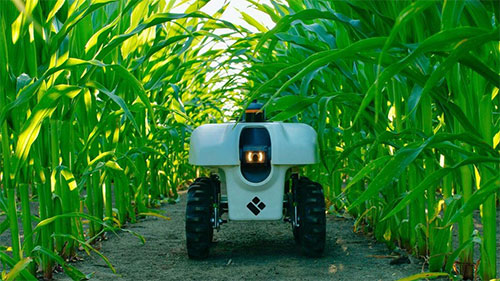

## Overview

Weeds have always been a problem in edible crop agriculture. They compete with crops for vital resources and can reduce their overall production. One of the most common practices to deal with weeds is to “broadcast” spray foliar herbicide over an entire field. However, herbicide usage in crop production can have many unintended negative effects not only on the environment but the humans who end up ingesting the crops as well. Currently, there are several companies who are working on solutions to this problem. One approach involves using robots who rely on machine vision to selectively spray herbicide or use some other elimination technique only on the areas that contain the weeds. In order to do this the robot must be able to distinguish the difference between the weed and the edible crop. Additionally, the robot must also be able to locate (draw bounding boxes around) both the weed and crop in order to properly preserve the crop and eliminate the weed. Below are the steps necessary for developing an object detection model which would the driving mechanism behind this machine vision task. Ultimately, this would allow farmers to reduce the use of herbicides, potentially lowering production costs as well as improving the health of humans and the planet.

## Data Understanding

The data used in this project was sourced from a [Kaggle](https://www.kaggle.com/datasets/ravirajsinh45/crop-and-weed-detection-data-with-bounding-boxes) dataset. The dataset contained 546 origial colored (RGB) 512x512 images of sesame crops and weeds. The original images were augmented to produce 1300 unique images total in the dataset. Each image had an associated .txt file annotation in YOLO format which contained the ground truth class labels and bounding box locations. The YOLO annotation format is as follows: 

(Class Label, Bounding Box "X" Center Coordinate, Bounding Box "Y" Center Coordinate, Bounding Box Width, Bounding Box Height)

Infomation from this [PyImageSearch](https://pyimagesearch.com/2020/10/12/multi-class-object-detection-and-bounding-box-regression-with-keras-tensorflow-and-deep-learning/) tutorial was very helpful in understanding the process and workflow for this project.

## Data Preparation

First we need to import the necessary libraries for this project.

In [2]:
# The libraries we need for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import time
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import Xception, VGG16, ResNet152V2, InceptionResNetV2, MobileNetV2, DenseNet201, NASNetLarge, EfficientNetB7
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from mean_average_precision import MetricBuilder

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


### Importing Data

Next we need to import the data from the repositories 'Data' folder. To do this we need to create a path to the data and then make a seperate list for the images and assocatied annotations.

In [ ]:
# setting data paths and making list of each file type
path = '../Data/'

# creating list of images
image_list = [x for x in os.listdir(path) if x.endswith('.jpeg')]

# creating list of labels
label_list = [x for x in os.listdir(path) if x.endswith('.txt')]

# sorting the list of images and labels so order matches
image_list.sort()
label_list.sort()

In [ ]:
# checking image and label lists
image_list_check = [x[:-5] for x in image_list]
label_list_check = [x[:-4] for x in label_list]
                    
image_list_check == label_list_check

Then we abstract the annotation data drom the .txt file and put it into a dataframe in YOLO format. Yolo annotation format is as follows:

(Image File Name, Class Label, Bounding Box "X" Center Coordinate, Bounding Box "Y" Center Coordinate, Bounding Box Width, Bounding Box Height)

In [ ]:
# creating initial dataframe from txt files (YOLO format)
df = pd.DataFrame(columns=['image_file', 'class', 'x_center', 'y_center', 'width', 'height'])

df['image_file'] = image_list

i=0
for file in df['image_file']:
    label = open(path + file[:-5] +'.txt', 'r').readline().split()
    df.loc[i, 'class'] = int(label[0])
    df.loc[i, 'x_center'] = float(label[1])
    df.loc[i, 'y_center'] = float(label[2])
    df.loc[i, 'width'] = float(label[3])
    df.loc[i, 'height'] = float(label[4])
    i +=1

# checking dataframe
df.head()

In [ ]:
# checking all data got pulled into dataframe
df.info()

### Formatting Data for Modeling

Once the data is in a dataframe we conrvet from YOLO to Pascal VOC format. The Pascal VOC annotation format is as follows:

(Image File Name, Image Width, Image Height, Bounding Box "X" Minimum, Bounding Box "Y" Minimum, Bounding Box "X" Maximum, Bounding Box "Y" Maximum, Class Label)

In [ ]:
# creating dataframe in Pascal VOC format with bounding boxes scaled (from originl data)
df_pas_voc = pd.DataFrame(columns = ['filename', 'width', 'height', 'x_min', 'y_min', 'x_max', 'y_max', 'class'])

df_pas_voc['filename'] = df['image_file']
df_pas_voc['class'] = df['class']
df_pas_voc['width'] = 512
df_pas_voc['height'] = 512

for i in range(len(df_pas_voc)):
    df_pas_voc.loc[i, 'x_min'] = df.loc[i, 'x_center'] - (df.loc[i, 'width']/2)
    df_pas_voc.loc[i, 'y_min'] = df.loc[i, 'y_center'] - (df.loc[i, 'height']/2)
    df_pas_voc.loc[i, 'x_max'] = df.loc[i, 'x_center'] + (df.loc[i, 'width']/2)
    df_pas_voc.loc[i, 'y_max'] = df.loc[i, 'y_center'] + (df.loc[i, 'height']/2)

# checking pascal voc dataframe
df_pas_voc.head()

We then load the images, reduce their size to 224x224 and scale their pixel intensities to between 0 and 1 to reduce the computational requirements during modeling. Then we format the image data into a numpy array which necessary for modeling. 

In [ ]:
# loading images and preprocessing into and array of pixel values
data = []
for filename in df_pas_voc['filename']:
    image = load_img(path + filename, target_size=(224, 224))
    image = img_to_array(image)
    data.append(image)
    
# converting data (images) into numpy array and scaling pixel intensities
data = np.array(data, dtype='float32') / 255.0

# checking format of data
data

Next we one hot encode our class labels and format them into a numpy array for modeling. 

In [ ]:
# creating list of labels
labels = []
for i in range(len(df_pas_voc)):
    labels.append(df_pas_voc.loc[i, 'class']) 

# converting labels list into numpy array
labels = np.array(labels)    

# one hot encoding labels using tf's utility function
labels = to_categorical(labels)

# checking format of labels    
labels

Then we format our bounding box location data into a numpy array for modeling.

In [ ]:
# creating list of bounding box values
bboxes = []
for i in range(len(df_pas_voc)):
    bboxes.append((df_pas_voc.loc[i, 'x_min'], df_pas_voc.loc[i, 'y_min'], df_pas_voc.loc[i, 'x_max'], df_pas_voc.loc[i, 'y_max']))

# converting bounding boxes into numpy array
bboxes = np.array(bboxes, dtype="float32")

# checking format of bounding boxes
bboxes

Lastly, we create a numyp array of image paths for modeling.

In [ ]:
# creating list of image paths
image_paths = []
for i in range(len(df_pas_voc)):
    image_paths.append((path + df_pas_voc.loc[i, "filename"]))
    
# converting image paths into numpy array
image_paths = np.array(image_paths)

# checking format of image paths
image_paths

### Train Test Split

Next we split our data into training and testing sets using sklearns train_test_split function. The training set contains 80% of the original data and the test set contains 20%.

In [ ]:
# creating train test split
split1 = train_test_split(data, labels, bboxes, image_paths, test_size=0.2, random_state=42)

In [ ]:
# setting variables from train test split
(x_train_0, x_test) = split1[:2]
(labels_train_0, labels_test) = split1[2:4]
(bboxes_train_0, bboxes_test) = split1[4:6]
(image_paths_train_0, image_paths_test) = split1[6:]

Then we split our training data so we can have a validation set. The validation set contains 10% of the original training data.

In [ ]:
# splittng training data for validation
split2 = train_test_split(x_train_0, labels_train_0, bboxes_train_0, image_paths_train_0, test_size=0.1, random_state=42)

(x_train, x_val) = split2[:2]
(labels_train, labels_val) = split2[2:4]
(bboxes_train, bboxes_val) = split2[4:6]
(image_paths_train, image_paths_val) = split2[6:]

In [ ]:
# checking shape from train test split
print(f"x_train shape : {x_train.shape}")
print(f"x_val shape : {x_val.shape}")
print(f"x_test shape : {x_test.shape}")
print(f"labels_train shape : {labels_train.shape}")
print(f"labels_val shape : {labels_val.shape}")
print(f"labels_test shape : {labels_test.shape}")
print(f"bboxes_train shape : {bboxes_train.shape}")
print(f"bboxes_val shape : {bboxes_val.shape}")
print(f"bboxes_test shape : {bboxes_test.shape}")
print(f"image_paths_train shape : {image_paths_train.shape}")
print(f"image_paths_val shape : {image_paths_val.shape}")
print(f"image_paths_test shape : {image_paths_test.shape}")

### Creating Evaluation Functions

Next we create some useful functions that will help us plot the loss and accuracy of our different model iterations during training.

In [ ]:
# creating function for plotting loss data after model training
def plot_loss(model_name, num_epochs):
    # plotting the total loss, class label loss, and bounding box loss during model training
    loss_names = ["loss", "class_label_loss", "bounding_box_loss"]
    N = np.arange(0, num_epochs)
    plt.style.use("ggplot")
    (fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
    fig.tight_layout(pad=5.0)
   

    # loop over the loss names
    for (i, l) in enumerate(loss_names):
        # plot the loss for both the training and validation data
        title = "Loss for {}".format(l) if l != "loss" else "Total loss"
        ax[i].set_title(title)
        ax[i].set_xlabel("Epoch #")
        ax[i].set_ylabel("Loss")
        ax[i].plot(N, H.history[l], label=l)
        ax[i].plot(N, H.history["val_" + l], label="val_" + l)
        ax[i].legend()
    
    # printing final epoch total loss, class label loss and bounding box loss
    print(f"Final epoch training total loss during {model_name} training: {H.history['loss'][num_epochs-1]}")
    print(f"Final epoch training class label loss during {model_name} training: {H.history['class_label_loss'][num_epochs-1]}")
    print(f"Final epoch training bounding box loss during {model_name} training: {H.history['bounding_box_loss'][num_epochs-1]}")
    
    print(f"Final epoch validation total loss during {model_name} training: {H.history['val_loss'][num_epochs-1]}")
    print(f"Final epoch validation class label loss during {model_name} training: {H.history['val_class_label_loss'][num_epochs-1]}")
    print(f"Final epoch validation bounding box loss during {model_name} training: {H.history['val_bounding_box_loss'][num_epochs-1]}")
    
    # saving plot
    plt.savefig(f"../Plots/Loss_Plots/{model_name}_training_loss")
    
    return plt

In [ ]:
# creating function for plotting accuracy data after model training
def plot_accuracy(model_name, num_epochs):
    # plotting the class label accuracies during model training
    N = np.arange(0, num_epochs) #number of epochs
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, H.history["class_label_accuracy"],
    label="class_label_train_acc")
    plt.plot(N, H.history["val_class_label_accuracy"],
    label="class_label_val_acc")
    plt.title("Class Label Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    
    # saving plot
    plt.savefig(f"../Plots/Accuracy_Plots{model_name}_training_label_accuracy");
    
    # printing final epoch accuracy
    print(f"Final epoch training class label accurracy during {model_name} training: {H.history['class_label_accuracy'][num_epochs-1]}")
    print(f"Final epoch validation class label accurracy during {model_name} training: {H.history['val_class_label_accuracy'][num_epochs-1]}")
    
    return plt

Additionally, we created a set of functions that will help us calculate the mean average precision scores according to Pascal VOC and COCO formats as well as the average inference time to predict an image's labels. Ultiamtely, these metrics will help us evaluate a model's performance, driving the iteration process in order to select the best model.

In [ ]:
# creating a function that computes three different mAP metrics for evaluating object detection models
def evaluate_val(model, model_name):
    # getting the predictions for the bounding boxes, class label and confidence for the test set and avg inference time to make predictions on image
    preds = []
    inf_time = []
    
    for i in range(len(image_paths_val)):
        image = load_img(image_paths_val[i], target_size=(224, 224))
        image = img_to_array(image) / 255.0
        image = np.expand_dims(image, axis=0)
    
        start_time = time.time()
        (bboxPred, labelPred) = model.predict(image)
        stop_time= time.time()
        duration = stop_time - start_time
        inf_time.append(duration)
    
        (startX, startY, endX, endY) = bboxPred[0]
        startX = int(startX * 224)
        startY = int(startY * 224)
        endX = int(endX * 224)
        endY = int(endY * 224)
        lbl = int(np.argmax(labelPred, axis=1)) #predicted class label
        cf = np.max(labelPred) #predicted class confidence
        preds.append([startX, startY, endX, endY, lbl, cf])

    # preds format = [xmin, ymin, xmax, ymax, class_id, confidence]
    preds = np.array(preds)
    
    # computing avg inference time for each image
    avg_inf_time = np.mean(inf_time)
                 
    # getting the ground truths for bounding boxes and class labels (and setting "difficult" and "crowd" to 0)
    gts = []
    
    for i in range(len(image_paths_val)):
        gt_label = int(np.argmax(labels_val[i]))
        (gt_startX, gt_startY, gt_endX, gt_endY) = bboxes_val[i]
        gt_startX = int(gt_startX * 224)
        gt_startY = int(gt_startY * 224)
        gt_endX = int(gt_endX * 224)
        gt_endY = int(gt_endY * 224)
        gts.append([gt_startX, gt_startY, gt_endX, gt_endY, gt_label, 0, 0])

    # gts format = [xmin, ymin, xmax, ymax, class_id, difficult, crowd]
    gts = np.array(gts)
    
    # instantiating map function and adding preds and gts to it               
    map_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=2)
    for i in range(len(image_paths_val)):
        map_fn.add(preds, gts)
    
    # computing PASCAL VOC metric
    voc_pascal_map = map_fn.value(iou_thresholds=0.5, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']
    # computing PASCAL VOC metric at the all points
    voc_pascal_map_allpts = map_fn.value(iou_thresholds=0.5)['mAP']
    # computing metric COCO metric
    coco_map = map_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']
    
    print(f"VOC PASCAL mAP for {model_name} validation data: {voc_pascal_map}")
    print(f"VOC PASCAL mAP in all points for {model_name} validation data: {voc_pascal_map_allpts}")
    print(f"COCO mAP for {model_name} validation data: {coco_map}")
    print(f"Average inference time for {model_name} validation data: {avg_inf_time}")  
    
    # returning a dictionary of the mAP scores and inference time to be added to the results dataframe (df_results)
    result_val = {'model': model_name, 'voc_pascal_map': voc_pascal_map, 'voc_pascal_map_allpts': voc_pascal_map_allpts, 'coco_map': coco_map, 'avg_inf_time': avg_inf_time}
    return result_val

In [ ]:
# creating a function that computes three different mAP metrics for evaluating object detection models
def evaluate_test(model, model_name):
    # getting the predictions for the bounding boxes, class label and confidence for the test set and avg inference time to make predictions on image
    preds = []
    inf_time = []
    
    for i in range(len(image_paths_test)):
        image = load_img(image_paths_test[i], target_size=(224, 224))
        image = img_to_array(image) / 255.0
        image = np.expand_dims(image, axis=0)
    
        start_time = time.time()
        (bboxPred, labelPred) = model.predict(image)
        stop_time= time.time()
        duration = stop_time - start_time
        inf_time.append(duration)
    
        (startX, startY, endX, endY) = bboxPred[0]
        startX = int(startX * 224)
        startY = int(startY * 224)
        endX = int(endX * 224)
        endY = int(endY * 224)
        lbl = int(np.argmax(labelPred, axis=1)) #predicted class label
        cf = np.max(labelPred) #predicted class confidence
        preds.append([startX, startY, endX, endY, lbl, cf])

    # preds format = [xmin, ymin, xmax, ymax, class_id, confidence]
    preds = np.array(preds)
    
    # computing avg inference time for each image
    avg_inf_time = np.mean(inf_time)
                 
    # getting the ground truths for bounding boxes and class labels (and setting "difficult" and "crowd" to 0)
    gts = []
    
    for i in range(len(image_paths_test)):
        gt_label = int(np.argmax(labels_test[i]))
        (gt_startX, gt_startY, gt_endX, gt_endY) = bboxes_test[i]
        gt_startX = int(gt_startX * 224)
        gt_startY = int(gt_startY * 224)
        gt_endX = int(gt_endX * 224)
        gt_endY = int(gt_endY * 224)
        gts.append([gt_startX, gt_startY, gt_endX, gt_endY, gt_label, 0, 0])

    # gts format = [xmin, ymin, xmax, ymax, class_id, difficult, crowd]
    gts = np.array(gts)
    
    # instantiating map function and adding preds and gts to it               
    map_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=2)
    for i in range(len(image_paths_test)):
        map_fn.add(preds, gts)
    
    # computing PASCAL VOC metric
    voc_pascal_map = map_fn.value(iou_thresholds=0.5, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']
    # computing PASCAL VOC metric at the all points
    voc_pascal_map_allpts = map_fn.value(iou_thresholds=0.5)['mAP']
    # computing metric COCO metric
    coco_map = map_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']
    
    print(f"VOC PASCAL mAP for {model_name} test data: {voc_pascal_map}")
    print(f"VOC PASCAL mAP in all points for {model_name} test data: {voc_pascal_map_allpts}")
    print(f"COCO mAP for {model_name} test data: {coco_map}")
    print(f"Average inference time for {model_name} test data: {avg_inf_time}")  
    
    # returning a dictionary of the mAP scores and inference time to be added to the results dataframe (df_results)
    result_test = {'model': model_name, 'voc_pascal_map': voc_pascal_map, 'voc_pascal_map_allpts': voc_pascal_map_allpts, 'coco_map': coco_map, 'avg_inf_time': avg_inf_time}
    return result_test

We created two data frames, one to store the mean average precion scores and average inference time during the modeling process and the other to store the final models evualuation metrics for the test set.

In [ ]:
# creating data frame which stores mAp scores and inference time for each model's validation data
df_results_val= pd.DataFrame(columns = ['model', 'voc_pascal_map', 'voc_pascal_map_allpts', 'coco_map', 'avg_inf_time'])

In [ ]:
# creating data frame which stores mAp scores and inference time for each model's test data
df_results_test = pd.DataFrame(columns = ['model', 'voc_pascal_map', 'voc_pascal_map_allpts', 'coco_map', 'avg_inf_time'])

## Modeling - Training

For the modeling process we utlized transfer learning techniques by using the structure and weights from seven different keras models which were pretrained on the imagenet dataset to create the 'backbone' of our model. These models included Xception, VGG16, ResNet152V2, MobileNetV2, DenseNet201 and NASNetLarge. We also created one custom simple model "backbone" which was trained on the crop and weed dataset. The "backbones" were connected to a pair of different model "heads", one for predicting class lables and one for predicting bounding box labels. 
We then used the training loss information and the COCO mean average precision (mAP) metric to iterate through several different versions of the model heads for each backbone. Below is the structure of the custom backbone and each model head:

### Custom Model Backbone

In [ ]:
# creating custom model backbone
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3,3), activation='relu')(pool3)
pool4 = MaxPool2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(512, (3,3), activation='relu')(pool4)
pool5 = MaxPool2D(pool_size=(2, 2))(conv5)
flat = Flatten()(pool5)

### Model Heads V1

In [ ]:
# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dense(64, activation="relu")(bbox_head1)
bbox_head3 = Dense(32, activation="relu")(bbox_head2)
bbox_head_v1 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head3)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head_v1 = Dense(2, activation="sigmoid", name="class_label")(class_head4)

### Model Heads V2

In [ ]:
# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dropout(0.5)(bbox_head3)
bbox_head5 = Dense(32, activation="relu")(bbox_head4)
bbox_head6 = Dropout(0.5)(bbox_head5)
bbox_head_v2 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head6)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head5 = Dense(512, activation="relu")(class_head4)
class_head6 = Dropout(0.5)(class_head5)
class_head_v2 = Dense(2, activation="sigmoid", name="class_label")(class_head6)

### Model Heads V3

In [ ]:
# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dense(32, activation="relu")(bbox_head3)
bbox_head_v3 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head4)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head5 = Dense(256, activation="relu")(class_head4)
class_head6 = Dropout(0.5)(class_head5)
class_head7 = Dense(128, activation="relu")(class_head6)
class_head8 = Dropout(0.5)(class_head7)
class_head_v3 = Dense(2, activation="sigmoid", name="class_label")(class_head8)

### Model Heads V4

In [ ]:
# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(256, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(128, activation="relu")(bbox_head2)
bbox_head4 = Dense(64, activation="relu")(bbox_head3)
bbox_head5 = Dense(32, activation="relu")(bbox_head4)
bbox_head_v4 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head5)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head5 = Dense(256, activation="relu")(class_head4)
class_head6 = Dropout(0.5)(class_head5)
class_head7 = Dense(128, activation="relu")(class_head6)
class_head8 = Dropout(0.5)(class_head7)
class_head_v4 = Dense(2, activation="sigmoid", name="class_label")(class_head8)

### Model Heads V5

In [ ]:
# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(256, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(128, activation="relu")(bbox_head2)
bbox_head4 = Dense(64, activation="relu")(bbox_head3)
bbox_head5 = Dense(32, activation="relu")(bbox_head4)
bbox_head_v5 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head5)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(256, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head_v5 = Dense(2, activation="sigmoid", name="class_label")(class_head4)

### Model Heads V6

In [ ]:
# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(256, activation="relu")(flat)
bbox_head2 = Dense(128, activation="relu")(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dense(32, activation="relu")(bbox_head3)
bbox_head_v6 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head4)

# constructing an output layer to predict class labels
class_head1 = Dense(256, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(128, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head_v6 = Dense(2, activation="sigmoid", name="class_label")(class_head4)

### Model Heads V7

In [ ]:
# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dense(32, activation="relu")(bbox_head3)
bbox_head_v7 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head4)

# constructing an output layer to predict class labels
class_head1 = Dense(128, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(64, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head_v7 = Dense(2, activation="sigmoid", name="class_label")(class_head4)

### Configuration Parameters

Below are the parameters for the model training process.

In [ ]:
# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# setting batch size
batch_size = 32

# setting number of epcochs
epochs = 30

### Xception

In [ ]:
# loading network but leaving off output layers
xception = Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freezing all network layers during training so they are not updated
xception.trainable = False

# flattening the max-pooling output of network
flatten = xception.output
flat = Flatten()(flatten)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dense(64, activation="relu")(bbox_head1)
bbox_head3 = Dense(32, activation="relu")(bbox_head2)
bbox_head_v1 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head3)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head_v1 = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
xception_model_v1 = Model(inputs=xception.input, outputs=(bbox_head_v1, class_head_v1))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling model
xception_model_v1.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(xception_model_v1.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = xception_model_v1.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
xception_model_v1.save('../Models/xception_model_v1.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 70s 2s/step - loss: 0.3647 - bounding_box_loss: 0.0253 - class_label_loss: 0.3394 - bounding_box_accuracy: 0.5598 - class_label_accuracy: 0.9092 - val_loss: 0.3784 - val_bounding_box_loss: 0.0141 - val_class_label_loss: 0.3643 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9423
# Epoch 2/30
# 30/30 [==============================] - 90s 3s/step - loss: 0.2137 - bounding_box_loss: 0.0105 - class_label_loss: 0.2032 - bounding_box_accuracy: 0.6571 - class_label_accuracy: 0.9615 - val_loss: 0.3603 - val_bounding_box_loss: 0.0110 - val_class_label_loss: 0.3493 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9423
# Epoch 3/30
# 30/30 [==============================] - 82s 3s/step - loss: 0.1976 - bounding_box_loss: 0.0070 - class_label_loss: 0.1906 - bounding_box_accuracy: 0.7254 - class_label_accuracy: 0.9615 - val_loss: 0.3134 - val_bounding_box_loss: 0.0089 - val_class_label_loss: 0.3045 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9423
# Epoch 4/30
# 30/30 [==============================] - 79s 3s/step - loss: 0.1476 - bounding_box_loss: 0.0054 - class_label_loss: 0.1423 - bounding_box_accuracy: 0.7639 - class_label_accuracy: 0.9701 - val_loss: 0.3621 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 0.3539 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9423
# Epoch 5/30
# 30/30 [==============================] - 80s 3s/step - loss: 0.1297 - bounding_box_loss: 0.0045 - class_label_loss: 0.1253 - bounding_box_accuracy: 0.7853 - class_label_accuracy: 0.9712 - val_loss: 0.3076 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 0.2994 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9423
# Epoch 6/30
# 30/30 [==============================] - 81s 3s/step - loss: 0.1193 - bounding_box_loss: 0.0038 - class_label_loss: 0.1155 - bounding_box_accuracy: 0.8066 - class_label_accuracy: 0.9712 - val_loss: 0.3610 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.3529 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9423
# Epoch 7/30
# 30/30 [==============================] - 82s 3s/step - loss: 0.0888 - bounding_box_loss: 0.0039 - class_label_loss: 0.0849 - bounding_box_accuracy: 0.7981 - class_label_accuracy: 0.9797 - val_loss: 0.3455 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.3374 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9327
# Epoch 8/30
# 30/30 [==============================] - 80s 3s/step - loss: 0.0861 - bounding_box_loss: 0.0028 - class_label_loss: 0.0834 - bounding_box_accuracy: 0.8526 - class_label_accuracy: 0.9808 - val_loss: 0.3387 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.3307 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9327
# Epoch 9/30
# 30/30 [==============================] - 81s 3s/step - loss: 0.0815 - bounding_box_loss: 0.0025 - class_label_loss: 0.0790 - bounding_box_accuracy: 0.8440 - class_label_accuracy: 0.9765 - val_loss: 0.4087 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.4002 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9423
# Epoch 10/30
# 30/30 [==============================] - 81s 3s/step - loss: 0.0726 - bounding_box_loss: 0.0023 - class_label_loss: 0.0702 - bounding_box_accuracy: 0.8697 - class_label_accuracy: 0.9797 - val_loss: 0.3284 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 0.3202 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9423
# Epoch 11/30
# 30/30 [==============================] - 80s 3s/step - loss: 0.0503 - bounding_box_loss: 0.0024 - class_label_loss: 0.0480 - bounding_box_accuracy: 0.8707 - class_label_accuracy: 0.9882 - val_loss: 0.4617 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.4535 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9423
# Epoch 12/30
# 30/30 [==============================] - 80s 3s/step - loss: 0.0634 - bounding_box_loss: 0.0021 - class_label_loss: 0.0613 - bounding_box_accuracy: 0.8611 - class_label_accuracy: 0.9840 - val_loss: 0.3530 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 0.3447 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9519
# Epoch 13/30
# 30/30 [==============================] - 80s 3s/step - loss: 0.0594 - bounding_box_loss: 0.0023 - class_label_loss: 0.0571 - bounding_box_accuracy: 0.8707 - class_label_accuracy: 0.9861 - val_loss: 0.3808 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.3728 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9519
# Epoch 14/30
# 30/30 [==============================] - 80s 3s/step - loss: 0.0421 - bounding_box_loss: 0.0018 - class_label_loss: 0.0404 - bounding_box_accuracy: 0.8932 - class_label_accuracy: 0.9882 - val_loss: 0.3745 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.3661 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9327
# Epoch 15/30
# 30/30 [==============================] - 79s 3s/step - loss: 0.0432 - bounding_box_loss: 0.0015 - class_label_loss: 0.0418 - bounding_box_accuracy: 0.8974 - class_label_accuracy: 0.9882 - val_loss: 0.3322 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.3243 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9423
# Epoch 16/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.0426 - bounding_box_loss: 0.0013 - class_label_loss: 0.0413 - bounding_box_accuracy: 0.8857 - class_label_accuracy: 0.9925 - val_loss: 0.3584 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.3506 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9423
# Epoch 17/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.0456 - bounding_box_loss: 0.0013 - class_label_loss: 0.0443 - bounding_box_accuracy: 0.8793 - class_label_accuracy: 0.9893 - val_loss: 0.4576 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.4489 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9327
# Epoch 18/30
# 30/30 [==============================] - 79s 3s/step - loss: 0.0347 - bounding_box_loss: 0.0015 - class_label_loss: 0.0332 - bounding_box_accuracy: 0.8996 - class_label_accuracy: 0.9882 - val_loss: 0.4639 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 0.4557 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9423
# Epoch 19/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.0276 - bounding_box_loss: 0.0013 - class_label_loss: 0.0263 - bounding_box_accuracy: 0.9017 - class_label_accuracy: 0.9936 - val_loss: 0.4368 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.4287 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9327
# Epoch 20/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.0334 - bounding_box_loss: 0.0013 - class_label_loss: 0.0321 - bounding_box_accuracy: 0.9135 - class_label_accuracy: 0.9947 - val_loss: 0.4170 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.4097 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9327
# Epoch 21/30
# 30/30 [==============================] - 76s 3s/step - loss: 0.0373 - bounding_box_loss: 0.0013 - class_label_loss: 0.0360 - bounding_box_accuracy: 0.8996 - class_label_accuracy: 0.9872 - val_loss: 0.3947 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.3871 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9327
# Epoch 22/30
# 30/30 [==============================] - 75s 3s/step - loss: 0.0414 - bounding_box_loss: 0.0014 - class_label_loss: 0.0399 - bounding_box_accuracy: 0.9092 - class_label_accuracy: 0.9915 - val_loss: 0.3962 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.3882 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9519
# Epoch 23/30
# 30/30 [==============================] - 75s 3s/step - loss: 0.0412 - bounding_box_loss: 0.0012 - class_label_loss: 0.0400 - bounding_box_accuracy: 0.9038 - class_label_accuracy: 0.9882 - val_loss: 0.4259 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.4184 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9423
# Epoch 24/30
# 30/30 [==============================] - 75s 3s/step - loss: 0.0262 - bounding_box_loss: 8.9989e-04 - class_label_loss: 0.0253 - bounding_box_accuracy: 0.9103 - class_label_accuracy: 0.9904 - val_loss: 0.4708 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.4631 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9423
# Epoch 25/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.0210 - bounding_box_loss: 7.5693e-04 - class_label_loss: 0.0202 - bounding_box_accuracy: 0.9338 - class_label_accuracy: 0.9936 - val_loss: 0.5129 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.5055 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9327
# Epoch 26/30
# 30/30 [==============================] - 80s 3s/step - loss: 0.0189 - bounding_box_loss: 8.7472e-04 - class_label_loss: 0.0180 - bounding_box_accuracy: 0.9241 - class_label_accuracy: 0.9968 - val_loss: 0.4750 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.4675 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9327
# Epoch 27/30
# 30/30 [==============================] - 79s 3s/step - loss: 0.0346 - bounding_box_loss: 0.0011 - class_label_loss: 0.0335 - bounding_box_accuracy: 0.9124 - class_label_accuracy: 0.9915 - val_loss: 0.5005 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.4921 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9423
# Epoch 28/30
# 30/30 [==============================] - 84s 3s/step - loss: 0.0201 - bounding_box_loss: 0.0011 - class_label_loss: 0.0190 - bounding_box_accuracy: 0.9145 - class_label_accuracy: 0.9957 - val_loss: 0.5642 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.5561 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9327
# Epoch 29/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.0311 - bounding_box_loss: 0.0010 - class_label_loss: 0.0301 - bounding_box_accuracy: 0.9028 - class_label_accuracy: 0.9904 - val_loss: 0.4871 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.4790 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9423
# Epoch 30/30
# 30/30 [==============================] - 77s 3s/step - loss: 0.0125 - bounding_box_loss: 0.0014 - class_label_loss: 0.0112 - bounding_box_accuracy: 0.9135 - class_label_accuracy: 0.9968 - val_loss: 0.5184 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.5103 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9327

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='xception_model_v1', num_epochs=30)

In [ ]:
# Final epoch training total loss during xception_model_v1 training: 0.012523028999567032
# Final epoch training class label loss during xception_model_v1 training: 0.011151311919093132
# Final epoch training bounding box loss during xception_model_v1 training: 0.0013717153342440724
# Final epoch validation total loss during xception_model_v1 training: 0.5184147357940674
# Final epoch validation class label loss during xception_model_v1 training: 0.5102716684341431
# Final epoch validation bounding box loss during xception_model_v1 training: 0.008143125101923943

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='xception_model_v1', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during xception_model_v1 training: 0.9967948794364929
# Final epoch validation class label accurracy during xception_model_v1 training: 0.932692289352417

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=xception_model_v1, model_name='xception_model_v1')

In [ ]:
# VOC PASCAL mAP for xception_model_v1 validation data: 0.3962478041648865
# VOC PASCAL mAP in all points for xception_model_v1 validation data: 0.3581908941268921
# COCO mAP for xception_model_v1 validation data: 0.477825790643692
# Average inference time for xception_model_v1 validation data: 0.13074778364254877

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

In [ ]:
# loading network but leaving off output layers
xception = Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freezing all VGG layers during training so they are not updated
xception.trainable = False

# flattening the max-pooling output of network
flatten = xception.output
flat = Flatten()(flatten)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dropout(0.5)(bbox_head3)
bbox_head5 = Dense(32, activation="relu")(bbox_head4)
bbox_head6 = Dropout(0.5)(bbox_head5)
bbox_head_v2 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head6)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head5 = Dense(512, activation="relu")(class_head4)
class_head6 = Dropout(0.5)(class_head5)
class_head_v2 = Dense(2, activation="sigmoid", name="class_label")(class_head6)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
xception_model_v2 = Model(inputs=xception.input, outputs=(bbox_head_v2, class_head_v2))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling model
xception_model_v2.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(xception_model_v2.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = xception_model_v2.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
xception_model_v2.save('../Models/xception_model_v2.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 72s 2s/step - loss: 0.5697 - bounding_box_loss: 0.1009 - class_label_loss: 0.4688 - bounding_box_accuracy: 0.4658 - class_label_accuracy: 0.8558 - val_loss: 0.3770 - val_bounding_box_loss: 0.0233 - val_class_label_loss: 0.3537 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9423
# Epoch 2/30
# 30/30 [==============================] - 87s 3s/step - loss: 0.3543 - bounding_box_loss: 0.0925 - class_label_loss: 0.2618 - bounding_box_accuracy: 0.4402 - class_label_accuracy: 0.9498 - val_loss: 0.3620 - val_bounding_box_loss: 0.0201 - val_class_label_loss: 0.3419 - val_bounding_box_accuracy: 0.4904 - val_class_label_accuracy: 0.9423
# Epoch 3/30
# 30/30 [==============================] - 87s 3s/step - loss: 0.2799 - bounding_box_loss: 0.0716 - class_label_loss: 0.2083 - bounding_box_accuracy: 0.4701 - class_label_accuracy: 0.9594 - val_loss: 0.3355 - val_bounding_box_loss: 0.0187 - val_class_label_loss: 0.3168 - val_bounding_box_accuracy: 0.3846 - val_class_label_accuracy: 0.9423
# Epoch 4/30
# 30/30 [==============================] - 81s 3s/step - loss: 0.2348 - bounding_box_loss: 0.0668 - class_label_loss: 0.1680 - bounding_box_accuracy: 0.4509 - class_label_accuracy: 0.9615 - val_loss: 0.3189 - val_bounding_box_loss: 0.0167 - val_class_label_loss: 0.3021 - val_bounding_box_accuracy: 0.3654 - val_class_label_accuracy: 0.9423
# Epoch 5/30
# 30/30 [==============================] - 85s 3s/step - loss: 0.2301 - bounding_box_loss: 0.0596 - class_label_loss: 0.1705 - bounding_box_accuracy: 0.4551 - class_label_accuracy: 0.9637 - val_loss: 0.2922 - val_bounding_box_loss: 0.0165 - val_class_label_loss: 0.2757 - val_bounding_box_accuracy: 0.4038 - val_class_label_accuracy: 0.9423
# Epoch 6/30
# 30/30 [==============================] - 82s 3s/step - loss: 0.1991 - bounding_box_loss: 0.0563 - class_label_loss: 0.1427 - bounding_box_accuracy: 0.4733 - class_label_accuracy: 0.9690 - val_loss: 0.2962 - val_bounding_box_loss: 0.0155 - val_class_label_loss: 0.2808 - val_bounding_box_accuracy: 0.3846 - val_class_label_accuracy: 0.9423
# Epoch 7/30
# 30/30 [==============================] - 82s 3s/step - loss: 0.1570 - bounding_box_loss: 0.0505 - class_label_loss: 0.1065 - bounding_box_accuracy: 0.4637 - class_label_accuracy: 0.9722 - val_loss: 0.3056 - val_bounding_box_loss: 0.0173 - val_class_label_loss: 0.2883 - val_bounding_box_accuracy: 0.4712 - val_class_label_accuracy: 0.9423
# Epoch 8/30
# 30/30 [==============================] - 82s 3s/step - loss: 0.1584 - bounding_box_loss: 0.0450 - class_label_loss: 0.1134 - bounding_box_accuracy: 0.4850 - class_label_accuracy: 0.9733 - val_loss: 0.3529 - val_bounding_box_loss: 0.0139 - val_class_label_loss: 0.3390 - val_bounding_box_accuracy: 0.5000 - val_class_label_accuracy: 0.9327
# Epoch 9/30
# 30/30 [==============================] - 83s 3s/step - loss: 0.1522 - bounding_box_loss: 0.0481 - class_label_loss: 0.1041 - bounding_box_accuracy: 0.5096 - class_label_accuracy: 0.9712 - val_loss: 0.3038 - val_bounding_box_loss: 0.0149 - val_class_label_loss: 0.2889 - val_bounding_box_accuracy: 0.4519 - val_class_label_accuracy: 0.9423
# Epoch 10/30
# 30/30 [==============================] - 82s 3s/step - loss: 0.1424 - bounding_box_loss: 0.0461 - class_label_loss: 0.0963 - bounding_box_accuracy: 0.4829 - class_label_accuracy: 0.9776 - val_loss: 0.3190 - val_bounding_box_loss: 0.0144 - val_class_label_loss: 0.3046 - val_bounding_box_accuracy: 0.5000 - val_class_label_accuracy: 0.9423
# Epoch 11/30
# 30/30 [==============================] - 83s 3s/step - loss: 0.1310 - bounding_box_loss: 0.0427 - class_label_loss: 0.0884 - bounding_box_accuracy: 0.5075 - class_label_accuracy: 0.9765 - val_loss: 0.3228 - val_bounding_box_loss: 0.0150 - val_class_label_loss: 0.3078 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9423
# Epoch 12/30
# 30/30 [==============================] - 81s 3s/step - loss: 0.1152 - bounding_box_loss: 0.0410 - class_label_loss: 0.0742 - bounding_box_accuracy: 0.4979 - class_label_accuracy: 0.9797 - val_loss: 0.3221 - val_bounding_box_loss: 0.0139 - val_class_label_loss: 0.3082 - val_bounding_box_accuracy: 0.5288 - val_class_label_accuracy: 0.9423
# Epoch 13/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.1149 - bounding_box_loss: 0.0370 - class_label_loss: 0.0779 - bounding_box_accuracy: 0.5171 - class_label_accuracy: 0.9808 - val_loss: 0.4228 - val_bounding_box_loss: 0.0150 - val_class_label_loss: 0.4079 - val_bounding_box_accuracy: 0.4135 - val_class_label_accuracy: 0.9327
# Epoch 14/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.0960 - bounding_box_loss: 0.0348 - class_label_loss: 0.0612 - bounding_box_accuracy: 0.4754 - class_label_accuracy: 0.9797 - val_loss: 0.3762 - val_bounding_box_loss: 0.0139 - val_class_label_loss: 0.3623 - val_bounding_box_accuracy: 0.4231 - val_class_label_accuracy: 0.9327
# Epoch 15/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.0957 - bounding_box_loss: 0.0376 - class_label_loss: 0.0580 - bounding_box_accuracy: 0.4808 - class_label_accuracy: 0.9861 - val_loss: 0.3705 - val_bounding_box_loss: 0.0141 - val_class_label_loss: 0.3564 - val_bounding_box_accuracy: 0.4423 - val_class_label_accuracy: 0.9327
# Epoch 16/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.0790 - bounding_box_loss: 0.0367 - class_label_loss: 0.0423 - bounding_box_accuracy: 0.5128 - class_label_accuracy: 0.9829 - val_loss: 0.3438 - val_bounding_box_loss: 0.0142 - val_class_label_loss: 0.3296 - val_bounding_box_accuracy: 0.4231 - val_class_label_accuracy: 0.9423
# Epoch 17/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.0872 - bounding_box_loss: 0.0342 - class_label_loss: 0.0531 - bounding_box_accuracy: 0.4840 - class_label_accuracy: 0.9797 - val_loss: 0.3605 - val_bounding_box_loss: 0.0163 - val_class_label_loss: 0.3441 - val_bounding_box_accuracy: 0.4615 - val_class_label_accuracy: 0.9327
# Epoch 18/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.0674 - bounding_box_loss: 0.0341 - class_label_loss: 0.0333 - bounding_box_accuracy: 0.4818 - class_label_accuracy: 0.9904 - val_loss: 0.4138 - val_bounding_box_loss: 0.0146 - val_class_label_loss: 0.3992 - val_bounding_box_accuracy: 0.3942 - val_class_label_accuracy: 0.9327
# Epoch 19/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.0888 - bounding_box_loss: 0.0323 - class_label_loss: 0.0565 - bounding_box_accuracy: 0.4882 - class_label_accuracy: 0.9818 - val_loss: 0.3948 - val_bounding_box_loss: 0.0149 - val_class_label_loss: 0.3799 - val_bounding_box_accuracy: 0.4327 - val_class_label_accuracy: 0.9327
# Epoch 20/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.0704 - bounding_box_loss: 0.0307 - class_label_loss: 0.0397 - bounding_box_accuracy: 0.5246 - class_label_accuracy: 0.9872 - val_loss: 0.4502 - val_bounding_box_loss: 0.0156 - val_class_label_loss: 0.4346 - val_bounding_box_accuracy: 0.4038 - val_class_label_accuracy: 0.9423
# Epoch 21/30
# 30/30 [==============================] - 79s 3s/step - loss: 0.0835 - bounding_box_loss: 0.0310 - class_label_loss: 0.0525 - bounding_box_accuracy: 0.4818 - class_label_accuracy: 0.9776 - val_loss: 0.3405 - val_bounding_box_loss: 0.0138 - val_class_label_loss: 0.3267 - val_bounding_box_accuracy: 0.4904 - val_class_label_accuracy: 0.9327
# Epoch 22/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.0644 - bounding_box_loss: 0.0318 - class_label_loss: 0.0326 - bounding_box_accuracy: 0.5021 - class_label_accuracy: 0.9915 - val_loss: 0.4512 - val_bounding_box_loss: 0.0137 - val_class_label_loss: 0.4375 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.9423
# Epoch 23/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.0573 - bounding_box_loss: 0.0280 - class_label_loss: 0.0294 - bounding_box_accuracy: 0.5118 - class_label_accuracy: 0.9893 - val_loss: 0.4533 - val_bounding_box_loss: 0.0147 - val_class_label_loss: 0.4386 - val_bounding_box_accuracy: 0.5192 - val_class_label_accuracy: 0.9327
# Epoch 24/30
# 30/30 [==============================] - 77s 3s/step - loss: 0.0615 - bounding_box_loss: 0.0296 - class_label_loss: 0.0319 - bounding_box_accuracy: 0.5267 - class_label_accuracy: 0.9904 - val_loss: 0.4332 - val_bounding_box_loss: 0.0139 - val_class_label_loss: 0.4193 - val_bounding_box_accuracy: 0.4038 - val_class_label_accuracy: 0.9327
# Epoch 25/30
# 30/30 [==============================] - 77s 3s/step - loss: 0.0476 - bounding_box_loss: 0.0297 - class_label_loss: 0.0179 - bounding_box_accuracy: 0.5053 - class_label_accuracy: 0.9936 - val_loss: 0.5128 - val_bounding_box_loss: 0.0139 - val_class_label_loss: 0.4988 - val_bounding_box_accuracy: 0.4519 - val_class_label_accuracy: 0.9423
# Epoch 26/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.0618 - bounding_box_loss: 0.0295 - class_label_loss: 0.0323 - bounding_box_accuracy: 0.4979 - class_label_accuracy: 0.9893 - val_loss: 0.4797 - val_bounding_box_loss: 0.0137 - val_class_label_loss: 0.4659 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.9327
# Epoch 27/30
# 30/30 [==============================] - 81s 3s/step - loss: 0.0560 - bounding_box_loss: 0.0295 - class_label_loss: 0.0265 - bounding_box_accuracy: 0.4979 - class_label_accuracy: 0.9915 - val_loss: 0.4655 - val_bounding_box_loss: 0.0143 - val_class_label_loss: 0.4513 - val_bounding_box_accuracy: 0.4423 - val_class_label_accuracy: 0.9327
# Epoch 28/30
# 30/30 [==============================] - 80s 3s/step - loss: 0.0471 - bounding_box_loss: 0.0299 - class_label_loss: 0.0172 - bounding_box_accuracy: 0.4882 - class_label_accuracy: 0.9904 - val_loss: 0.4911 - val_bounding_box_loss: 0.0139 - val_class_label_loss: 0.4771 - val_bounding_box_accuracy: 0.4423 - val_class_label_accuracy: 0.9327
# Epoch 29/30
# 30/30 [==============================] - 79s 3s/step - loss: 0.0553 - bounding_box_loss: 0.0264 - class_label_loss: 0.0289 - bounding_box_accuracy: 0.4989 - class_label_accuracy: 0.9915 - val_loss: 0.5264 - val_bounding_box_loss: 0.0145 - val_class_label_loss: 0.5119 - val_bounding_box_accuracy: 0.4904 - val_class_label_accuracy: 0.9327
# Epoch 30/30
# 30/30 [==============================] - 82s 3s/step - loss: 0.0575 - bounding_box_loss: 0.0275 - class_label_loss: 0.0300 - bounding_box_accuracy: 0.5000 - class_label_accuracy: 0.9882 - val_loss: 0.4550 - val_bounding_box_loss: 0.0139 - val_class_label_loss: 0.4411 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9327

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='xception_model_v2', num_epochs=30)

In [ ]:
# Final epoch training total loss during xception_model_v2 training: 0.0574774332344532
# Final epoch training class label loss during xception_model_v2 training: 0.029951905831694603
# Final epoch training bounding box loss during xception_model_v2 training: 0.02752552554011345
# Final epoch validation total loss during xception_model_v2 training: 0.45502156019210815
# Final epoch validation class label loss during xception_model_v2 training: 0.4411075711250305
# Final epoch validation bounding box loss during xception_model_v2 training: 0.013913992792367935

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='xception_model_v2', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during xception_model_v2 training: 0.9882478713989258
# Final epoch validation class label accurracy during xception_model_v2 training: 0.932692289352417

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=xception_model_v2, model_name='xception_model_v2')

In [ ]:
# VOC PASCAL mAP for xception_model_v2 validation data: 0.12991276383399963
# VOC PASCAL mAP in all points for xception_model_v2 validation data: 0.09690123796463013
# COCO mAP for xception_model_v2 validation data: 0.33803850412368774
# Average inference time for xception_model_v2 validation data: 0.1181832620730767

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

### VGG16

In [ ]:
# loading network but leaving off output layers
vgg16 = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freezing all VGG layers during training so they are not updated
vgg16.trainable = False

# flattening the max-pooling output of network
flatten = vgg16.output
flat = Flatten()(flatten)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dense(64, activation="relu")(bbox_head1)
bbox_head3 = Dense(32, activation="relu")(bbox_head2)
bbox_head_v1 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head3)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head_v1 = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
vgg16_model_v1 = Model(inputs=vgg16.input, outputs=(bbox_head_v1, class_head_v1))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling model
vgg16_model_v1.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(vgg16_model_v1.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = vgg16_model_v1.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
vgg16_model_v1.save('../Models/vgg16_model_v1.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 157s 5s/step - loss: 0.3568 - bounding_box_loss: 0.0246 - class_label_loss: 0.3322 - bounding_box_accuracy: 0.6132 - class_label_accuracy: 0.8632 - val_loss: 0.2370 - val_bounding_box_loss: 0.0132 - val_class_label_loss: 0.2238 - val_bounding_box_accuracy: 0.4519 - val_class_label_accuracy: 0.9327
# Epoch 2/30
# 30/30 [==============================] - 162s 5s/step - loss: 0.2269 - bounding_box_loss: 0.0118 - class_label_loss: 0.2150 - bounding_box_accuracy: 0.6528 - class_label_accuracy: 0.9348 - val_loss: 0.2596 - val_bounding_box_loss: 0.0108 - val_class_label_loss: 0.2488 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9327
# Epoch 3/30
# 30/30 [==============================] - 166s 6s/step - loss: 0.1725 - bounding_box_loss: 0.0093 - class_label_loss: 0.1632 - bounding_box_accuracy: 0.6923 - class_label_accuracy: 0.9583 - val_loss: 0.2410 - val_bounding_box_loss: 0.0096 - val_class_label_loss: 0.2314 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9423
# Epoch 4/30
# 30/30 [==============================] - 167s 6s/step - loss: 0.1714 - bounding_box_loss: 0.0077 - class_label_loss: 0.1637 - bounding_box_accuracy: 0.7436 - class_label_accuracy: 0.9562 - val_loss: 0.2611 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.2517 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9327
# Epoch 5/30
# 30/30 [==============================] - 168s 6s/step - loss: 0.1549 - bounding_box_loss: 0.0066 - class_label_loss: 0.1483 - bounding_box_accuracy: 0.7244 - class_label_accuracy: 0.9658 - val_loss: 0.2345 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.2263 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9519
# Epoch 6/30
# 30/30 [==============================] - 169s 6s/step - loss: 0.1296 - bounding_box_loss: 0.0057 - class_label_loss: 0.1238 - bounding_box_accuracy: 0.7639 - class_label_accuracy: 0.9679 - val_loss: 0.2217 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.2138 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9519
# Epoch 7/30
# 30/30 [==============================] - 170s 6s/step - loss: 0.1152 - bounding_box_loss: 0.0052 - class_label_loss: 0.1100 - bounding_box_accuracy: 0.7831 - class_label_accuracy: 0.9701 - val_loss: 0.2418 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.2341 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9327
# Epoch 8/30
# 30/30 [==============================] - 170s 6s/step - loss: 0.1030 - bounding_box_loss: 0.0045 - class_label_loss: 0.0984 - bounding_box_accuracy: 0.8098 - class_label_accuracy: 0.9744 - val_loss: 0.3015 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.2940 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9231
# Epoch 9/30
# 30/30 [==============================] - 171s 6s/step - loss: 0.0951 - bounding_box_loss: 0.0042 - class_label_loss: 0.0910 - bounding_box_accuracy: 0.8098 - class_label_accuracy: 0.9744 - val_loss: 0.2535 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.2458 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9423
# Epoch 10/30
# 30/30 [==============================] - 171s 6s/step - loss: 0.0833 - bounding_box_loss: 0.0037 - class_label_loss: 0.0795 - bounding_box_accuracy: 0.8280 - class_label_accuracy: 0.9786 - val_loss: 0.2729 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.2656 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9327
# Epoch 11/30
# 30/30 [==============================] - 171s 6s/step - loss: 0.0874 - bounding_box_loss: 0.0036 - class_label_loss: 0.0838 - bounding_box_accuracy: 0.8494 - class_label_accuracy: 0.9744 - val_loss: 0.2531 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.2461 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9327
# Epoch 12/30
# 30/30 [==============================] - 171s 6s/step - loss: 0.0717 - bounding_box_loss: 0.0032 - class_label_loss: 0.0684 - bounding_box_accuracy: 0.8387 - class_label_accuracy: 0.9786 - val_loss: 0.2819 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.2749 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9231
# Epoch 13/30
# 30/30 [==============================] - 172s 6s/step - loss: 0.0667 - bounding_box_loss: 0.0033 - class_label_loss: 0.0634 - bounding_box_accuracy: 0.8194 - class_label_accuracy: 0.9797 - val_loss: 0.3182 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.3109 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9231
# Epoch 14/30
# 30/30 [==============================] - 172s 6s/step - loss: 0.0518 - bounding_box_loss: 0.0029 - class_label_loss: 0.0489 - bounding_box_accuracy: 0.8355 - class_label_accuracy: 0.9850 - val_loss: 0.3615 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.3542 - val_bounding_box_accuracy: 0.8077 - val_class_label_accuracy: 0.9231
# Epoch 15/30
# 30/30 [==============================] - 172s 6s/step - loss: 0.0596 - bounding_box_loss: 0.0025 - class_label_loss: 0.0571 - bounding_box_accuracy: 0.8697 - class_label_accuracy: 0.9786 - val_loss: 0.3212 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.3138 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9231
# Epoch 16/30
# 30/30 [==============================] - 172s 6s/step - loss: 0.0568 - bounding_box_loss: 0.0025 - class_label_loss: 0.0543 - bounding_box_accuracy: 0.8729 - class_label_accuracy: 0.9818 - val_loss: 0.3964 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.3894 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9231
# Epoch 17/30
# 30/30 [==============================] - 173s 6s/step - loss: 0.0507 - bounding_box_loss: 0.0023 - class_label_loss: 0.0484 - bounding_box_accuracy: 0.8462 - class_label_accuracy: 0.9829 - val_loss: 0.3326 - val_bounding_box_loss: 0.0069 - val_class_label_loss: 0.3257 - val_bounding_box_accuracy: 0.8173 - val_class_label_accuracy: 0.9231
# Epoch 18/30
# 30/30 [==============================] - 172s 6s/step - loss: 0.0487 - bounding_box_loss: 0.0022 - class_label_loss: 0.0465 - bounding_box_accuracy: 0.8761 - class_label_accuracy: 0.9840 - val_loss: 0.3543 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.3471 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9231
# Epoch 19/30
# 30/30 [==============================] - 172s 6s/step - loss: 0.0446 - bounding_box_loss: 0.0021 - class_label_loss: 0.0425 - bounding_box_accuracy: 0.8771 - class_label_accuracy: 0.9850 - val_loss: 0.4190 - val_bounding_box_loss: 0.0068 - val_class_label_loss: 0.4122 - val_bounding_box_accuracy: 0.8173 - val_class_label_accuracy: 0.9231
# Epoch 20/30
# 30/30 [==============================] - 173s 6s/step - loss: 0.0491 - bounding_box_loss: 0.0019 - class_label_loss: 0.0472 - bounding_box_accuracy: 0.8900 - class_label_accuracy: 0.9872 - val_loss: 0.3751 - val_bounding_box_loss: 0.0068 - val_class_label_loss: 0.3683 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9231
# Epoch 21/30
# 30/30 [==============================] - 172s 6s/step - loss: 0.0379 - bounding_box_loss: 0.0018 - class_label_loss: 0.0361 - bounding_box_accuracy: 0.8942 - class_label_accuracy: 0.9861 - val_loss: 0.3738 - val_bounding_box_loss: 0.0069 - val_class_label_loss: 0.3669 - val_bounding_box_accuracy: 0.8077 - val_class_label_accuracy: 0.9231
# Epoch 22/30
# 30/30 [==============================] - 173s 6s/step - loss: 0.0365 - bounding_box_loss: 0.0019 - class_label_loss: 0.0346 - bounding_box_accuracy: 0.8868 - class_label_accuracy: 0.9904 - val_loss: 0.4203 - val_bounding_box_loss: 0.0069 - val_class_label_loss: 0.4135 - val_bounding_box_accuracy: 0.8077 - val_class_label_accuracy: 0.9231
# Epoch 23/30
# 30/30 [==============================] - 173s 6s/step - loss: 0.0422 - bounding_box_loss: 0.0017 - class_label_loss: 0.0405 - bounding_box_accuracy: 0.8718 - class_label_accuracy: 0.9850 - val_loss: 0.4563 - val_bounding_box_loss: 0.0067 - val_class_label_loss: 0.4496 - val_bounding_box_accuracy: 0.8077 - val_class_label_accuracy: 0.9231
# Epoch 24/30
# 30/30 [==============================] - 174s 6s/step - loss: 0.0410 - bounding_box_loss: 0.0016 - class_label_loss: 0.0394 - bounding_box_accuracy: 0.8878 - class_label_accuracy: 0.9861 - val_loss: 0.4247 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.4172 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9231
# Epoch 25/30
# 30/30 [==============================] - 173s 6s/step - loss: 0.0404 - bounding_box_loss: 0.0016 - class_label_loss: 0.0389 - bounding_box_accuracy: 0.9017 - class_label_accuracy: 0.9861 - val_loss: 0.4501 - val_bounding_box_loss: 0.0069 - val_class_label_loss: 0.4432 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9231
# Epoch 26/30
# 30/30 [==============================] - 173s 6s/step - loss: 0.0371 - bounding_box_loss: 0.0015 - class_label_loss: 0.0356 - bounding_box_accuracy: 0.9124 - class_label_accuracy: 0.9872 - val_loss: 0.5205 - val_bounding_box_loss: 0.0069 - val_class_label_loss: 0.5136 - val_bounding_box_accuracy: 0.7981 - val_class_label_accuracy: 0.9231
# Epoch 27/30
# 30/30 [==============================] - 176s 6s/step - loss: 0.0374 - bounding_box_loss: 0.0014 - class_label_loss: 0.0360 - bounding_box_accuracy: 0.9209 - class_label_accuracy: 0.9872 - val_loss: 0.4459 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.4389 - val_bounding_box_accuracy: 0.8269 - val_class_label_accuracy: 0.9231
# Epoch 28/30
# 30/30 [==============================] - 173s 6s/step - loss: 0.0335 - bounding_box_loss: 0.0013 - class_label_loss: 0.0321 - bounding_box_accuracy: 0.9006 - class_label_accuracy: 0.9872 - val_loss: 0.4561 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.4491 - val_bounding_box_accuracy: 0.7981 - val_class_label_accuracy: 0.9231
# Epoch 29/30
# 30/30 [==============================] - 173s 6s/step - loss: 0.0348 - bounding_box_loss: 0.0016 - class_label_loss: 0.0332 - bounding_box_accuracy: 0.9081 - class_label_accuracy: 0.9861 - val_loss: 0.4558 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.4478 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9231
# Epoch 30/30
# 30/30 [==============================] - 171s 6s/step - loss: 0.0376 - bounding_box_loss: 0.0014 - class_label_loss: 0.0362 - bounding_box_accuracy: 0.9209 - class_label_accuracy: 0.9808 - val_loss: 0.4495 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.4424 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9231

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='vgg16_model_v1', num_epochs=30)

In [ ]:
# Final epoch training total loss during vgg16_model_v1 training: 0.03759124130010605
# Final epoch training class label loss during vgg16_model_v1 training: 0.036184925585985184
# Final epoch training bounding box loss during vgg16_model_v1 training: 0.0014063188573345542
# Final epoch validation total loss during vgg16_model_v1 training: 0.4494522511959076
# Final epoch validation class label loss during vgg16_model_v1 training: 0.4423692524433136
# Final epoch validation bounding box loss during vgg16_model_v1 training: 0.007083018310368061

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='vgg16_model_v1', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during vgg16_model_v1 training: 0.9807692170143127
# Final epoch validation class label accurracy during vgg16_model_v1 training: 0.9230769276618958

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=vgg16_model_v1, model_name='vgg16_model_v1')

In [ ]:
# VOC PASCAL mAP for vgg16_model_v1 validation data: 0.47773295640945435
# VOC PASCAL mAP in all points for vgg16_model_v1 validation data: 0.44967031478881836
# COCO mAP for vgg16_model_v1 validation data: 0.5303829312324524
# Average inference time for vgg16_model_v1 validation data: 0.16057342749375564

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

In [ ]:
# loading network but leaving off output layers
vgg16 = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freezing all VGG layers during training so they are not updated
vgg16.trainable = False

# flattening the max-pooling output of network
flatten = vgg16.output
flat = Flatten()(flatten)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dropout(0.5)(bbox_head3)
bbox_head5 = Dense(32, activation="relu")(bbox_head4)
bbox_head6 = Dropout(0.5)(bbox_head5)
bbox_head_v2 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head6)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head5 = Dense(512, activation="relu")(class_head4)
class_head6 = Dropout(0.5)(class_head5)
class_head_v2 = Dense(2, activation="sigmoid", name="class_label")(class_head6)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
vgg16_model_v2 = Model(inputs=vgg16.input, outputs=(bbox_head_v2, class_head_v2))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling model
vgg16_model_v2.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(vgg16_model_v2.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = vgg16_model_v2.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
vgg16_model_v2.save('../Models/vgg16_model_v2.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 164s 5s/step - loss: 0.5964 - bounding_box_loss: 0.1341 - class_label_loss: 0.4623 - bounding_box_accuracy: 0.3483 - class_label_accuracy: 0.8301 - val_loss: 0.2669 - val_bounding_box_loss: 0.0641 - val_class_label_loss: 0.2028 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9327
# Epoch 2/30
# 30/30 [==============================] - 168s 6s/step - loss: 0.3433 - bounding_box_loss: 0.1074 - class_label_loss: 0.2359 - bounding_box_accuracy: 0.3462 - class_label_accuracy: 0.9284 - val_loss: 0.2901 - val_bounding_box_loss: 0.0641 - val_class_label_loss: 0.2260 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9423
# Epoch 3/30
# 30/30 [==============================] - 180s 6s/step - loss: 0.3014 - bounding_box_loss: 0.1002 - class_label_loss: 0.2013 - bounding_box_accuracy: 0.3675 - class_label_accuracy: 0.9348 - val_loss: 0.2995 - val_bounding_box_loss: 0.0561 - val_class_label_loss: 0.2433 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9423
# Epoch 4/30
# 30/30 [==============================] - 177s 6s/step - loss: 0.2904 - bounding_box_loss: 0.0922 - class_label_loss: 0.1981 - bounding_box_accuracy: 0.3964 - class_label_accuracy: 0.9562 - val_loss: 0.2885 - val_bounding_box_loss: 0.0481 - val_class_label_loss: 0.2404 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9327
# Epoch 5/30
# 30/30 [==============================] - 179s 6s/step - loss: 0.2512 - bounding_box_loss: 0.0847 - class_label_loss: 0.1664 - bounding_box_accuracy: 0.4220 - class_label_accuracy: 0.9541 - val_loss: 0.3062 - val_bounding_box_loss: 0.0378 - val_class_label_loss: 0.2684 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9327
# Epoch 6/30
# 30/30 [==============================] - 177s 6s/step - loss: 0.2292 - bounding_box_loss: 0.0757 - class_label_loss: 0.1535 - bounding_box_accuracy: 0.4124 - class_label_accuracy: 0.9658 - val_loss: 0.2836 - val_bounding_box_loss: 0.0347 - val_class_label_loss: 0.2490 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9327
# Epoch 7/30
# 30/30 [==============================] - 179s 6s/step - loss: 0.2002 - bounding_box_loss: 0.0718 - class_label_loss: 0.1284 - bounding_box_accuracy: 0.4220 - class_label_accuracy: 0.9658 - val_loss: 0.2624 - val_bounding_box_loss: 0.0264 - val_class_label_loss: 0.2360 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9519
# Epoch 8/30
# 30/30 [==============================] - 180s 6s/step - loss: 0.1779 - bounding_box_loss: 0.0662 - class_label_loss: 0.1117 - bounding_box_accuracy: 0.4295 - class_label_accuracy: 0.9733 - val_loss: 0.2777 - val_bounding_box_loss: 0.0246 - val_class_label_loss: 0.2532 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9327
# Epoch 9/30
# 30/30 [==============================] - 169s 6s/step - loss: 0.1726 - bounding_box_loss: 0.0598 - class_label_loss: 0.1128 - bounding_box_accuracy: 0.4444 - class_label_accuracy: 0.9733 - val_loss: 0.2777 - val_bounding_box_loss: 0.0183 - val_class_label_loss: 0.2594 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9327
# Epoch 10/30
# 30/30 [==============================] - 173s 6s/step - loss: 0.1577 - bounding_box_loss: 0.0538 - class_label_loss: 0.1039 - bounding_box_accuracy: 0.4412 - class_label_accuracy: 0.9733 - val_loss: 0.2980 - val_bounding_box_loss: 0.0173 - val_class_label_loss: 0.2808 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9327
# Epoch 11/30
# 30/30 [==============================] - 198s 7s/step - loss: 0.1467 - bounding_box_loss: 0.0509 - class_label_loss: 0.0959 - bounding_box_accuracy: 0.4797 - class_label_accuracy: 0.9744 - val_loss: 0.2588 - val_bounding_box_loss: 0.0153 - val_class_label_loss: 0.2434 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9327
# Epoch 12/30
# 30/30 [==============================] - 206s 7s/step - loss: 0.1243 - bounding_box_loss: 0.0478 - class_label_loss: 0.0764 - bounding_box_accuracy: 0.4487 - class_label_accuracy: 0.9776 - val_loss: 0.3620 - val_bounding_box_loss: 0.0155 - val_class_label_loss: 0.3465 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9327
# Epoch 13/30
# 30/30 [==============================] - 202s 7s/step - loss: 0.1281 - bounding_box_loss: 0.0492 - class_label_loss: 0.0789 - bounding_box_accuracy: 0.4455 - class_label_accuracy: 0.9776 - val_loss: 0.2839 - val_bounding_box_loss: 0.0142 - val_class_label_loss: 0.2698 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9423
# Epoch 14/30
# 30/30 [==============================] - 200s 7s/step - loss: 0.1160 - bounding_box_loss: 0.0430 - class_label_loss: 0.0730 - bounding_box_accuracy: 0.4615 - class_label_accuracy: 0.9818 - val_loss: 0.3526 - val_bounding_box_loss: 0.0139 - val_class_label_loss: 0.3387 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9231
# Epoch 15/30
# 30/30 [==============================] - 199s 7s/step - loss: 0.1051 - bounding_box_loss: 0.0439 - class_label_loss: 0.0612 - bounding_box_accuracy: 0.4733 - class_label_accuracy: 0.9818 - val_loss: 0.3352 - val_bounding_box_loss: 0.0129 - val_class_label_loss: 0.3224 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9231
# Epoch 16/30
# 30/30 [==============================] - 199s 7s/step - loss: 0.0931 - bounding_box_loss: 0.0387 - class_label_loss: 0.0543 - bounding_box_accuracy: 0.4594 - class_label_accuracy: 0.9861 - val_loss: 0.3109 - val_bounding_box_loss: 0.0119 - val_class_label_loss: 0.2990 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9231
# Epoch 17/30
# 30/30 [==============================] - 182s 6s/step - loss: 0.0922 - bounding_box_loss: 0.0386 - class_label_loss: 0.0536 - bounding_box_accuracy: 0.4487 - class_label_accuracy: 0.9797 - val_loss: 0.3378 - val_bounding_box_loss: 0.0118 - val_class_label_loss: 0.3260 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9231
# Epoch 18/30
# 30/30 [==============================] - 185s 6s/step - loss: 0.0911 - bounding_box_loss: 0.0345 - class_label_loss: 0.0566 - bounding_box_accuracy: 0.4669 - class_label_accuracy: 0.9797 - val_loss: 0.3934 - val_bounding_box_loss: 0.0117 - val_class_label_loss: 0.3817 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9231
# Epoch 19/30
# 30/30 [==============================] - 184s 6s/step - loss: 0.0810 - bounding_box_loss: 0.0364 - class_label_loss: 0.0445 - bounding_box_accuracy: 0.4423 - class_label_accuracy: 0.9818 - val_loss: 0.4196 - val_bounding_box_loss: 0.0119 - val_class_label_loss: 0.4077 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9231
# Epoch 20/30
# 30/30 [==============================] - 186s 6s/step - loss: 0.0959 - bounding_box_loss: 0.0362 - class_label_loss: 0.0597 - bounding_box_accuracy: 0.4487 - class_label_accuracy: 0.9818 - val_loss: 0.4046 - val_bounding_box_loss: 0.0116 - val_class_label_loss: 0.3931 - val_bounding_box_accuracy: 0.3942 - val_class_label_accuracy: 0.9231
# Epoch 21/30
# 30/30 [==============================] - 189s 6s/step - loss: 0.0807 - bounding_box_loss: 0.0334 - class_label_loss: 0.0473 - bounding_box_accuracy: 0.4509 - class_label_accuracy: 0.9818 - val_loss: 0.3574 - val_bounding_box_loss: 0.0116 - val_class_label_loss: 0.3457 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9423
# Epoch 22/30
# 30/30 [==============================] - 183s 6s/step - loss: 0.0867 - bounding_box_loss: 0.0337 - class_label_loss: 0.0530 - bounding_box_accuracy: 0.4733 - class_label_accuracy: 0.9797 - val_loss: 0.4059 - val_bounding_box_loss: 0.0116 - val_class_label_loss: 0.3943 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9231
# Epoch 23/30
# 30/30 [==============================] - 187s 6s/step - loss: 0.0778 - bounding_box_loss: 0.0319 - class_label_loss: 0.0459 - bounding_box_accuracy: 0.4498 - class_label_accuracy: 0.9818 - val_loss: 0.4592 - val_bounding_box_loss: 0.0114 - val_class_label_loss: 0.4478 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9231
# Epoch 24/30
# 30/30 [==============================] - 231s 8s/step - loss: 0.0758 - bounding_box_loss: 0.0299 - class_label_loss: 0.0458 - bounding_box_accuracy: 0.4808 - class_label_accuracy: 0.9850 - val_loss: 0.4119 - val_bounding_box_loss: 0.0120 - val_class_label_loss: 0.3999 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9231
# Epoch 25/30
# 30/30 [==============================] - 194s 6s/step - loss: 0.0690 - bounding_box_loss: 0.0296 - class_label_loss: 0.0394 - bounding_box_accuracy: 0.4712 - class_label_accuracy: 0.9829 - val_loss: 0.4529 - val_bounding_box_loss: 0.0116 - val_class_label_loss: 0.4413 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9231
# Epoch 26/30
# 30/30 [==============================] - 263s 9s/step - loss: 0.0640 - bounding_box_loss: 0.0286 - class_label_loss: 0.0353 - bounding_box_accuracy: 0.4679 - class_label_accuracy: 0.9872 - val_loss: 0.4200 - val_bounding_box_loss: 0.0113 - val_class_label_loss: 0.4087 - val_bounding_box_accuracy: 0.3942 - val_class_label_accuracy: 0.9327
# Epoch 27/30
# 30/30 [==============================] - 313s 10s/step - loss: 0.0713 - bounding_box_loss: 0.0294 - class_label_loss: 0.0419 - bounding_box_accuracy: 0.4679 - class_label_accuracy: 0.9818 - val_loss: 0.4324 - val_bounding_box_loss: 0.0115 - val_class_label_loss: 0.4210 - val_bounding_box_accuracy: 0.3846 - val_class_label_accuracy: 0.9231
# Epoch 28/30
# 30/30 [==============================] - 336s 11s/step - loss: 0.0737 - bounding_box_loss: 0.0279 - class_label_loss: 0.0457 - bounding_box_accuracy: 0.4797 - class_label_accuracy: 0.9850 - val_loss: 0.4481 - val_bounding_box_loss: 0.0135 - val_class_label_loss: 0.4346 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9231
# Epoch 29/30
# 30/30 [==============================] - 192s 6s/step - loss: 0.0672 - bounding_box_loss: 0.0269 - class_label_loss: 0.0404 - bounding_box_accuracy: 0.4594 - class_label_accuracy: 0.9861 - val_loss: 0.5334 - val_bounding_box_loss: 0.0116 - val_class_label_loss: 0.5218 - val_bounding_box_accuracy: 0.3942 - val_class_label_accuracy: 0.9327
# Epoch 30/30
# 30/30 [==============================] - 207s 7s/step - loss: 0.0630 - bounding_box_loss: 0.0276 - class_label_loss: 0.0353 - bounding_box_accuracy: 0.4615 - class_label_accuracy: 0.9829 - val_loss: 0.5416 - val_bounding_box_loss: 0.0113 - val_class_label_loss: 0.5303 - val_bounding_box_accuracy: 0.4712 - val_class_label_accuracy: 0.9231

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='vgg16_model_v2', num_epochs=30)

In [ ]:
# Final epoch training total loss during vgg16_model_v2 training: 0.06295057386159897
# Final epoch training class label loss during vgg16_model_v2 training: 0.03531641140580177
# Final epoch training bounding box loss during vgg16_model_v2 training: 0.027634164318442345
# Final epoch validation total loss during vgg16_model_v2 training: 0.5416238307952881
# Final epoch validation class label loss during vgg16_model_v2 training: 0.5302935242652893
# Final epoch validation bounding box loss during vgg16_model_v2 training: 0.011330231092870235

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='vgg16_model_v2', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during vgg16_model_v2 training: 0.9829059839248657
# Final epoch validation class label accurracy during vgg16_model_v2 training: 0.9230769276618958

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=vgg16_model_v2, model_name='vgg16_model_v2')

In [ ]:
# VOC PASCAL mAP for vgg16_model_v2 validation data: 0.14338842034339905
# VOC PASCAL mAP in all points for vgg16_model_v2 validation data: 0.11888428032398224
# COCO mAP for vgg16_model_v2 validation data: 0.41136860847473145
# Average inference time for vgg16_model_v2 validation data: 0.1447364596220163

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

In [ ]:
# loading network but leaving off output layers
vgg16 = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freezing all backbone layers during training so they are not updated
vgg16.trainable = False

# flattening the max-pooling output of network
flatten = vgg16.output
flat = Flatten()(flatten)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dense(32, activation="relu")(bbox_head3)
bbox_head_v3 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head4)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head5 = Dense(512, activation="relu")(class_head4)
class_head6 = Dropout(0.5)(class_head5)
class_head7 = Dense(512, activation="relu")(class_head6)
class_head8 = Dropout(0.5)(class_head7)
class_head_v3 = Dense(2, activation="sigmoid", name="class_label")(class_head8)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
vgg16_model_v3 = Model(inputs=vgg16.input, outputs=(bbox_head_v3, class_head_v3))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling model
vgg16_model_v3.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(vgg16_model_v3.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = vgg16_model_v3.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
vgg16_model_v3.save('../Models/vgg16_model_v3.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 153s 5s/step - loss: 0.7241 - bounding_box_loss: 0.0358 - class_label_loss: 0.6883 - bounding_box_accuracy: 0.5534 - class_label_accuracy: 0.6464 - val_loss: 0.3631 - val_bounding_box_loss: 0.0206 - val_class_label_loss: 0.3425 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9135
# Epoch 2/30
# 30/30 [==============================] - 153s 5s/step - loss: 0.4188 - bounding_box_loss: 0.0208 - class_label_loss: 0.3980 - bounding_box_accuracy: 0.4979 - class_label_accuracy: 0.8590 - val_loss: 0.2237 - val_bounding_box_loss: 0.0138 - val_class_label_loss: 0.2099 - val_bounding_box_accuracy: 0.4615 - val_class_label_accuracy: 0.9423
# Epoch 3/30
# 30/30 [==============================] - 151s 5s/step - loss: 0.2613 - bounding_box_loss: 0.0174 - class_label_loss: 0.2439 - bounding_box_accuracy: 0.5192 - class_label_accuracy: 0.9327 - val_loss: 0.2309 - val_bounding_box_loss: 0.0126 - val_class_label_loss: 0.2182 - val_bounding_box_accuracy: 0.3654 - val_class_label_accuracy: 0.9423
# Epoch 4/30
# 30/30 [==============================] - 152s 5s/step - loss: 0.2485 - bounding_box_loss: 0.0158 - class_label_loss: 0.2327 - bounding_box_accuracy: 0.5374 - class_label_accuracy: 0.9370 - val_loss: 0.2248 - val_bounding_box_loss: 0.0121 - val_class_label_loss: 0.2128 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9423
# Epoch 5/30
# 30/30 [==============================] - 153s 5s/step - loss: 0.2035 - bounding_box_loss: 0.0140 - class_label_loss: 0.1895 - bounding_box_accuracy: 0.5566 - class_label_accuracy: 0.9541 - val_loss: 0.2562 - val_bounding_box_loss: 0.0109 - val_class_label_loss: 0.2453 - val_bounding_box_accuracy: 0.4231 - val_class_label_accuracy: 0.9327
# Epoch 6/30
# 30/30 [==============================] - 153s 5s/step - loss: 0.1852 - bounding_box_loss: 0.0130 - class_label_loss: 0.1722 - bounding_box_accuracy: 0.5769 - class_label_accuracy: 0.9541 - val_loss: 0.2363 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.2262 - val_bounding_box_accuracy: 0.4808 - val_class_label_accuracy: 0.9423
# Epoch 7/30
# 30/30 [==============================] - 152s 5s/step - loss: 0.1758 - bounding_box_loss: 0.0124 - class_label_loss: 0.1634 - bounding_box_accuracy: 0.5908 - class_label_accuracy: 0.9605 - val_loss: 0.2584 - val_bounding_box_loss: 0.0110 - val_class_label_loss: 0.2475 - val_bounding_box_accuracy: 0.5000 - val_class_label_accuracy: 0.9423
# Epoch 8/30
# 30/30 [==============================] - 152s 5s/step - loss: 0.1525 - bounding_box_loss: 0.0119 - class_label_loss: 0.1405 - bounding_box_accuracy: 0.5983 - class_label_accuracy: 0.9626 - val_loss: 0.2647 - val_bounding_box_loss: 0.0104 - val_class_label_loss: 0.2543 - val_bounding_box_accuracy: 0.5000 - val_class_label_accuracy: 0.9327
# Epoch 9/30
# 30/30 [==============================] - 153s 5s/step - loss: 0.1394 - bounding_box_loss: 0.0118 - class_label_loss: 0.1276 - bounding_box_accuracy: 0.5897 - class_label_accuracy: 0.9669 - val_loss: 0.2605 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 0.2510 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.9327
# Epoch 10/30
# 30/30 [==============================] - 152s 5s/step - loss: 0.1416 - bounding_box_loss: 0.0109 - class_label_loss: 0.1307 - bounding_box_accuracy: 0.6197 - class_label_accuracy: 0.9690 - val_loss: 0.2499 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 0.2407 - val_bounding_box_accuracy: 0.5385 - val_class_label_accuracy: 0.9327
# Epoch 11/30
# 30/30 [==============================] - 152s 5s/step - loss: 0.1261 - bounding_box_loss: 0.0103 - class_label_loss: 0.1157 - bounding_box_accuracy: 0.6357 - class_label_accuracy: 0.9712 - val_loss: 0.2894 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.2807 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9327
# Epoch 12/30
# 30/30 [==============================] - 153s 5s/step - loss: 0.1069 - bounding_box_loss: 0.0101 - class_label_loss: 0.0968 - bounding_box_accuracy: 0.6453 - class_label_accuracy: 0.9765 - val_loss: 0.2791 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.2698 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9327
# Epoch 13/30
# 30/30 [==============================] - 152s 5s/step - loss: 0.1130 - bounding_box_loss: 0.0101 - class_label_loss: 0.1029 - bounding_box_accuracy: 0.6132 - class_label_accuracy: 0.9722 - val_loss: 0.3133 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.3047 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9327
# Epoch 14/30
# 30/30 [==============================] - 153s 5s/step - loss: 0.0991 - bounding_box_loss: 0.0099 - class_label_loss: 0.0892 - bounding_box_accuracy: 0.6571 - class_label_accuracy: 0.9733 - val_loss: 0.3195 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.3114 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9231
# Epoch 15/30
# 30/30 [==============================] - 154s 5s/step - loss: 0.0879 - bounding_box_loss: 0.0095 - class_label_loss: 0.0783 - bounding_box_accuracy: 0.6239 - class_label_accuracy: 0.9754 - val_loss: 0.3828 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.3744 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 16/30
# 30/30 [==============================] - 154s 5s/step - loss: 0.0896 - bounding_box_loss: 0.0093 - class_label_loss: 0.0803 - bounding_box_accuracy: 0.6603 - class_label_accuracy: 0.9733 - val_loss: 0.3346 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.3265 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9327
# Epoch 17/30
# 30/30 [==============================] - 154s 5s/step - loss: 0.0830 - bounding_box_loss: 0.0091 - class_label_loss: 0.0738 - bounding_box_accuracy: 0.6442 - class_label_accuracy: 0.9754 - val_loss: 0.3578 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.3493 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9231
# Epoch 18/30
# 30/30 [==============================] - 153s 5s/step - loss: 0.0837 - bounding_box_loss: 0.0087 - class_label_loss: 0.0750 - bounding_box_accuracy: 0.6720 - class_label_accuracy: 0.9797 - val_loss: 0.3537 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.3456 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.9231
# Epoch 19/30
# 30/30 [==============================] - 153s 5s/step - loss: 0.0628 - bounding_box_loss: 0.0087 - class_label_loss: 0.0541 - bounding_box_accuracy: 0.6314 - class_label_accuracy: 0.9840 - val_loss: 0.3604 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.3525 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9231
# Epoch 20/30
# 30/30 [==============================] - 155s 5s/step - loss: 0.0630 - bounding_box_loss: 0.0084 - class_label_loss: 0.0545 - bounding_box_accuracy: 0.6752 - class_label_accuracy: 0.9797 - val_loss: 0.4038 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.3955 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9231
# Epoch 21/30
# 30/30 [==============================] - 155s 5s/step - loss: 0.0609 - bounding_box_loss: 0.0085 - class_label_loss: 0.0524 - bounding_box_accuracy: 0.6613 - class_label_accuracy: 0.9840 - val_loss: 0.3957 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.3877 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
# Epoch 22/30
# 30/30 [==============================] - 155s 5s/step - loss: 0.0549 - bounding_box_loss: 0.0079 - class_label_loss: 0.0470 - bounding_box_accuracy: 0.6934 - class_label_accuracy: 0.9840 - val_loss: 0.4191 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.4116 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
# Epoch 23/30
# 30/30 [==============================] - 155s 5s/step - loss: 0.0650 - bounding_box_loss: 0.0080 - class_label_loss: 0.0570 - bounding_box_accuracy: 0.6955 - class_label_accuracy: 0.9840 - val_loss: 0.4375 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.4294 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9231
# Epoch 24/30
# 30/30 [==============================] - 156s 5s/step - loss: 0.0707 - bounding_box_loss: 0.0079 - class_label_loss: 0.0628 - bounding_box_accuracy: 0.6902 - class_label_accuracy: 0.9840 - val_loss: 0.4122 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.4037 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9231
# Epoch 25/30
# 30/30 [==============================] - 157s 5s/step - loss: 0.0521 - bounding_box_loss: 0.0077 - class_label_loss: 0.0444 - bounding_box_accuracy: 0.7297 - class_label_accuracy: 0.9840 - val_loss: 0.4169 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.4092 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
# Epoch 26/30
# 30/30 [==============================] - 174s 6s/step - loss: 0.0383 - bounding_box_loss: 0.0077 - class_label_loss: 0.0307 - bounding_box_accuracy: 0.7126 - class_label_accuracy: 0.9861 - val_loss: 0.5024 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.4949 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9231
# Epoch 27/30
# 30/30 [==============================] - 211s 7s/step - loss: 0.0465 - bounding_box_loss: 0.0075 - class_label_loss: 0.0390 - bounding_box_accuracy: 0.7030 - class_label_accuracy: 0.9872 - val_loss: 0.5467 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.5384 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9231
# Epoch 28/30
# 30/30 [==============================] - 313s 10s/step - loss: 0.0617 - bounding_box_loss: 0.0073 - class_label_loss: 0.0544 - bounding_box_accuracy: 0.7254 - class_label_accuracy: 0.9861 - val_loss: 0.4738 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.4666 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9231
# Epoch 29/30
# 30/30 [==============================] - 282s 9s/step - loss: 0.0549 - bounding_box_loss: 0.0073 - class_label_loss: 0.0476 - bounding_box_accuracy: 0.7169 - class_label_accuracy: 0.9840 - val_loss: 0.4775 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.4702 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
# Epoch 30/30
# 30/30 [==============================] - 246s 8s/step - loss: 0.0639 - bounding_box_loss: 0.0076 - class_label_loss: 0.0563 - bounding_box_accuracy: 0.7105 - class_label_accuracy: 0.9840 - val_loss: 0.5150 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.5079 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9231

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='vgg16_model_v3', num_epochs=30)

In [ ]:
# Final epoch training total loss during vgg16_model_v3 training: 0.06387803703546524
# Final epoch training class label loss during vgg16_model_v3 training: 0.0562562569975853
# Final epoch training bounding box loss during vgg16_model_v3 training: 0.007621781434863806
# Final epoch validation total loss during vgg16_model_v3 training: 0.5149593353271484
# Final epoch validation class label loss during vgg16_model_v3 training: 0.5079251527786255
# Final epoch validation bounding box loss during vgg16_model_v3 training: 0.0070341783575713634

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='vgg16_model_v3', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during vgg16_model_v3 training: 0.9839743375778198
# Final epoch validation class label accurracy during vgg16_model_v3 training: 0.9230769276618958

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=vgg16_model_v3, model_name='vgg16_model_v3')

In [ ]:
# VOC PASCAL mAP for vgg16_model_v3 validation data: 0.32520627975463867
# VOC PASCAL mAP in all points for vgg16_model_v3 validation data: 0.32603466510772705
# COCO mAP for vgg16_model_v3 validation data: 0.5432161092758179
# Average inference time for vgg16_model_v3 validation data: 0.1499081185230842

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

In [ ]:
# loading network but leaving off output layers
vgg16 = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freezing all backbone layers during training so they are not updated
vgg16.trainable = False

# flattening the max-pooling output of network
flatten = vgg16.output
flat = Flatten()(flatten)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(256, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(128, activation="relu")(bbox_head2)
bbox_head4 = Dense(64, activation="relu")(bbox_head3)
bbox_head5 = Dense(32, activation="relu")(bbox_head4)
bbox_head_v4 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head5)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head5 = Dense(256, activation="relu")(class_head4)
class_head6 = Dropout(0.5)(class_head5)
class_head7 = Dense(128, activation="relu")(class_head6)
class_head8 = Dropout(0.5)(class_head7)
class_head_v4 = Dense(2, activation="sigmoid", name="class_label")(class_head8)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
vgg16_model_v4 = Model(inputs=vgg16.input, outputs=(bbox_head_v4, class_head_v4))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling model
vgg16_model_v4.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(vgg16_model_v4.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = vgg16_model_v4.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
vgg16_model_v4.save('../Models/vgg16_model_v4.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 166s 6s/step - loss: 0.7710 - bounding_box_loss: 0.0454 - class_label_loss: 0.7256 - bounding_box_accuracy: 0.5224 - class_label_accuracy: 0.6261 - val_loss: 0.3706 - val_bounding_box_loss: 0.0202 - val_class_label_loss: 0.3503 - val_bounding_box_accuracy: 0.5096 - val_class_label_accuracy: 0.9231
# Epoch 2/30
# 30/30 [==============================] - 163s 5s/step - loss: 0.4722 - bounding_box_loss: 0.0213 - class_label_loss: 0.4509 - bounding_box_accuracy: 0.5406 - class_label_accuracy: 0.8301 - val_loss: 0.2554 - val_bounding_box_loss: 0.0131 - val_class_label_loss: 0.2424 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9423
# Epoch 3/30
# 30/30 [==============================] - 166s 6s/step - loss: 0.3623 - bounding_box_loss: 0.0170 - class_label_loss: 0.3453 - bounding_box_accuracy: 0.5609 - class_label_accuracy: 0.8835 - val_loss: 0.2157 - val_bounding_box_loss: 0.0121 - val_class_label_loss: 0.2037 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.9327
# Epoch 4/30
# 30/30 [==============================] - 165s 6s/step - loss: 0.2771 - bounding_box_loss: 0.0154 - class_label_loss: 0.2617 - bounding_box_accuracy: 0.5716 - class_label_accuracy: 0.9338 - val_loss: 0.2148 - val_bounding_box_loss: 0.0117 - val_class_label_loss: 0.2031 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.9519
# Epoch 5/30
# 30/30 [==============================] - 166s 6s/step - loss: 0.2631 - bounding_box_loss: 0.0140 - class_label_loss: 0.2492 - bounding_box_accuracy: 0.5662 - class_label_accuracy: 0.9316 - val_loss: 0.2142 - val_bounding_box_loss: 0.0107 - val_class_label_loss: 0.2034 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9519
# Epoch 6/30
# 30/30 [==============================] - 166s 6s/step - loss: 0.2223 - bounding_box_loss: 0.0130 - class_label_loss: 0.2092 - bounding_box_accuracy: 0.5855 - class_label_accuracy: 0.9412 - val_loss: 0.2338 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 0.2233 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.9423
# Epoch 7/30
# 30/30 [==============================] - 165s 5s/step - loss: 0.2140 - bounding_box_loss: 0.0124 - class_label_loss: 0.2017 - bounding_box_accuracy: 0.5588 - class_label_accuracy: 0.9562 - val_loss: 0.2181 - val_bounding_box_loss: 0.0106 - val_class_label_loss: 0.2076 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9519
# Epoch 8/30
# 30/30 [==============================] - 165s 6s/step - loss: 0.1852 - bounding_box_loss: 0.0114 - class_label_loss: 0.1738 - bounding_box_accuracy: 0.6079 - class_label_accuracy: 0.9530 - val_loss: 0.2331 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 0.2234 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9423
# Epoch 9/30
# 30/30 [==============================] - 164s 5s/step - loss: 0.1777 - bounding_box_loss: 0.0108 - class_label_loss: 0.1669 - bounding_box_accuracy: 0.6271 - class_label_accuracy: 0.9637 - val_loss: 0.2218 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.2124 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9519
# Epoch 10/30
# 30/30 [==============================] - 162s 5s/step - loss: 0.1875 - bounding_box_loss: 0.0106 - class_label_loss: 0.1769 - bounding_box_accuracy: 0.6314 - class_label_accuracy: 0.9530 - val_loss: 0.2263 - val_bounding_box_loss: 0.0089 - val_class_label_loss: 0.2174 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9519
# Epoch 11/30
# 30/30 [==============================] - 163s 5s/step - loss: 0.1642 - bounding_box_loss: 0.0104 - class_label_loss: 0.1538 - bounding_box_accuracy: 0.6368 - class_label_accuracy: 0.9615 - val_loss: 0.2483 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.2398 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9327
# Epoch 12/30
# 30/30 [==============================] - 166s 6s/step - loss: 0.1455 - bounding_box_loss: 0.0102 - class_label_loss: 0.1352 - bounding_box_accuracy: 0.6613 - class_label_accuracy: 0.9658 - val_loss: 0.2474 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.2387 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9327
# Epoch 13/30
# 30/30 [==============================] - 164s 5s/step - loss: 0.1345 - bounding_box_loss: 0.0093 - class_label_loss: 0.1252 - bounding_box_accuracy: 0.6923 - class_label_accuracy: 0.9701 - val_loss: 0.2620 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 0.2530 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9327
# Epoch 14/30
# 30/30 [==============================] - 164s 5s/step - loss: 0.1271 - bounding_box_loss: 0.0093 - class_label_loss: 0.1178 - bounding_box_accuracy: 0.6795 - class_label_accuracy: 0.9701 - val_loss: 0.2659 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.2576 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9327
# Epoch 15/30
# 30/30 [==============================] - 165s 5s/step - loss: 0.1188 - bounding_box_loss: 0.0092 - class_label_loss: 0.1096 - bounding_box_accuracy: 0.6538 - class_label_accuracy: 0.9701 - val_loss: 0.2735 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.2655 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9327
# Epoch 16/30
# 30/30 [==============================] - 163s 5s/step - loss: 0.1061 - bounding_box_loss: 0.0085 - class_label_loss: 0.0976 - bounding_box_accuracy: 0.6838 - class_label_accuracy: 0.9744 - val_loss: 0.2521 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.2442 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9327
# Epoch 17/30
# 30/30 [==============================] - 161s 5s/step - loss: 0.1110 - bounding_box_loss: 0.0086 - class_label_loss: 0.1025 - bounding_box_accuracy: 0.6891 - class_label_accuracy: 0.9733 - val_loss: 0.3004 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.2927 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9231
# Epoch 18/30
# 30/30 [==============================] - 160s 5s/step - loss: 0.1124 - bounding_box_loss: 0.0081 - class_label_loss: 0.1043 - bounding_box_accuracy: 0.6859 - class_label_accuracy: 0.9690 - val_loss: 0.3048 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.2970 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9231
# Epoch 19/30
# 30/30 [==============================] - 160s 5s/step - loss: 0.0834 - bounding_box_loss: 0.0080 - class_label_loss: 0.0754 - bounding_box_accuracy: 0.7041 - class_label_accuracy: 0.9776 - val_loss: 0.3117 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.3040 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9231
# Epoch 20/30
# 30/30 [==============================] - 161s 5s/step - loss: 0.0839 - bounding_box_loss: 0.0078 - class_label_loss: 0.0761 - bounding_box_accuracy: 0.6902 - class_label_accuracy: 0.9786 - val_loss: 0.3295 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.3217 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9231
# Epoch 21/30
# 30/30 [==============================] - 163s 5s/step - loss: 0.0709 - bounding_box_loss: 0.0073 - class_label_loss: 0.0636 - bounding_box_accuracy: 0.7169 - class_label_accuracy: 0.9808 - val_loss: 0.3539 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.3461 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
# Epoch 22/30
# 30/30 [==============================] - 164s 5s/step - loss: 0.0665 - bounding_box_loss: 0.0073 - class_label_loss: 0.0592 - bounding_box_accuracy: 0.7062 - class_label_accuracy: 0.9765 - val_loss: 0.3423 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 0.3342 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9231
# Epoch 23/30
# 30/30 [==============================] - 169s 6s/step - loss: 0.0600 - bounding_box_loss: 0.0070 - class_label_loss: 0.0530 - bounding_box_accuracy: 0.7062 - class_label_accuracy: 0.9818 - val_loss: 0.4094 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.4015 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9231
# Epoch 24/30
# 30/30 [==============================] - 179s 6s/step - loss: 0.0660 - bounding_box_loss: 0.0070 - class_label_loss: 0.0590 - bounding_box_accuracy: 0.7083 - class_label_accuracy: 0.9829 - val_loss: 0.4234 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 0.4146 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
# Epoch 25/30
# 30/30 [==============================] - 178s 6s/step - loss: 0.0577 - bounding_box_loss: 0.0069 - class_label_loss: 0.0508 - bounding_box_accuracy: 0.7212 - class_label_accuracy: 0.9829 - val_loss: 0.4192 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.4114 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9231
# Epoch 26/30
# 30/30 [==============================] - 179s 6s/step - loss: 0.0642 - bounding_box_loss: 0.0066 - class_label_loss: 0.0576 - bounding_box_accuracy: 0.7415 - class_label_accuracy: 0.9829 - val_loss: 0.3723 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.3649 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9231
# Epoch 27/30
# 30/30 [==============================] - 183s 6s/step - loss: 0.0759 - bounding_box_loss: 0.0065 - class_label_loss: 0.0694 - bounding_box_accuracy: 0.7457 - class_label_accuracy: 0.9754 - val_loss: 0.4244 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.4172 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9231
# Epoch 28/30
# 30/30 [==============================] - 181s 6s/step - loss: 0.0606 - bounding_box_loss: 0.0063 - class_label_loss: 0.0543 - bounding_box_accuracy: 0.7532 - class_label_accuracy: 0.9840 - val_loss: 0.4136 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.4056 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9231
# Epoch 29/30
# 30/30 [==============================] - 176s 6s/step - loss: 0.0604 - bounding_box_loss: 0.0064 - class_label_loss: 0.0540 - bounding_box_accuracy: 0.7703 - class_label_accuracy: 0.9840 - val_loss: 0.3899 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.3822 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
# Epoch 30/30
# 30/30 [==============================] - 178s 6s/step - loss: 0.0486 - bounding_box_loss: 0.0060 - class_label_loss: 0.0426 - bounding_box_accuracy: 0.7553 - class_label_accuracy: 0.9882 - val_loss: 0.4330 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.4255 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9231

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='vgg16_model_v4', num_epochs=30)

In [ ]:
# Final epoch training total loss during vgg16_model_v4 training: 0.04861637204885483
# Final epoch training class label loss during vgg16_model_v4 training: 0.0426015667617321
# Final epoch training bounding box loss during vgg16_model_v4 training: 0.006014810875058174
# Final epoch validation total loss during vgg16_model_v4 training: 0.4329741895198822
# Final epoch validation class label loss during vgg16_model_v4 training: 0.42547354102134705
# Final epoch validation bounding box loss during vgg16_model_v4 training: 0.0075006368570029736

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='vgg16_model_v4', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during vgg16_model_v4 training: 0.9882478713989258
# Final epoch validation class label accurracy during vgg16_model_v4 training: 0.9230769276618958

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=vgg16_model_v4, model_name='vgg16_model_v4')

In [ ]:
# VOC PASCAL mAP for vgg16_model_v4 validation data: 0.3273618221282959
# VOC PASCAL mAP in all points for vgg16_model_v4 validation data: 0.30979838967323303
# COCO mAP for vgg16_model_v4 validation data: 0.5074224472045898
# Average inference time for vgg16_model_v4 validation data: 0.15806405131633466

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

In [ ]:
# loading network but leaving off output layers
vgg16 = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freezing all backbone layers during training so they are not updated
vgg16.trainable = False

# flattening the max-pooling output of network
flatten = vgg16.output
flat = Flatten()(flatten)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(256, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(128, activation="relu")(bbox_head2)
bbox_head4 = Dense(64, activation="relu")(bbox_head3)
bbox_head5 = Dense(32, activation="relu")(bbox_head4)
bbox_head_v5 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head5)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(256, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head_v5 = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
vgg16_model_v5 = Model(inputs=vgg16.input, outputs=(bbox_head_v5, class_head_v5))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling model
vgg16_model_v5.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(vgg16_model_v5.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = vgg16_model_v5.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
vgg16_model_v5.save('../Models/vgg16_model_v5.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 173s 6s/step - loss: 0.3856 - bounding_box_loss: 0.0342 - class_label_loss: 0.3514 - bounding_box_accuracy: 0.5609 - class_label_accuracy: 0.8846 - val_loss: 0.2320 - val_bounding_box_loss: 0.0157 - val_class_label_loss: 0.2163 - val_bounding_box_accuracy: 0.3846 - val_class_label_accuracy: 0.9423
# Epoch 2/30
# 30/30 [==============================] - 173s 6s/step - loss: 0.2299 - bounding_box_loss: 0.0195 - class_label_loss: 0.2104 - bounding_box_accuracy: 0.5598 - class_label_accuracy: 0.9444 - val_loss: 0.2328 - val_bounding_box_loss: 0.0130 - val_class_label_loss: 0.2198 - val_bounding_box_accuracy: 0.4423 - val_class_label_accuracy: 0.9423
# Epoch 3/30
# 30/30 [==============================] - 186s 6s/step - loss: 0.1877 - bounding_box_loss: 0.0153 - class_label_loss: 0.1724 - bounding_box_accuracy: 0.5524 - class_label_accuracy: 0.9573 - val_loss: 0.2285 - val_bounding_box_loss: 0.0128 - val_class_label_loss: 0.2157 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9519
# Epoch 4/30
# 30/30 [==============================] - 188s 6s/step - loss: 0.1796 - bounding_box_loss: 0.0137 - class_label_loss: 0.1658 - bounding_box_accuracy: 0.5673 - class_label_accuracy: 0.9551 - val_loss: 0.2454 - val_bounding_box_loss: 0.0106 - val_class_label_loss: 0.2348 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9327
# Epoch 5/30
# 30/30 [==============================] - 182s 6s/step - loss: 0.1713 - bounding_box_loss: 0.0122 - class_label_loss: 0.1591 - bounding_box_accuracy: 0.6143 - class_label_accuracy: 0.9573 - val_loss: 0.2230 - val_bounding_box_loss: 0.0103 - val_class_label_loss: 0.2127 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.9519
# Epoch 6/30
# 30/30 [==============================] - 178s 6s/step - loss: 0.1461 - bounding_box_loss: 0.0113 - class_label_loss: 0.1348 - bounding_box_accuracy: 0.5951 - class_label_accuracy: 0.9637 - val_loss: 0.2378 - val_bounding_box_loss: 0.0102 - val_class_label_loss: 0.2276 - val_bounding_box_accuracy: 0.5673 - val_class_label_accuracy: 0.9327
# Epoch 7/30
# 30/30 [==============================] - 181s 6s/step - loss: 0.1267 - bounding_box_loss: 0.0107 - class_label_loss: 0.1160 - bounding_box_accuracy: 0.6282 - class_label_accuracy: 0.9733 - val_loss: 0.2530 - val_bounding_box_loss: 0.0096 - val_class_label_loss: 0.2434 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9327
# Epoch 8/30
# 30/30 [==============================] - 172s 6s/step - loss: 0.1137 - bounding_box_loss: 0.0104 - class_label_loss: 0.1033 - bounding_box_accuracy: 0.6100 - class_label_accuracy: 0.9669 - val_loss: 0.2527 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.2440 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.9327
# Epoch 9/30
# 30/30 [==============================] - 177s 6s/step - loss: 0.1168 - bounding_box_loss: 0.0098 - class_label_loss: 0.1070 - bounding_box_accuracy: 0.6410 - class_label_accuracy: 0.9679 - val_loss: 0.2564 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.2471 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9327
# Epoch 10/30
# 30/30 [==============================] - 172s 6s/step - loss: 0.0987 - bounding_box_loss: 0.0090 - class_label_loss: 0.0897 - bounding_box_accuracy: 0.6635 - class_label_accuracy: 0.9754 - val_loss: 0.2832 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.2749 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9327
# Epoch 11/30
# 30/30 [==============================] - 173s 6s/step - loss: 0.0877 - bounding_box_loss: 0.0088 - class_label_loss: 0.0789 - bounding_box_accuracy: 0.6528 - class_label_accuracy: 0.9797 - val_loss: 0.2772 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.2691 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9327
# Epoch 12/30
# 30/30 [==============================] - 173s 6s/step - loss: 0.0790 - bounding_box_loss: 0.0081 - class_label_loss: 0.0710 - bounding_box_accuracy: 0.6784 - class_label_accuracy: 0.9765 - val_loss: 0.2821 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.2742 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 13/30
# 30/30 [==============================] - 175s 6s/step - loss: 0.0785 - bounding_box_loss: 0.0080 - class_label_loss: 0.0705 - bounding_box_accuracy: 0.6934 - class_label_accuracy: 0.9786 - val_loss: 0.2744 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.2661 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9423
# Epoch 14/30
# 30/30 [==============================] - 162s 5s/step - loss: 0.0767 - bounding_box_loss: 0.0076 - class_label_loss: 0.0691 - bounding_box_accuracy: 0.6720 - class_label_accuracy: 0.9765 - val_loss: 0.3470 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.3393 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9327
# Epoch 15/30
# 30/30 [==============================] - 160s 5s/step - loss: 0.0682 - bounding_box_loss: 0.0078 - class_label_loss: 0.0604 - bounding_box_accuracy: 0.6902 - class_label_accuracy: 0.9797 - val_loss: 0.3718 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 0.3636 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9231
# Epoch 16/30
# 30/30 [==============================] - 159s 5s/step - loss: 0.0566 - bounding_box_loss: 0.0075 - class_label_loss: 0.0490 - bounding_box_accuracy: 0.6891 - class_label_accuracy: 0.9872 - val_loss: 0.3250 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.3156 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9423
# Epoch 17/30
# 30/30 [==============================] - 161s 5s/step - loss: 0.0587 - bounding_box_loss: 0.0072 - class_label_loss: 0.0515 - bounding_box_accuracy: 0.7041 - class_label_accuracy: 0.9840 - val_loss: 0.3420 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.3345 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
# Epoch 18/30
# 30/30 [==============================] - 166s 6s/step - loss: 0.0533 - bounding_box_loss: 0.0069 - class_label_loss: 0.0464 - bounding_box_accuracy: 0.7094 - class_label_accuracy: 0.9850 - val_loss: 0.4070 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.3993 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9231
# Epoch 19/30
# 30/30 [==============================] - 145s 5s/step - loss: 0.0517 - bounding_box_loss: 0.0067 - class_label_loss: 0.0450 - bounding_box_accuracy: 0.7083 - class_label_accuracy: 0.9840 - val_loss: 0.3872 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.3792 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9231
# Epoch 20/30
# 30/30 [==============================] - 143s 5s/step - loss: 0.0641 - bounding_box_loss: 0.0066 - class_label_loss: 0.0574 - bounding_box_accuracy: 0.7179 - class_label_accuracy: 0.9754 - val_loss: 0.3487 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.3411 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
# Epoch 21/30
# 30/30 [==============================] - 139s 5s/step - loss: 0.0478 - bounding_box_loss: 0.0066 - class_label_loss: 0.0412 - bounding_box_accuracy: 0.7286 - class_label_accuracy: 0.9818 - val_loss: 0.3692 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 0.3609 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
# Epoch 22/30
# 30/30 [==============================] - 140s 5s/step - loss: 0.0534 - bounding_box_loss: 0.0063 - class_label_loss: 0.0472 - bounding_box_accuracy: 0.7030 - class_label_accuracy: 0.9840 - val_loss: 0.3691 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.3598 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
# Epoch 23/30
# 30/30 [==============================] - 141s 5s/step - loss: 0.0451 - bounding_box_loss: 0.0063 - class_label_loss: 0.0388 - bounding_box_accuracy: 0.7308 - class_label_accuracy: 0.9850 - val_loss: 0.4387 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.4313 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9231
# Epoch 24/30
# 30/30 [==============================] - 144s 5s/step - loss: 0.0419 - bounding_box_loss: 0.0060 - class_label_loss: 0.0360 - bounding_box_accuracy: 0.7425 - class_label_accuracy: 0.9904 - val_loss: 0.4393 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.4314 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9231
# Epoch 25/30
# 30/30 [==============================] - 155s 5s/step - loss: 0.0450 - bounding_box_loss: 0.0059 - class_label_loss: 0.0390 - bounding_box_accuracy: 0.7222 - class_label_accuracy: 0.9861 - val_loss: 0.4725 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.4644 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9231
# Epoch 26/30
# 30/30 [==============================] - 155s 5s/step - loss: 0.0438 - bounding_box_loss: 0.0059 - class_label_loss: 0.0378 - bounding_box_accuracy: 0.7415 - class_label_accuracy: 0.9904 - val_loss: 0.5082 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.5003 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9231
# Epoch 27/30
# 30/30 [==============================] - 153s 5s/step - loss: 0.0398 - bounding_box_loss: 0.0055 - class_label_loss: 0.0343 - bounding_box_accuracy: 0.7436 - class_label_accuracy: 0.9861 - val_loss: 0.4507 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.4432 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9231
# Epoch 28/30
# 30/30 [==============================] - 167s 6s/step - loss: 0.0465 - bounding_box_loss: 0.0057 - class_label_loss: 0.0408 - bounding_box_accuracy: 0.7425 - class_label_accuracy: 0.9829 - val_loss: 0.4283 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.4209 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9231
# Epoch 29/30
# 30/30 [==============================] - 163s 5s/step - loss: 0.0431 - bounding_box_loss: 0.0054 - class_label_loss: 0.0376 - bounding_box_accuracy: 0.7543 - class_label_accuracy: 0.9829 - val_loss: 0.4141 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.4064 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9231
# Epoch 30/30
# 30/30 [==============================] - 164s 5s/step - loss: 0.0372 - bounding_box_loss: 0.0053 - class_label_loss: 0.0319 - bounding_box_accuracy: 0.7543 - class_label_accuracy: 0.9861 - val_loss: 0.4114 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.4040 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9327

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='vgg16_model_v5', num_epochs=30)

In [ ]:
# Final epoch training total loss during vgg16_model_v5 training: 0.037232257425785065
# Final epoch training class label loss during vgg16_model_v5 training: 0.03188478946685791
# Final epoch training bounding box loss during vgg16_model_v5 training: 0.005347466561943293
# Final epoch validation total loss during vgg16_model_v5 training: 0.4114198386669159
# Final epoch validation class label loss during vgg16_model_v5 training: 0.40399906039237976
# Final epoch validation bounding box loss during vgg16_model_v5 training: 0.007420760113745928

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='vgg16_model_v5', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during vgg16_model_v5 training: 0.9861111044883728
# Final epoch validation class label accurracy during vgg16_model_v5 training: 0.932692289352417

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=vgg16_model_v5, model_name='vgg16_model_v5')

In [ ]:
# VOC PASCAL mAP for vgg16_model_v5 validation data: 0.3445416986942291
# VOC PASCAL mAP in all points for vgg16_model_v5 validation data: 0.3388655185699463
# COCO mAP for vgg16_model_v5 validation data: 0.5221164226531982
# Average inference time for vgg16_model_v5 validation data: 0.15669844700739935

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

In [ ]:
# loading network but leaving off output layers
vgg16 = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freezing all backbone layers during training so they are not updated
vgg16.trainable = False

# flattening the max-pooling output of network
flatten = vgg16.output
flat = Flatten()(flatten)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(256, activation="relu")(flat)
bbox_head2 = Dense(128, activation="relu")(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dense(32, activation="relu")(bbox_head3)
bbox_head_v6 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head4)

# constructing an output layer to predict class labels
class_head1 = Dense(256, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(128, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head_v6 = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
vgg16_model_v6 = Model(inputs=vgg16.input, outputs=(bbox_head_v6, class_head_v6))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling model
vgg16_model_v6.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(vgg16_model_v6.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = vgg16_model_v6.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
vgg16_model_v6.save('../Models/vgg16_model_v6.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 176s 6s/step - loss: 0.4034 - bounding_box_loss: 0.0208 - class_label_loss: 0.3826 - bounding_box_accuracy: 0.5267 - class_label_accuracy: 0.8547 - val_loss: 0.2113 - val_bounding_box_loss: 0.0121 - val_class_label_loss: 0.1993 - val_bounding_box_accuracy: 0.5000 - val_class_label_accuracy: 0.9423
# Epoch 2/30
# 30/30 [==============================] - 194s 6s/step - loss: 0.2345 - bounding_box_loss: 0.0111 - class_label_loss: 0.2234 - bounding_box_accuracy: 0.6229 - class_label_accuracy: 0.9412 - val_loss: 0.2369 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 0.2264 - val_bounding_box_accuracy: 0.5673 - val_class_label_accuracy: 0.9327
# Epoch 3/30
# 30/30 [==============================] - 197s 7s/step - loss: 0.2119 - bounding_box_loss: 0.0093 - class_label_loss: 0.2026 - bounding_box_accuracy: 0.6763 - class_label_accuracy: 0.9423 - val_loss: 0.2244 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 0.2145 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9519
# Epoch 4/30
# 30/30 [==============================] - 195s 7s/step - loss: 0.1949 - bounding_box_loss: 0.0079 - class_label_loss: 0.1869 - bounding_box_accuracy: 0.7083 - class_label_accuracy: 0.9530 - val_loss: 0.2177 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.2093 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9423
# Epoch 5/30
# 30/30 [==============================] - 197s 7s/step - loss: 0.1733 - bounding_box_loss: 0.0068 - class_label_loss: 0.1665 - bounding_box_accuracy: 0.7511 - class_label_accuracy: 0.9605 - val_loss: 0.2173 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.2092 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9519
# Epoch 6/30
# 30/30 [==============================] - 197s 7s/step - loss: 0.1713 - bounding_box_loss: 0.0058 - class_label_loss: 0.1655 - bounding_box_accuracy: 0.7874 - class_label_accuracy: 0.9594 - val_loss: 0.2502 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.2425 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9327
# Epoch 7/30
# 30/30 [==============================] - 196s 7s/step - loss: 0.1507 - bounding_box_loss: 0.0053 - class_label_loss: 0.1453 - bounding_box_accuracy: 0.7724 - class_label_accuracy: 0.9647 - val_loss: 0.2530 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.2456 - val_bounding_box_accuracy: 0.7981 - val_class_label_accuracy: 0.9327
# Epoch 8/30
# 30/30 [==============================] - 194s 6s/step - loss: 0.1283 - bounding_box_loss: 0.0045 - class_label_loss: 0.1239 - bounding_box_accuracy: 0.8237 - class_label_accuracy: 0.9690 - val_loss: 0.2266 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.2192 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9423
# Epoch 9/30
# 30/30 [==============================] - 194s 6s/step - loss: 0.1315 - bounding_box_loss: 0.0039 - class_label_loss: 0.1276 - bounding_box_accuracy: 0.8301 - class_label_accuracy: 0.9637 - val_loss: 0.2199 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.2127 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9423
# Epoch 10/30
# 30/30 [==============================] - 193s 6s/step - loss: 0.1225 - bounding_box_loss: 0.0036 - class_label_loss: 0.1189 - bounding_box_accuracy: 0.8333 - class_label_accuracy: 0.9712 - val_loss: 0.2436 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.2363 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9327
# Epoch 11/30
# 30/30 [==============================] - 193s 6s/step - loss: 0.1169 - bounding_box_loss: 0.0034 - class_label_loss: 0.1135 - bounding_box_accuracy: 0.8440 - class_label_accuracy: 0.9712 - val_loss: 0.2716 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.2642 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9327
# Epoch 12/30
# 30/30 [==============================] - 193s 6s/step - loss: 0.1046 - bounding_box_loss: 0.0033 - class_label_loss: 0.1013 - bounding_box_accuracy: 0.8429 - class_label_accuracy: 0.9701 - val_loss: 0.2577 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.2506 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9327
# Epoch 13/30
# 30/30 [==============================] - 193s 6s/step - loss: 0.1009 - bounding_box_loss: 0.0029 - class_label_loss: 0.0980 - bounding_box_accuracy: 0.8494 - class_label_accuracy: 0.9744 - val_loss: 0.3032 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.2959 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9231
# Epoch 14/30
# 30/30 [==============================] - 191s 6s/step - loss: 0.0837 - bounding_box_loss: 0.0028 - class_label_loss: 0.0808 - bounding_box_accuracy: 0.8387 - class_label_accuracy: 0.9786 - val_loss: 0.3264 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.3194 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9231
# Epoch 15/30
# 30/30 [==============================] - 191s 6s/step - loss: 0.0873 - bounding_box_loss: 0.0027 - class_label_loss: 0.0846 - bounding_box_accuracy: 0.8547 - class_label_accuracy: 0.9754 - val_loss: 0.3113 - val_bounding_box_loss: 0.0066 - val_class_label_loss: 0.3048 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9231
# Epoch 16/30
# 30/30 [==============================] - 191s 6s/step - loss: 0.0723 - bounding_box_loss: 0.0022 - class_label_loss: 0.0701 - bounding_box_accuracy: 0.8729 - class_label_accuracy: 0.9786 - val_loss: 0.2913 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.2844 - val_bounding_box_accuracy: 0.8077 - val_class_label_accuracy: 0.9327
# Epoch 17/30
# 30/30 [==============================] - 188s 6s/step - loss: 0.0659 - bounding_box_loss: 0.0021 - class_label_loss: 0.0638 - bounding_box_accuracy: 0.8835 - class_label_accuracy: 0.9818 - val_loss: 0.3118 - val_bounding_box_loss: 0.0066 - val_class_label_loss: 0.3052 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9231
# Epoch 18/30
# 30/30 [==============================] - 185s 6s/step - loss: 0.0690 - bounding_box_loss: 0.0020 - class_label_loss: 0.0670 - bounding_box_accuracy: 0.8878 - class_label_accuracy: 0.9829 - val_loss: 0.3304 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.3233 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9231
# Epoch 19/30
# 30/30 [==============================] - 185s 6s/step - loss: 0.0590 - bounding_box_loss: 0.0019 - class_label_loss: 0.0571 - bounding_box_accuracy: 0.8878 - class_label_accuracy: 0.9786 - val_loss: 0.3013 - val_bounding_box_loss: 0.0069 - val_class_label_loss: 0.2944 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9231
# Epoch 20/30
# 30/30 [==============================] - 183s 6s/step - loss: 0.0518 - bounding_box_loss: 0.0017 - class_label_loss: 0.0501 - bounding_box_accuracy: 0.8932 - class_label_accuracy: 0.9850 - val_loss: 0.3263 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.3190 - val_bounding_box_accuracy: 0.8077 - val_class_label_accuracy: 0.9231
# Epoch 21/30
# 30/30 [==============================] - 183s 6s/step - loss: 0.0527 - bounding_box_loss: 0.0019 - class_label_loss: 0.0508 - bounding_box_accuracy: 0.8974 - class_label_accuracy: 0.9840 - val_loss: 0.3609 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.3538 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9231
# Epoch 22/30
# 30/30 [==============================] - 183s 6s/step - loss: 0.0596 - bounding_box_loss: 0.0018 - class_label_loss: 0.0577 - bounding_box_accuracy: 0.8964 - class_label_accuracy: 0.9829 - val_loss: 0.3325 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.3255 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9231
# Epoch 23/30
# 30/30 [==============================] - 181s 6s/step - loss: 0.0451 - bounding_box_loss: 0.0020 - class_label_loss: 0.0431 - bounding_box_accuracy: 0.8985 - class_label_accuracy: 0.9861 - val_loss: 0.3499 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.3424 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9231
# Epoch 24/30
# 30/30 [==============================] - 182s 6s/step - loss: 0.0502 - bounding_box_loss: 0.0016 - class_label_loss: 0.0487 - bounding_box_accuracy: 0.9006 - class_label_accuracy: 0.9872 - val_loss: 0.3511 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.3438 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9327
# Epoch 25/30
# 30/30 [==============================] - 182s 6s/step - loss: 0.0503 - bounding_box_loss: 0.0014 - class_label_loss: 0.0488 - bounding_box_accuracy: 0.9049 - class_label_accuracy: 0.9840 - val_loss: 0.3945 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.3874 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9231
# Epoch 26/30
# 30/30 [==============================] - 180s 6s/step - loss: 0.0471 - bounding_box_loss: 0.0013 - class_label_loss: 0.0458 - bounding_box_accuracy: 0.9167 - class_label_accuracy: 0.9829 - val_loss: 0.3746 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.3674 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9231
# Epoch 27/30
# 30/30 [==============================] - 180s 6s/step - loss: 0.0425 - bounding_box_loss: 0.0012 - class_label_loss: 0.0413 - bounding_box_accuracy: 0.9113 - class_label_accuracy: 0.9818 - val_loss: 0.3661 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.3590 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9327
# Epoch 28/30
# 30/30 [==============================] - 179s 6s/step - loss: 0.0458 - bounding_box_loss: 0.0012 - class_label_loss: 0.0446 - bounding_box_accuracy: 0.9092 - class_label_accuracy: 0.9840 - val_loss: 0.4432 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.4362 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
# Epoch 29/30
# 30/30 [==============================] - 179s 6s/step - loss: 0.0416 - bounding_box_loss: 0.0011 - class_label_loss: 0.0404 - bounding_box_accuracy: 0.9103 - class_label_accuracy: 0.9850 - val_loss: 0.4157 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.4085 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9231
# Epoch 30/30
# 30/30 [==============================] - 180s 6s/step - loss: 0.0337 - bounding_box_loss: 0.0011 - class_label_loss: 0.0326 - bounding_box_accuracy: 0.9156 - class_label_accuracy: 0.9882 - val_loss: 0.4238 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.4167 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9231

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='vgg16_model_v6', num_epochs=30)

In [ ]:
# Final epoch training total loss during vgg16_model_v6 training: 0.03366561979055405
# Final epoch training class label loss during vgg16_model_v6 training: 0.032574281096458435
# Final epoch training bounding box loss during vgg16_model_v6 training: 0.0010913361329585314
# Final epoch validation total loss during vgg16_model_v6 training: 0.42383772134780884
# Final epoch validation class label loss during vgg16_model_v6 training: 0.41669419407844543
# Final epoch validation bounding box loss during vgg16_model_v6 training: 0.007143549155443907

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='vgg16_model_v6', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during vgg16_model_v6 training: 0.9882478713989258
# Final epoch validation class label accurracy during vgg16_model_v6 training: 0.9230769276618958

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=vgg16_model_v6, model_name='vgg16_model_v6')

In [ ]:
# VOC PASCAL mAP for vgg16_model_v6 validation data: 0.4204857051372528
# VOC PASCAL mAP in all points for vgg16_model_v6 validation data: 0.4053434729576111
# COCO mAP for vgg16_model_v6 validation data: 0.5525089502334595
# Average inference time for vgg16_model_v6 validation data: 0.15712501223270708

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

In [ ]:
# loading network but leaving off output layers
vgg16 = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freezing all backbone layers during training so they are not updated
vgg16.trainable = False

# flattening the max-pooling output of network
flatten = vgg16.output
flat = Flatten()(flatten)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dense(32, activation="relu")(bbox_head3)
bbox_head_v7 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head4)

# constructing an output layer to predict class labels
class_head1 = Dense(64, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(32, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head_v7 = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
vgg16_model_v7 = Model(inputs=vgg16.input, outputs=(bbox_head_v7, class_head_v7))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling model
vgg16_model_v7.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(vgg16_model_v7.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = vgg16_model_v7.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=50, verbose=1)

# saving trained model
vgg16_model_v7.save('../Models/vgg16_model_v7.h5', save_format='h5')

In [ ]:
# Epoch 1/50
# 30/30 [==============================] - 159s 5s/step - loss: 0.5458 - bounding_box_loss: 0.0311 - class_label_loss: 0.5148 - bounding_box_accuracy: 0.5288 - class_label_accuracy: 0.7874 - val_loss: 0.2675 - val_bounding_box_loss: 0.0140 - val_class_label_loss: 0.2535 - val_bounding_box_accuracy: 0.3846 - val_class_label_accuracy: 0.9231
# Epoch 2/50
# 30/30 [==============================] - 158s 5s/step - loss: 0.3884 - bounding_box_loss: 0.0189 - class_label_loss: 0.3695 - bounding_box_accuracy: 0.5406 - class_label_accuracy: 0.8910 - val_loss: 0.2250 - val_bounding_box_loss: 0.0125 - val_class_label_loss: 0.2125 - val_bounding_box_accuracy: 0.4904 - val_class_label_accuracy: 0.9327
# Epoch 3/50
# 30/30 [==============================] - 159s 5s/step - loss: 0.3791 - bounding_box_loss: 0.0158 - class_label_loss: 0.3634 - bounding_box_accuracy: 0.5470 - class_label_accuracy: 0.9017 - val_loss: 0.2206 - val_bounding_box_loss: 0.0129 - val_class_label_loss: 0.2076 - val_bounding_box_accuracy: 0.4327 - val_class_label_accuracy: 0.9519
# Epoch 4/50
# 30/30 [==============================] - 160s 5s/step - loss: 0.3209 - bounding_box_loss: 0.0148 - class_label_loss: 0.3062 - bounding_box_accuracy: 0.5577 - class_label_accuracy: 0.9167 - val_loss: 0.2184 - val_bounding_box_loss: 0.0109 - val_class_label_loss: 0.2076 - val_bounding_box_accuracy: 0.5385 - val_class_label_accuracy: 0.9519
# Epoch 5/50
# 30/30 [==============================] - 162s 5s/step - loss: 0.2955 - bounding_box_loss: 0.0133 - class_label_loss: 0.2822 - bounding_box_accuracy: 0.5598 - class_label_accuracy: 0.9231 - val_loss: 0.2236 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 0.2132 - val_bounding_box_accuracy: 0.4712 - val_class_label_accuracy: 0.9423
# Epoch 6/50
# 30/30 [==============================] - 159s 5s/step - loss: 0.2941 - bounding_box_loss: 0.0122 - class_label_loss: 0.2819 - bounding_box_accuracy: 0.5716 - class_label_accuracy: 0.9380 - val_loss: 0.2131 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 0.2030 - val_bounding_box_accuracy: 0.5192 - val_class_label_accuracy: 0.9519
# Epoch 7/50
# 30/30 [==============================] - 160s 5s/step - loss: 0.2521 - bounding_box_loss: 0.0123 - class_label_loss: 0.2398 - bounding_box_accuracy: 0.5951 - class_label_accuracy: 0.9444 - val_loss: 0.2271 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 0.2179 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9327
# Epoch 8/50
# 30/30 [==============================] - 160s 5s/step - loss: 0.2808 - bounding_box_loss: 0.0115 - class_label_loss: 0.2693 - bounding_box_accuracy: 0.5641 - class_label_accuracy: 0.9391 - val_loss: 0.2237 - val_bounding_box_loss: 0.0089 - val_class_label_loss: 0.2148 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9327
# Epoch 9/50
# 30/30 [==============================] - 157s 5s/step - loss: 0.2494 - bounding_box_loss: 0.0112 - class_label_loss: 0.2382 - bounding_box_accuracy: 0.6058 - class_label_accuracy: 0.9498 - val_loss: 0.2277 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.2184 - val_bounding_box_accuracy: 0.5673 - val_class_label_accuracy: 0.9519
# Epoch 10/50
# 30/30 [==============================] - 158s 5s/step - loss: 0.2571 - bounding_box_loss: 0.0105 - class_label_loss: 0.2466 - bounding_box_accuracy: 0.6122 - class_label_accuracy: 0.9391 - val_loss: 0.2319 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.2232 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9327
# Epoch 11/50
# 30/30 [==============================] - 156s 5s/step - loss: 0.2348 - bounding_box_loss: 0.0102 - class_label_loss: 0.2247 - bounding_box_accuracy: 0.6175 - class_label_accuracy: 0.9562 - val_loss: 0.2172 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.2088 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9423
# Epoch 12/50
# 30/30 [==============================] - 156s 5s/step - loss: 0.2232 - bounding_box_loss: 0.0099 - class_label_loss: 0.2133 - bounding_box_accuracy: 0.6453 - class_label_accuracy: 0.9551 - val_loss: 0.2158 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 0.2076 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9423
# Epoch 13/50
# 30/30 [==============================] - 155s 5s/step - loss: 0.2103 - bounding_box_loss: 0.0095 - class_label_loss: 0.2008 - bounding_box_accuracy: 0.6197 - class_label_accuracy: 0.9583 - val_loss: 0.2318 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.2231 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 14/50
# 30/30 [==============================] - 156s 5s/step - loss: 0.2094 - bounding_box_loss: 0.0093 - class_label_loss: 0.2001 - bounding_box_accuracy: 0.6346 - class_label_accuracy: 0.9551 - val_loss: 0.2457 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.2377 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9327
# Epoch 15/50
# 30/30 [==============================] - 155s 5s/step - loss: 0.1834 - bounding_box_loss: 0.0092 - class_label_loss: 0.1742 - bounding_box_accuracy: 0.6506 - class_label_accuracy: 0.9594 - val_loss: 0.2496 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.2414 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.9327
# Epoch 16/50
# 30/30 [==============================] - 155s 5s/step - loss: 0.1714 - bounding_box_loss: 0.0092 - class_label_loss: 0.1623 - bounding_box_accuracy: 0.6303 - class_label_accuracy: 0.9637 - val_loss: 0.2539 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.2459 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9327
# Epoch 17/50
# 30/30 [==============================] - 154s 5s/step - loss: 0.1809 - bounding_box_loss: 0.0089 - class_label_loss: 0.1720 - bounding_box_accuracy: 0.6485 - class_label_accuracy: 0.9573 - val_loss: 0.2487 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.2402 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9423
# Epoch 18/50
# 30/30 [==============================] - 154s 5s/step - loss: 0.1514 - bounding_box_loss: 0.0089 - class_label_loss: 0.1425 - bounding_box_accuracy: 0.6656 - class_label_accuracy: 0.9712 - val_loss: 0.2574 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.2496 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9327
# Epoch 19/50
# 30/30 [==============================] - 154s 5s/step - loss: 0.1602 - bounding_box_loss: 0.0088 - class_label_loss: 0.1514 - bounding_box_accuracy: 0.6635 - class_label_accuracy: 0.9615 - val_loss: 0.2536 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.2458 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9327
# Epoch 20/50
# 30/30 [==============================] - 154s 5s/step - loss: 0.1650 - bounding_box_loss: 0.0083 - class_label_loss: 0.1567 - bounding_box_accuracy: 0.6549 - class_label_accuracy: 0.9583 - val_loss: 0.2518 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.2433 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9327
# Epoch 21/50
# 30/30 [==============================] - 154s 5s/step - loss: 0.1493 - bounding_box_loss: 0.0084 - class_label_loss: 0.1409 - bounding_box_accuracy: 0.6592 - class_label_accuracy: 0.9701 - val_loss: 0.2548 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.2468 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9423
# Epoch 22/50
# 30/30 [==============================] - 154s 5s/step - loss: 0.1380 - bounding_box_loss: 0.0083 - class_label_loss: 0.1297 - bounding_box_accuracy: 0.6656 - class_label_accuracy: 0.9722 - val_loss: 0.2770 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.2690 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9231
# Epoch 23/50
# 30/30 [==============================] - 153s 5s/step - loss: 0.1361 - bounding_box_loss: 0.0079 - class_label_loss: 0.1282 - bounding_box_accuracy: 0.6848 - class_label_accuracy: 0.9679 - val_loss: 0.2895 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.2818 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9327
# Epoch 24/50
# 30/30 [==============================] - 152s 5s/step - loss: 0.1244 - bounding_box_loss: 0.0078 - class_label_loss: 0.1166 - bounding_box_accuracy: 0.6976 - class_label_accuracy: 0.9733 - val_loss: 0.2977 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.2902 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9327
# Epoch 25/50
# 30/30 [==============================] - 153s 5s/step - loss: 0.1340 - bounding_box_loss: 0.0076 - class_label_loss: 0.1264 - bounding_box_accuracy: 0.7094 - class_label_accuracy: 0.9679 - val_loss: 0.2793 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.2718 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9231
# Epoch 26/50
# 30/30 [==============================] - 151s 5s/step - loss: 0.1165 - bounding_box_loss: 0.0080 - class_label_loss: 0.1085 - bounding_box_accuracy: 0.7083 - class_label_accuracy: 0.9679 - val_loss: 0.2931 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.2857 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9327
# Epoch 27/50
# 30/30 [==============================] - 153s 5s/step - loss: 0.1255 - bounding_box_loss: 0.0074 - class_label_loss: 0.1181 - bounding_box_accuracy: 0.7073 - class_label_accuracy: 0.9733 - val_loss: 0.2873 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.2797 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
# Epoch 28/50
# 30/30 [==============================] - 151s 5s/step - loss: 0.1187 - bounding_box_loss: 0.0070 - class_label_loss: 0.1116 - bounding_box_accuracy: 0.7329 - class_label_accuracy: 0.9722 - val_loss: 0.3421 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.3344 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9231
# Epoch 29/50
# 30/30 [==============================] - 151s 5s/step - loss: 0.0967 - bounding_box_loss: 0.0074 - class_label_loss: 0.0893 - bounding_box_accuracy: 0.6976 - class_label_accuracy: 0.9765 - val_loss: 0.3241 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.3168 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
# Epoch 30/50
# 30/30 [==============================] - 151s 5s/step - loss: 0.1128 - bounding_box_loss: 0.0074 - class_label_loss: 0.1054 - bounding_box_accuracy: 0.6976 - class_label_accuracy: 0.9765 - val_loss: 0.3229 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.3153 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9231
# Epoch 31/50
# 30/30 [==============================] - 152s 5s/step - loss: 0.1089 - bounding_box_loss: 0.0072 - class_label_loss: 0.1017 - bounding_box_accuracy: 0.6752 - class_label_accuracy: 0.9669 - val_loss: 0.3285 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.3213 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9231
# Epoch 32/50
# 30/30 [==============================] - 151s 5s/step - loss: 0.1075 - bounding_box_loss: 0.0072 - class_label_loss: 0.1003 - bounding_box_accuracy: 0.7105 - class_label_accuracy: 0.9669 - val_loss: 0.3215 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.3145 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9231
# Epoch 33/50
# 30/30 [==============================] - 151s 5s/step - loss: 0.1012 - bounding_box_loss: 0.0073 - class_label_loss: 0.0939 - bounding_box_accuracy: 0.7051 - class_label_accuracy: 0.9776 - val_loss: 0.3531 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.3457 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
# Epoch 34/50
# 30/30 [==============================] - 150s 5s/step - loss: 0.0993 - bounding_box_loss: 0.0067 - class_label_loss: 0.0925 - bounding_box_accuracy: 0.7062 - class_label_accuracy: 0.9744 - val_loss: 0.3247 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.3172 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9327
# Epoch 35/50
# 30/30 [==============================] - 150s 5s/step - loss: 0.0967 - bounding_box_loss: 0.0064 - class_label_loss: 0.0904 - bounding_box_accuracy: 0.7169 - class_label_accuracy: 0.9733 - val_loss: 0.3625 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.3552 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9231
# Epoch 36/50
# 30/30 [==============================] - 150s 5s/step - loss: 0.0902 - bounding_box_loss: 0.0068 - class_label_loss: 0.0834 - bounding_box_accuracy: 0.7532 - class_label_accuracy: 0.9776 - val_loss: 0.3599 - val_bounding_box_loss: 0.0069 - val_class_label_loss: 0.3530 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
# Epoch 37/50
# 30/30 [==============================] - 151s 5s/step - loss: 0.0952 - bounding_box_loss: 0.0070 - class_label_loss: 0.0882 - bounding_box_accuracy: 0.7115 - class_label_accuracy: 0.9744 - val_loss: 0.3501 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.3430 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
# Epoch 38/50
# 30/30 [==============================] - 150s 5s/step - loss: 0.0905 - bounding_box_loss: 0.0065 - class_label_loss: 0.0840 - bounding_box_accuracy: 0.7318 - class_label_accuracy: 0.9786 - val_loss: 0.3685 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.3613 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9327
# Epoch 39/50
# 30/30 [==============================] - 150s 5s/step - loss: 0.0881 - bounding_box_loss: 0.0066 - class_label_loss: 0.0816 - bounding_box_accuracy: 0.7457 - class_label_accuracy: 0.9733 - val_loss: 0.3497 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.3426 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9327
# Epoch 40/50
# 30/30 [==============================] - 149s 5s/step - loss: 0.0828 - bounding_box_loss: 0.0066 - class_label_loss: 0.0762 - bounding_box_accuracy: 0.7350 - class_label_accuracy: 0.9765 - val_loss: 0.3685 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.3611 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9327
# Epoch 41/50
# 30/30 [==============================] - 151s 5s/step - loss: 0.0870 - bounding_box_loss: 0.0063 - class_label_loss: 0.0807 - bounding_box_accuracy: 0.7457 - class_label_accuracy: 0.9765 - val_loss: 0.3895 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.3821 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9231
# Epoch 42/50
# 30/30 [==============================] - 150s 5s/step - loss: 0.0841 - bounding_box_loss: 0.0064 - class_label_loss: 0.0777 - bounding_box_accuracy: 0.7650 - class_label_accuracy: 0.9765 - val_loss: 0.4081 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.4008 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9231
# Epoch 43/50
# 30/30 [==============================] - 151s 5s/step - loss: 0.0744 - bounding_box_loss: 0.0060 - class_label_loss: 0.0684 - bounding_box_accuracy: 0.7372 - class_label_accuracy: 0.9829 - val_loss: 0.4407 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.4333 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9231
# Epoch 44/50
# 30/30 [==============================] - 150s 5s/step - loss: 0.0889 - bounding_box_loss: 0.0061 - class_label_loss: 0.0828 - bounding_box_accuracy: 0.7436 - class_label_accuracy: 0.9765 - val_loss: 0.4180 - val_bounding_box_loss: 0.0067 - val_class_label_loss: 0.4113 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
# Epoch 45/50
# 30/30 [==============================] - 150s 5s/step - loss: 0.0733 - bounding_box_loss: 0.0057 - class_label_loss: 0.0676 - bounding_box_accuracy: 0.7457 - class_label_accuracy: 0.9840 - val_loss: 0.4146 - val_bounding_box_loss: 0.0068 - val_class_label_loss: 0.4078 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
# Epoch 46/50
# 30/30 [==============================] - 150s 5s/step - loss: 0.0748 - bounding_box_loss: 0.0059 - class_label_loss: 0.0688 - bounding_box_accuracy: 0.7361 - class_label_accuracy: 0.9786 - val_loss: 0.4331 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.4261 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
# Epoch 47/50
# 30/30 [==============================] - 151s 5s/step - loss: 0.0670 - bounding_box_loss: 0.0057 - class_label_loss: 0.0613 - bounding_box_accuracy: 0.7318 - class_label_accuracy: 0.9808 - val_loss: 0.4364 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.4289 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9327
# Epoch 48/50
# 30/30 [==============================] - 150s 5s/step - loss: 0.0681 - bounding_box_loss: 0.0061 - class_label_loss: 0.0621 - bounding_box_accuracy: 0.7553 - class_label_accuracy: 0.9797 - val_loss: 0.4606 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.4532 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
# Epoch 49/50
# 30/30 [==============================] - 151s 5s/step - loss: 0.0647 - bounding_box_loss: 0.0058 - class_label_loss: 0.0589 - bounding_box_accuracy: 0.7607 - class_label_accuracy: 0.9818 - val_loss: 0.4459 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.4387 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
# Epoch 50/50
# 30/30 [==============================] - 151s 5s/step - loss: 0.0690 - bounding_box_loss: 0.0058 - class_label_loss: 0.0632 - bounding_box_accuracy: 0.7543 - class_label_accuracy: 0.9754 - val_loss: 0.4574 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.4502 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9231

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='vgg16_model_v7', num_epochs=50)

In [ ]:
# Final epoch training total loss during vgg16_model_v7 training: 0.06902801245450974
# Final epoch training class label loss during vgg16_model_v7 training: 0.0632222443819046
# Final epoch training bounding box loss during vgg16_model_v7 training: 0.005805775988847017
# Final epoch validation total loss during vgg16_model_v7 training: 0.45739099383354187
# Final epoch validation class label loss during vgg16_model_v7 training: 0.4502268433570862
# Final epoch validation bounding box loss during vgg16_model_v7 training: 0.007164067588746548

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='vgg16_model_v7', num_epochs=50)

In [ ]:
# Final epoch training total loss during vgg16_model_v7 training: 0.06902801245450974
# Final epoch training class label loss during vgg16_model_v7 training: 0.0632222443819046
# Final epoch training bounding box loss during vgg16_model_v7 training: 0.005805775988847017
# Final epoch validation total loss during vgg16_model_v7 training: 0.45739099383354187
# Final epoch validation class label loss during vgg16_model_v7 training: 0.4502268433570862
# Final epoch validation bounding box loss during vgg16_model_v7 training: 0.007164067588746548

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=vgg16_model_v7, model_name='vgg16_model_v7')

In [ ]:
# VOC PASCAL mAP for vgg16_model_v7 validation data: 0.3361135721206665
# VOC PASCAL mAP in all points for vgg16_model_v7 validation data: 0.336334228515625
# COCO mAP for vgg16_model_v7 validation data: 0.5313147306442261
# Average inference time for vgg16_model_v7 validation data: 0.15242522954940796

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

### ResNet152V2

In [ ]:
# loading network but leaving off output layers
resnet152v2 = ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freezing all VGG layers during training so they are not updated
resnet152v2.trainable = False

# flattening the max-pooling output of network
flatten = resnet152v2.output
flat = Flatten()(flatten)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dense(64, activation="relu")(bbox_head1)
bbox_head3 = Dense(32, activation="relu")(bbox_head2)
bbox_head_v1 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head3)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head_v1 = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
resnet152v2_model_v1 = Model(inputs=resnet152v2.input, outputs=(bbox_head_v1, class_head_v1))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling model
resnet152v2_model_v1.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(resnet152v2_model_v1.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = resnet152v2_model_v1.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
resnet152v2_model_v1.save('../Models/resnet152v2_model_v1.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 124s 4s/step - loss: 0.4231 - bounding_box_loss: 0.0262 - class_label_loss: 0.3970 - bounding_box_accuracy: 0.6004 - class_label_accuracy: 0.9017 - val_loss: 0.4796 - val_bounding_box_loss: 0.0116 - val_class_label_loss: 0.4680 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9423
# Epoch 2/30
# 30/30 [==============================] - 129s 4s/step - loss: 0.2633 - bounding_box_loss: 0.0096 - class_label_loss: 0.2537 - bounding_box_accuracy: 0.7105 - class_label_accuracy: 0.9594 - val_loss: 0.3800 - val_bounding_box_loss: 0.0112 - val_class_label_loss: 0.3687 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9423
# Epoch 3/30
# 30/30 [==============================] - 130s 4s/step - loss: 0.1515 - bounding_box_loss: 0.0066 - class_label_loss: 0.1449 - bounding_box_accuracy: 0.7821 - class_label_accuracy: 0.9679 - val_loss: 0.4186 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 0.4098 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9327
# Epoch 4/30
# 30/30 [==============================] - 131s 4s/step - loss: 0.1033 - bounding_box_loss: 0.0047 - class_label_loss: 0.0986 - bounding_box_accuracy: 0.8120 - class_label_accuracy: 0.9754 - val_loss: 0.4315 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.4229 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9327
# Epoch 5/30
# 30/30 [==============================] - 131s 4s/step - loss: 0.0830 - bounding_box_loss: 0.0038 - class_label_loss: 0.0791 - bounding_box_accuracy: 0.8355 - class_label_accuracy: 0.9829 - val_loss: 0.4450 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.4366 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9231
# Epoch 6/30
# 30/30 [==============================] - 132s 4s/step - loss: 0.0600 - bounding_box_loss: 0.0033 - class_label_loss: 0.0567 - bounding_box_accuracy: 0.8355 - class_label_accuracy: 0.9882 - val_loss: 0.5116 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.5039 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9231
# Epoch 7/30
# 30/30 [==============================] - 132s 4s/step - loss: 0.0724 - bounding_box_loss: 0.0027 - class_label_loss: 0.0697 - bounding_box_accuracy: 0.8793 - class_label_accuracy: 0.9840 - val_loss: 0.4652 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.4578 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9231
# Epoch 8/30
# 30/30 [==============================] - 132s 4s/step - loss: 0.0540 - bounding_box_loss: 0.0025 - class_label_loss: 0.0515 - bounding_box_accuracy: 0.8750 - class_label_accuracy: 0.9904 - val_loss: 0.4848 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.4770 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9327
# Epoch 9/30
# 30/30 [==============================] - 133s 4s/step - loss: 0.0473 - bounding_box_loss: 0.0022 - class_label_loss: 0.0451 - bounding_box_accuracy: 0.8718 - class_label_accuracy: 0.9904 - val_loss: 0.5757 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.5678 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9231
# Epoch 10/30
# 30/30 [==============================] - 134s 4s/step - loss: 0.0841 - bounding_box_loss: 0.0020 - class_label_loss: 0.0821 - bounding_box_accuracy: 0.8878 - class_label_accuracy: 0.9861 - val_loss: 0.4713 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.4637 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9231
# Epoch 11/30
# 30/30 [==============================] - 134s 4s/step - loss: 0.0498 - bounding_box_loss: 0.0018 - class_label_loss: 0.0480 - bounding_box_accuracy: 0.9049 - class_label_accuracy: 0.9915 - val_loss: 0.5641 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.5566 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9231
# Epoch 12/30
# 30/30 [==============================] - 134s 4s/step - loss: 0.0341 - bounding_box_loss: 0.0015 - class_label_loss: 0.0326 - bounding_box_accuracy: 0.9241 - class_label_accuracy: 0.9925 - val_loss: 0.5486 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.5408 - val_bounding_box_accuracy: 0.7981 - val_class_label_accuracy: 0.9231
# Epoch 13/30
# 30/30 [==============================] - 133s 4s/step - loss: 0.0358 - bounding_box_loss: 0.0014 - class_label_loss: 0.0344 - bounding_box_accuracy: 0.9306 - class_label_accuracy: 0.9947 - val_loss: 0.5910 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.5840 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9231
# Epoch 14/30
# 30/30 [==============================] - 133s 4s/step - loss: 0.0197 - bounding_box_loss: 0.0013 - class_label_loss: 0.0184 - bounding_box_accuracy: 0.9209 - class_label_accuracy: 0.9968 - val_loss: 0.5920 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.5846 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9231
# Epoch 15/30
# 30/30 [==============================] - 134s 4s/step - loss: 0.0266 - bounding_box_loss: 0.0013 - class_label_loss: 0.0253 - bounding_box_accuracy: 0.9135 - class_label_accuracy: 0.9936 - val_loss: 0.6559 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.6485 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9231
# Epoch 16/30
# 30/30 [==============================] - 133s 4s/step - loss: 0.0291 - bounding_box_loss: 0.0012 - class_label_loss: 0.0279 - bounding_box_accuracy: 0.9263 - class_label_accuracy: 0.9936 - val_loss: 0.6040 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.5966 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9231
# Epoch 17/30
# 30/30 [==============================] - 134s 4s/step - loss: 0.0195 - bounding_box_loss: 0.0012 - class_label_loss: 0.0183 - bounding_box_accuracy: 0.9156 - class_label_accuracy: 0.9968 - val_loss: 0.7175 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.7103 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9327
# Epoch 18/30
# 30/30 [==============================] - 134s 4s/step - loss: 0.0237 - bounding_box_loss: 0.0012 - class_label_loss: 0.0225 - bounding_box_accuracy: 0.9135 - class_label_accuracy: 0.9957 - val_loss: 0.6481 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.6394 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9231
# Epoch 19/30
# 30/30 [==============================] - 135s 4s/step - loss: 0.0230 - bounding_box_loss: 0.0013 - class_label_loss: 0.0216 - bounding_box_accuracy: 0.9092 - class_label_accuracy: 0.9957 - val_loss: 0.7917 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.7840 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9231
# Epoch 20/30
# 30/30 [==============================] - 134s 4s/step - loss: 0.0288 - bounding_box_loss: 0.0013 - class_label_loss: 0.0276 - bounding_box_accuracy: 0.9156 - class_label_accuracy: 0.9936 - val_loss: 0.7578 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.7498 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9231
# Epoch 21/30
# 30/30 [==============================] - 134s 4s/step - loss: 0.0219 - bounding_box_loss: 0.0013 - class_label_loss: 0.0206 - bounding_box_accuracy: 0.9092 - class_label_accuracy: 0.9979 - val_loss: 0.7041 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.6957 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9231
# Epoch 22/30
# 30/30 [==============================] - 135s 4s/step - loss: 0.0161 - bounding_box_loss: 0.0014 - class_label_loss: 0.0147 - bounding_box_accuracy: 0.9135 - class_label_accuracy: 0.9979 - val_loss: 0.7290 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.7215 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9327
# Epoch 23/30
# 30/30 [==============================] - 134s 4s/step - loss: 0.0315 - bounding_box_loss: 0.0013 - class_label_loss: 0.0302 - bounding_box_accuracy: 0.9092 - class_label_accuracy: 0.9936 - val_loss: 0.8013 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.7934 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9231
# Epoch 24/30
# 30/30 [==============================] - 135s 4s/step - loss: 0.0226 - bounding_box_loss: 9.8014e-04 - class_label_loss: 0.0216 - bounding_box_accuracy: 0.9177 - class_label_accuracy: 0.9957 - val_loss: 0.6928 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.6849 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9327
# Epoch 25/30
# 30/30 [==============================] - 135s 4s/step - loss: 0.0410 - bounding_box_loss: 8.8700e-04 - class_label_loss: 0.0401 - bounding_box_accuracy: 0.9391 - class_label_accuracy: 0.9947 - val_loss: 0.7980 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.7905 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9327
# Epoch 26/30
# 30/30 [==============================] - 135s 5s/step - loss: 0.0152 - bounding_box_loss: 7.1827e-04 - class_label_loss: 0.0145 - bounding_box_accuracy: 0.9391 - class_label_accuracy: 0.9968 - val_loss: 0.7397 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.7319 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9327
# Epoch 27/30
# 30/30 [==============================] - 135s 5s/step - loss: 0.0089 - bounding_box_loss: 7.3241e-04 - class_label_loss: 0.0082 - bounding_box_accuracy: 0.9444 - class_label_accuracy: 0.9989 - val_loss: 0.7220 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.7139 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9231
# Epoch 28/30
# 30/30 [==============================] - 136s 5s/step - loss: 0.0211 - bounding_box_loss: 8.3555e-04 - class_label_loss: 0.0203 - bounding_box_accuracy: 0.9295 - class_label_accuracy: 0.9915 - val_loss: 0.7580 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.7503 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9231
# Epoch 29/30
# 30/30 [==============================] - 136s 5s/step - loss: 0.0306 - bounding_box_loss: 6.8853e-04 - class_label_loss: 0.0299 - bounding_box_accuracy: 0.9402 - class_label_accuracy: 0.9936 - val_loss: 0.8211 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.8134 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9327
# Epoch 30/30
# 30/30 [==============================] - 143s 5s/step - loss: 0.0100 - bounding_box_loss: 7.5168e-04 - class_label_loss: 0.0093 - bounding_box_accuracy: 0.9370 - class_label_accuracy: 0.9979 - val_loss: 0.7764 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.7685 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9327

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='resnet152v2_model_v1', num_epochs=30)

In [ ]:
# Final epoch training total loss during resnet152v2_model_v1 training: 0.01004087459295988
# Final epoch training class label loss during resnet152v2_model_v1 training: 0.009289196692407131
# Final epoch training bounding box loss during resnet152v2_model_v1 training: 0.0007516787736676633
# Final epoch validation total loss during resnet152v2_model_v1 training: 0.7764177918434143
# Final epoch validation class label loss during resnet152v2_model_v1 training: 0.7685229182243347
# Final epoch validation bounding box loss during resnet152v2_model_v1 training: 0.007894890382885933

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='resnet152v2_model_v1', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during resnet152v2_model_v1 training: 0.997863233089447
# Final epoch validation class label accurracy during resnet152v2_model_v1 training: 0.932692289352417

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=resnet152v2_model_v1, model_name='resnet152v2_model_v1')

In [ ]:
# VOC PASCAL mAP for resnet152v2_model_v1 validation data: 0.42556232213974
# VOC PASCAL mAP in all points for resnet152v2_model_v1 validation data: 0.42415618896484375
# COCO mAP for resnet152v2_model_v1 validation data: 0.49584507942199707
# Average inference time for resnet152v2_model_v1 validation data: 0.2587215854571416

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

In [ ]:
# loading network but leaving off output layers
resnet152v2 = ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freezing all VGG layers during training so they are not updated
resnet152v2.trainable = False

# flattening the max-pooling output of network
flatten = resnet152v2.output
flat = Flatten()(flatten)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dropout(0.5)(bbox_head3)
bbox_head5 = Dense(32, activation="relu")(bbox_head4)
bbox_head6 = Dropout(0.5)(bbox_head5)
bbox_head_v2 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head6)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head5 = Dense(512, activation="relu")(class_head4)
class_head6 = Dropout(0.5)(class_head5)
class_head_v2 = Dense(2, activation="sigmoid", name="class_label")(class_head6)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
resnet152v2_model_v2 = Model(inputs=resnet152v2.input, outputs=(bbox_head_v2, class_head_v2))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling model
resnet152v2_model_v2.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(resnet152v2_model_v2.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = resnet152v2_model_v2.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
resnet152v2_model_v2.save('../Models/resnet152v2_model_v2.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 131s 4s/step - loss: 0.7379 - bounding_box_loss: 0.1659 - class_label_loss: 0.5720 - bounding_box_accuracy: 0.4509 - class_label_accuracy: 0.8259 - val_loss: 0.3808 - val_bounding_box_loss: 0.0486 - val_class_label_loss: 0.3322 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 2/30
# 30/30 [==============================] - 136s 5s/step - loss: 0.4447 - bounding_box_loss: 0.1471 - class_label_loss: 0.2976 - bounding_box_accuracy: 0.4840 - class_label_accuracy: 0.9466 - val_loss: 0.3888 - val_bounding_box_loss: 0.0672 - val_class_label_loss: 0.3216 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9423
# Epoch 3/30
# 30/30 [==============================] - 134s 4s/step - loss: 0.3142 - bounding_box_loss: 0.1138 - class_label_loss: 0.2004 - bounding_box_accuracy: 0.4701 - class_label_accuracy: 0.9637 - val_loss: 0.3903 - val_bounding_box_loss: 0.0544 - val_class_label_loss: 0.3359 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9423
# Epoch 4/30
# 30/30 [==============================] - 136s 5s/step - loss: 0.2630 - bounding_box_loss: 0.1095 - class_label_loss: 0.1535 - bounding_box_accuracy: 0.5011 - class_label_accuracy: 0.9679 - val_loss: 0.3839 - val_bounding_box_loss: 0.0570 - val_class_label_loss: 0.3269 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9423
# Epoch 5/30
# 30/30 [==============================] - 135s 4s/step - loss: 0.2486 - bounding_box_loss: 0.1005 - class_label_loss: 0.1481 - bounding_box_accuracy: 0.5182 - class_label_accuracy: 0.9669 - val_loss: 0.4019 - val_bounding_box_loss: 0.0465 - val_class_label_loss: 0.3555 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9423
# Epoch 6/30
# 30/30 [==============================] - 137s 5s/step - loss: 0.2041 - bounding_box_loss: 0.0929 - class_label_loss: 0.1112 - bounding_box_accuracy: 0.5577 - class_label_accuracy: 0.9744 - val_loss: 0.4185 - val_bounding_box_loss: 0.0440 - val_class_label_loss: 0.3745 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 7/30
# 30/30 [==============================] - 134s 4s/step - loss: 0.2032 - bounding_box_loss: 0.0898 - class_label_loss: 0.1134 - bounding_box_accuracy: 0.5363 - class_label_accuracy: 0.9786 - val_loss: 0.4445 - val_bounding_box_loss: 0.0312 - val_class_label_loss: 0.4133 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 8/30
# 30/30 [==============================] - 135s 4s/step - loss: 0.1701 - bounding_box_loss: 0.0817 - class_label_loss: 0.0884 - bounding_box_accuracy: 0.5395 - class_label_accuracy: 0.9797 - val_loss: 0.4694 - val_bounding_box_loss: 0.0366 - val_class_label_loss: 0.4328 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 9/30
# 30/30 [==============================] - 134s 4s/step - loss: 0.1516 - bounding_box_loss: 0.0771 - class_label_loss: 0.0746 - bounding_box_accuracy: 0.5630 - class_label_accuracy: 0.9882 - val_loss: 0.4976 - val_bounding_box_loss: 0.0286 - val_class_label_loss: 0.4690 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 10/30
# 30/30 [==============================] - 134s 4s/step - loss: 0.1352 - bounding_box_loss: 0.0747 - class_label_loss: 0.0606 - bounding_box_accuracy: 0.5673 - class_label_accuracy: 0.9861 - val_loss: 0.5068 - val_bounding_box_loss: 0.0246 - val_class_label_loss: 0.4821 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 11/30
# 30/30 [==============================] - 134s 4s/step - loss: 0.1375 - bounding_box_loss: 0.0749 - class_label_loss: 0.0627 - bounding_box_accuracy: 0.5694 - class_label_accuracy: 0.9850 - val_loss: 0.5512 - val_bounding_box_loss: 0.0205 - val_class_label_loss: 0.5306 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 12/30
# 30/30 [==============================] - 138s 5s/step - loss: 0.0979 - bounding_box_loss: 0.0659 - class_label_loss: 0.0320 - bounding_box_accuracy: 0.5726 - class_label_accuracy: 0.9904 - val_loss: 0.6076 - val_bounding_box_loss: 0.0158 - val_class_label_loss: 0.5918 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 13/30
# 30/30 [==============================] - 135s 4s/step - loss: 0.1010 - bounding_box_loss: 0.0632 - class_label_loss: 0.0378 - bounding_box_accuracy: 0.5630 - class_label_accuracy: 0.9925 - val_loss: 0.5863 - val_bounding_box_loss: 0.0185 - val_class_label_loss: 0.5678 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 14/30
# 30/30 [==============================] - 135s 4s/step - loss: 0.1174 - bounding_box_loss: 0.0621 - class_label_loss: 0.0552 - bounding_box_accuracy: 0.5673 - class_label_accuracy: 0.9861 - val_loss: 0.5775 - val_bounding_box_loss: 0.0186 - val_class_label_loss: 0.5589 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 15/30
# 30/30 [==============================] - 135s 5s/step - loss: 0.0832 - bounding_box_loss: 0.0564 - class_label_loss: 0.0268 - bounding_box_accuracy: 0.5705 - class_label_accuracy: 0.9925 - val_loss: 0.6219 - val_bounding_box_loss: 0.0179 - val_class_label_loss: 0.6040 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 16/30
# 30/30 [==============================] - 137s 5s/step - loss: 0.0831 - bounding_box_loss: 0.0571 - class_label_loss: 0.0260 - bounding_box_accuracy: 0.5780 - class_label_accuracy: 0.9936 - val_loss: 0.6910 - val_bounding_box_loss: 0.0177 - val_class_label_loss: 0.6733 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 17/30
# 30/30 [==============================] - 137s 5s/step - loss: 0.0827 - bounding_box_loss: 0.0534 - class_label_loss: 0.0293 - bounding_box_accuracy: 0.5833 - class_label_accuracy: 0.9915 - val_loss: 0.7351 - val_bounding_box_loss: 0.0146 - val_class_label_loss: 0.7205 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 18/30
# 30/30 [==============================] - 137s 5s/step - loss: 0.0828 - bounding_box_loss: 0.0489 - class_label_loss: 0.0339 - bounding_box_accuracy: 0.5726 - class_label_accuracy: 0.9882 - val_loss: 0.7737 - val_bounding_box_loss: 0.0160 - val_class_label_loss: 0.7577 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 19/30
# 30/30 [==============================] - 137s 5s/step - loss: 0.0953 - bounding_box_loss: 0.0504 - class_label_loss: 0.0449 - bounding_box_accuracy: 0.5812 - class_label_accuracy: 0.9882 - val_loss: 0.6536 - val_bounding_box_loss: 0.0156 - val_class_label_loss: 0.6380 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 20/30
# 30/30 [==============================] - 136s 5s/step - loss: 0.0795 - bounding_box_loss: 0.0480 - class_label_loss: 0.0315 - bounding_box_accuracy: 0.5406 - class_label_accuracy: 0.9925 - val_loss: 0.6222 - val_bounding_box_loss: 0.0164 - val_class_label_loss: 0.6058 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 21/30
# 30/30 [==============================] - 136s 5s/step - loss: 0.0792 - bounding_box_loss: 0.0446 - class_label_loss: 0.0346 - bounding_box_accuracy: 0.5694 - class_label_accuracy: 0.9915 - val_loss: 0.6589 - val_bounding_box_loss: 0.0147 - val_class_label_loss: 0.6442 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 22/30
# 30/30 [==============================] - 136s 5s/step - loss: 0.0862 - bounding_box_loss: 0.0461 - class_label_loss: 0.0402 - bounding_box_accuracy: 0.5694 - class_label_accuracy: 0.9893 - val_loss: 0.7153 - val_bounding_box_loss: 0.0141 - val_class_label_loss: 0.7012 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 23/30
# 30/30 [==============================] - 136s 5s/step - loss: 0.0594 - bounding_box_loss: 0.0429 - class_label_loss: 0.0166 - bounding_box_accuracy: 0.5801 - class_label_accuracy: 0.9968 - val_loss: 0.7364 - val_bounding_box_loss: 0.0148 - val_class_label_loss: 0.7215 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 24/30
# 30/30 [==============================] - 135s 5s/step - loss: 0.0532 - bounding_box_loss: 0.0437 - class_label_loss: 0.0095 - bounding_box_accuracy: 0.5684 - class_label_accuracy: 0.9979 - val_loss: 0.8070 - val_bounding_box_loss: 0.0140 - val_class_label_loss: 0.7930 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 25/30
# 30/30 [==============================] - 139s 5s/step - loss: 0.0750 - bounding_box_loss: 0.0414 - class_label_loss: 0.0336 - bounding_box_accuracy: 0.5502 - class_label_accuracy: 0.9936 - val_loss: 0.7918 - val_bounding_box_loss: 0.0142 - val_class_label_loss: 0.7776 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 26/30
# 30/30 [==============================] - 137s 5s/step - loss: 0.0877 - bounding_box_loss: 0.0438 - class_label_loss: 0.0439 - bounding_box_accuracy: 0.5801 - class_label_accuracy: 0.9915 - val_loss: 0.8821 - val_bounding_box_loss: 0.0136 - val_class_label_loss: 0.8684 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 27/30
# 30/30 [==============================] - 137s 5s/step - loss: 0.0627 - bounding_box_loss: 0.0396 - class_label_loss: 0.0231 - bounding_box_accuracy: 0.5897 - class_label_accuracy: 0.9936 - val_loss: 0.8499 - val_bounding_box_loss: 0.0142 - val_class_label_loss: 0.8357 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 28/30
# 30/30 [==============================] - 137s 5s/step - loss: 0.0600 - bounding_box_loss: 0.0368 - class_label_loss: 0.0232 - bounding_box_accuracy: 0.5972 - class_label_accuracy: 0.9957 - val_loss: 0.9243 - val_bounding_box_loss: 0.0138 - val_class_label_loss: 0.9105 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 29/30
# 30/30 [==============================] - 136s 5s/step - loss: 0.0638 - bounding_box_loss: 0.0363 - class_label_loss: 0.0276 - bounding_box_accuracy: 0.5833 - class_label_accuracy: 0.9947 - val_loss: 0.9275 - val_bounding_box_loss: 0.0145 - val_class_label_loss: 0.9129 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 30/30
# 30/30 [==============================] - 136s 5s/step - loss: 0.0553 - bounding_box_loss: 0.0372 - class_label_loss: 0.0181 - bounding_box_accuracy: 0.5812 - class_label_accuracy: 0.9925 - val_loss: 0.9198 - val_bounding_box_loss: 0.0141 - val_class_label_loss: 0.9057 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='resnet152v2_model_v2', num_epochs=30)

In [ ]:
# Final epoch training total loss during resnet152v2_model_v2 training: 0.055264152586460114
# Final epoch training class label loss during resnet152v2_model_v2 training: 0.018091373145580292
# Final epoch training bounding box loss during resnet152v2_model_v2 training: 0.03717277944087982
# Final epoch validation total loss during resnet152v2_model_v2 training: 0.9197996854782104
# Final epoch validation class label loss during resnet152v2_model_v2 training: 0.9057289958000183
# Final epoch validation bounding box loss during resnet152v2_model_v2 training: 0.014070725999772549

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='resnet152v2_model_v2', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during resnet152v2_model_v2 training: 0.992521345615387
# Final epoch validation class label accurracy during resnet152v2_model_v2 training: 0.9230769276618958

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=resnet152v2_model_v2, model_name='resnet152v2_model_v2')

In [ ]:
# VOC PASCAL mAP for resnet152v2_model_v2 validation data: 0.1384262591600418
# VOC PASCAL mAP in all points for resnet152v2_model_v2 validation data: 0.0756792202591896
# COCO mAP for resnet152v2_model_v2 validation data: 0.338842511177063
# Average inference time for resnet152v2_model_v2 validation data: 0.24269587718523467

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

### InceptionResNetV2

In [ ]:
# loading network but leaving off output layers
inceptionresnetv2 = InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freezing all VGG layers during training so they are not updated
inceptionresnetv2.trainable = False

# flattening the max-pooling output of network
flatten = inceptionresnetv2.output
flat = Flatten()(flatten)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dense(64, activation="relu")(bbox_head1)
bbox_head3 = Dense(32, activation="relu")(bbox_head2)
bbox_head_v1 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head3)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head_v1 = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
inceptionresnetv2_model_v1 = Model(inputs=inceptionresnetv2.input, outputs=(bbox_head_v1, class_head_v1))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling model
inceptionresnetv2_model_v1.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(inceptionresnetv2_model_v1.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = inceptionresnetv2_model_v1.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
inceptionresnetv2_model_v1.save('../Models/inceptionresnetv2_model_v1.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 70s 2s/step - loss: 0.4446 - bounding_box_loss: 0.0325 - class_label_loss: 0.4121 - bounding_box_accuracy: 0.5897 - class_label_accuracy: 0.9006 - val_loss: 0.4371 - val_bounding_box_loss: 0.0160 - val_class_label_loss: 0.4211 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9327
# Epoch 2/30
# 30/30 [==============================] - 68s 2s/step - loss: 0.2678 - bounding_box_loss: 0.0141 - class_label_loss: 0.2537 - bounding_box_accuracy: 0.6303 - class_label_accuracy: 0.9551 - val_loss: 0.3700 - val_bounding_box_loss: 0.0104 - val_class_label_loss: 0.3596 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.9423
# Epoch 3/30
# 30/30 [==============================] - 77s 3s/step - loss: 0.1809 - bounding_box_loss: 0.0090 - class_label_loss: 0.1719 - bounding_box_accuracy: 0.6976 - class_label_accuracy: 0.9626 - val_loss: 0.4461 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.4374 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9327
# Epoch 4/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.1844 - bounding_box_loss: 0.0069 - class_label_loss: 0.1775 - bounding_box_accuracy: 0.7724 - class_label_accuracy: 0.9594 - val_loss: 0.3280 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.3197 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9423
# Epoch 5/30
# 30/30 [==============================] - 81s 3s/step - loss: 0.1391 - bounding_box_loss: 0.0060 - class_label_loss: 0.1331 - bounding_box_accuracy: 0.7767 - class_label_accuracy: 0.9679 - val_loss: 0.3518 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.3435 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9423
# Epoch 6/30
# 30/30 [==============================] - 81s 3s/step - loss: 0.1185 - bounding_box_loss: 0.0052 - class_label_loss: 0.1133 - bounding_box_accuracy: 0.7821 - class_label_accuracy: 0.9744 - val_loss: 0.3622 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.3547 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9327
# Epoch 7/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.1088 - bounding_box_loss: 0.0049 - class_label_loss: 0.1040 - bounding_box_accuracy: 0.8002 - class_label_accuracy: 0.9786 - val_loss: 0.3656 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.3579 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9423
# Epoch 8/30
# 30/30 [==============================] - 76s 3s/step - loss: 0.0979 - bounding_box_loss: 0.0041 - class_label_loss: 0.0939 - bounding_box_accuracy: 0.7885 - class_label_accuracy: 0.9754 - val_loss: 0.3466 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.3383 - val_bounding_box_accuracy: 0.7981 - val_class_label_accuracy: 0.9327
# Epoch 9/30
# 30/30 [==============================] - 76s 3s/step - loss: 0.0926 - bounding_box_loss: 0.0040 - class_label_loss: 0.0886 - bounding_box_accuracy: 0.8013 - class_label_accuracy: 0.9776 - val_loss: 0.3661 - val_bounding_box_loss: 0.0067 - val_class_label_loss: 0.3594 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9423
# Epoch 10/30
# 30/30 [==============================] - 77s 3s/step - loss: 0.0782 - bounding_box_loss: 0.0035 - class_label_loss: 0.0747 - bounding_box_accuracy: 0.8045 - class_label_accuracy: 0.9786 - val_loss: 0.4238 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.4164 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9327
# Epoch 11/30
# 30/30 [==============================] - 77s 3s/step - loss: 0.0743 - bounding_box_loss: 0.0035 - class_label_loss: 0.0708 - bounding_box_accuracy: 0.8066 - class_label_accuracy: 0.9786 - val_loss: 0.4391 - val_bounding_box_loss: 0.0068 - val_class_label_loss: 0.4323 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9423
# Epoch 12/30
# 30/30 [==============================] - 79s 3s/step - loss: 0.0784 - bounding_box_loss: 0.0029 - class_label_loss: 0.0755 - bounding_box_accuracy: 0.8419 - class_label_accuracy: 0.9754 - val_loss: 0.3964 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.3893 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9327
# Epoch 13/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.0610 - bounding_box_loss: 0.0026 - class_label_loss: 0.0584 - bounding_box_accuracy: 0.8355 - class_label_accuracy: 0.9808 - val_loss: 0.3930 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.3859 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9327
# Epoch 14/30
# 30/30 [==============================] - 77s 3s/step - loss: 0.0609 - bounding_box_loss: 0.0026 - class_label_loss: 0.0583 - bounding_box_accuracy: 0.8408 - class_label_accuracy: 0.9808 - val_loss: 0.4446 - val_bounding_box_loss: 0.0068 - val_class_label_loss: 0.4378 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9327
# Epoch 15/30
# 30/30 [==============================] - 76s 3s/step - loss: 0.0535 - bounding_box_loss: 0.0025 - class_label_loss: 0.0510 - bounding_box_accuracy: 0.8088 - class_label_accuracy: 0.9829 - val_loss: 0.4624 - val_bounding_box_loss: 0.0064 - val_class_label_loss: 0.4560 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9327
# Epoch 16/30
# 30/30 [==============================] - 77s 3s/step - loss: 0.0481 - bounding_box_loss: 0.0022 - class_label_loss: 0.0459 - bounding_box_accuracy: 0.8750 - class_label_accuracy: 0.9818 - val_loss: 0.4677 - val_bounding_box_loss: 0.0064 - val_class_label_loss: 0.4613 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9327
# Epoch 17/30
# 30/30 [==============================] - 77s 3s/step - loss: 0.0567 - bounding_box_loss: 0.0019 - class_label_loss: 0.0548 - bounding_box_accuracy: 0.8547 - class_label_accuracy: 0.9818 - val_loss: 0.4493 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.4422 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9327
# Epoch 18/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.0582 - bounding_box_loss: 0.0017 - class_label_loss: 0.0565 - bounding_box_accuracy: 0.8835 - class_label_accuracy: 0.9829 - val_loss: 0.4007 - val_bounding_box_loss: 0.0066 - val_class_label_loss: 0.3941 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9327
# Epoch 19/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.0579 - bounding_box_loss: 0.0015 - class_label_loss: 0.0564 - bounding_box_accuracy: 0.8793 - class_label_accuracy: 0.9829 - val_loss: 0.4479 - val_bounding_box_loss: 0.0067 - val_class_label_loss: 0.4413 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9327
# Epoch 20/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.0533 - bounding_box_loss: 0.0015 - class_label_loss: 0.0518 - bounding_box_accuracy: 0.8868 - class_label_accuracy: 0.9861 - val_loss: 0.4461 - val_bounding_box_loss: 0.0063 - val_class_label_loss: 0.4399 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9231
# Epoch 21/30
# 30/30 [==============================] - 77s 3s/step - loss: 0.0543 - bounding_box_loss: 0.0015 - class_label_loss: 0.0528 - bounding_box_accuracy: 0.8846 - class_label_accuracy: 0.9840 - val_loss: 0.4572 - val_bounding_box_loss: 0.0064 - val_class_label_loss: 0.4508 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9327
# Epoch 22/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.0637 - bounding_box_loss: 0.0013 - class_label_loss: 0.0624 - bounding_box_accuracy: 0.8942 - class_label_accuracy: 0.9829 - val_loss: 0.4765 - val_bounding_box_loss: 0.0064 - val_class_label_loss: 0.4701 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9231
# Epoch 23/30
# 30/30 [==============================] - 79s 3s/step - loss: 0.0491 - bounding_box_loss: 0.0012 - class_label_loss: 0.0479 - bounding_box_accuracy: 0.8996 - class_label_accuracy: 0.9850 - val_loss: 0.5830 - val_bounding_box_loss: 0.0063 - val_class_label_loss: 0.5767 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9231
# Epoch 24/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.0437 - bounding_box_loss: 0.0010 - class_label_loss: 0.0427 - bounding_box_accuracy: 0.9156 - class_label_accuracy: 0.9861 - val_loss: 0.5498 - val_bounding_box_loss: 0.0065 - val_class_label_loss: 0.5433 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9231
# Epoch 25/30
# 30/30 [==============================] - 79s 3s/step - loss: 0.0420 - bounding_box_loss: 0.0012 - class_label_loss: 0.0408 - bounding_box_accuracy: 0.8857 - class_label_accuracy: 0.9893 - val_loss: 0.5624 - val_bounding_box_loss: 0.0064 - val_class_label_loss: 0.5560 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9327
# Epoch 26/30
# 30/30 [==============================] - 78s 3s/step - loss: 0.0337 - bounding_box_loss: 0.0010 - class_label_loss: 0.0326 - bounding_box_accuracy: 0.9060 - class_label_accuracy: 0.9893 - val_loss: 0.5415 - val_bounding_box_loss: 0.0067 - val_class_label_loss: 0.5348 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9327
# Epoch 27/30
# 30/30 [==============================] - 80s 3s/step - loss: 0.0348 - bounding_box_loss: 0.0011 - class_label_loss: 0.0337 - bounding_box_accuracy: 0.8921 - class_label_accuracy: 0.9850 - val_loss: 0.5395 - val_bounding_box_loss: 0.0063 - val_class_label_loss: 0.5332 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9327
# Epoch 28/30
# 30/30 [==============================] - 80s 3s/step - loss: 0.0249 - bounding_box_loss: 8.8311e-04 - class_label_loss: 0.0241 - bounding_box_accuracy: 0.9071 - class_label_accuracy: 0.9915 - val_loss: 0.6172 - val_bounding_box_loss: 0.0062 - val_class_label_loss: 0.6109 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
# Epoch 29/30
# 30/30 [==============================] - 80s 3s/step - loss: 0.0258 - bounding_box_loss: 8.7189e-04 - class_label_loss: 0.0250 - bounding_box_accuracy: 0.9081 - class_label_accuracy: 0.9904 - val_loss: 0.6146 - val_bounding_box_loss: 0.0063 - val_class_label_loss: 0.6084 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9231
# Epoch 30/30
# 30/30 [==============================] - 80s 3s/step - loss: 0.0227 - bounding_box_loss: 8.1574e-04 - class_label_loss: 0.0219 - bounding_box_accuracy: 0.8964 - class_label_accuracy: 0.9925 - val_loss: 0.7013 - val_bounding_box_loss: 0.0067 - val_class_label_loss: 0.6947 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9231

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='inceptionresnetv2_model_v1', num_epochs=30)

In [ ]:
# Final epoch training total loss during inceptionresnetv2_model_v1 training: 0.022688426077365875
# Final epoch training class label loss during inceptionresnetv2_model_v1 training: 0.021872680634260178
# Final epoch training bounding box loss during inceptionresnetv2_model_v1 training: 0.0008157437550835311
# Final epoch validation total loss during inceptionresnetv2_model_v1 training: 0.7013420462608337
# Final epoch validation class label loss during inceptionresnetv2_model_v1 training: 0.6946655511856079
# Final epoch validation bounding box loss during inceptionresnetv2_model_v1 training: 0.006676511839032173

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='inceptionresnetv2_model_v1', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during inceptionresnetv2_model_v1 training: 0.992521345615387
# Final epoch validation class label accurracy during inceptionresnetv2_model_v1 training: 0.9230769276618958

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=inceptionresnetv2_model_v1, model_name='inceptionresnetv2_model_v1')

In [ ]:
# VOC PASCAL mAP for inceptionresnetv2_model_v1 validation data: 0.367081880569458
# VOC PASCAL mAP in all points for inceptionresnetv2_model_v1 validation data: 0.37707239389419556
# COCO mAP for inceptionresnetv2_model_v1 validation data: 0.47645172476768494
# Average inference time for inceptionresnetv2_model_v1 validation data: 0.14871560151760393

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

In [ ]:
# loading network but leaving off output layers
inceptionresnetv2 = InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freezing all network layers during training so they are not updated
inceptionresnetv2.trainable = False

# flattening the max-pooling output of network
flatten = inceptionresnetv2.output
flat = Flatten()(flatten)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dropout(0.5)(bbox_head3)
bbox_head5 = Dense(32, activation="relu")(bbox_head4)
bbox_head6 = Dropout(0.5)(bbox_head5)
bbox_head_v2 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head6)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head5 = Dense(512, activation="relu")(class_head4)
class_head6 = Dropout(0.5)(class_head5)
class_head_v2 = Dense(2, activation="sigmoid", name="class_label")(class_head6)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
inceptionresnetv2_model_v2 = Model(inputs=inceptionresnetv2.input, outputs=(bbox_head_v2, class_head_v2))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling model
inceptionresnetv2_model_v2.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(inceptionresnetv2_model_v2.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = inceptionresnetv2_model_v2.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
inceptionresnetv2_model_v2.save('../Models/inceptionresnetv2_model_v2.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 70s 2s/step - loss: 0.6978 - bounding_box_loss: 0.1333 - class_label_loss: 0.5645 - bounding_box_accuracy: 0.3953 - class_label_accuracy: 0.8269 - val_loss: 0.3945 - val_bounding_box_loss: 0.0227 - val_class_label_loss: 0.3718 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9231
# Epoch 2/30
# 30/30 [==============================] - 86s 3s/step - loss: 0.4020 - bounding_box_loss: 0.0993 - class_label_loss: 0.3027 - bounding_box_accuracy: 0.4583 - class_label_accuracy: 0.9348 - val_loss: 0.4044 - val_bounding_box_loss: 0.0206 - val_class_label_loss: 0.3838 - val_bounding_box_accuracy: 0.5192 - val_class_label_accuracy: 0.9327
# Epoch 3/30
# 30/30 [==============================] - 88s 3s/step - loss: 0.3222 - bounding_box_loss: 0.0844 - class_label_loss: 0.2378 - bounding_box_accuracy: 0.4444 - class_label_accuracy: 0.9444 - val_loss: 0.3643 - val_bounding_box_loss: 0.0294 - val_class_label_loss: 0.3349 - val_bounding_box_accuracy: 0.5288 - val_class_label_accuracy: 0.9327
# Epoch 4/30
# 30/30 [==============================] - 83s 3s/step - loss: 0.2673 - bounding_box_loss: 0.0750 - class_label_loss: 0.1923 - bounding_box_accuracy: 0.4594 - class_label_accuracy: 0.9637 - val_loss: 0.4043 - val_bounding_box_loss: 0.0330 - val_class_label_loss: 0.3713 - val_bounding_box_accuracy: 0.4808 - val_class_label_accuracy: 0.9423
# Epoch 5/30
# 30/30 [==============================] - 82s 3s/step - loss: 0.2368 - bounding_box_loss: 0.0697 - class_label_loss: 0.1671 - bounding_box_accuracy: 0.4647 - class_label_accuracy: 0.9669 - val_loss: 0.3790 - val_bounding_box_loss: 0.0296 - val_class_label_loss: 0.3494 - val_bounding_box_accuracy: 0.5385 - val_class_label_accuracy: 0.9423
# Epoch 6/30
# 30/30 [==============================] - 82s 3s/step - loss: 0.2357 - bounding_box_loss: 0.0665 - class_label_loss: 0.1692 - bounding_box_accuracy: 0.4530 - class_label_accuracy: 0.9679 - val_loss: 0.3498 - val_bounding_box_loss: 0.0197 - val_class_label_loss: 0.3301 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9423
# Epoch 7/30
# 30/30 [==============================] - 82s 3s/step - loss: 0.2099 - bounding_box_loss: 0.0633 - class_label_loss: 0.1467 - bounding_box_accuracy: 0.4904 - class_label_accuracy: 0.9690 - val_loss: 0.3519 - val_bounding_box_loss: 0.0180 - val_class_label_loss: 0.3340 - val_bounding_box_accuracy: 0.4904 - val_class_label_accuracy: 0.9231
# Epoch 8/30
# 30/30 [==============================] - 86s 3s/step - loss: 0.1892 - bounding_box_loss: 0.0591 - class_label_loss: 0.1302 - bounding_box_accuracy: 0.4893 - class_label_accuracy: 0.9669 - val_loss: 0.3649 - val_bounding_box_loss: 0.0174 - val_class_label_loss: 0.3475 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.9423
# Epoch 9/30
# 30/30 [==============================] - 79s 3s/step - loss: 0.1848 - bounding_box_loss: 0.0565 - class_label_loss: 0.1283 - bounding_box_accuracy: 0.4722 - class_label_accuracy: 0.9658 - val_loss: 0.3247 - val_bounding_box_loss: 0.0148 - val_class_label_loss: 0.3098 - val_bounding_box_accuracy: 0.3654 - val_class_label_accuracy: 0.9327
# Epoch 10/30
# 30/30 [==============================] - 75s 3s/step - loss: 0.1638 - bounding_box_loss: 0.0547 - class_label_loss: 0.1091 - bounding_box_accuracy: 0.4701 - class_label_accuracy: 0.9744 - val_loss: 0.4193 - val_bounding_box_loss: 0.0210 - val_class_label_loss: 0.3983 - val_bounding_box_accuracy: 0.5385 - val_class_label_accuracy: 0.9327
# Epoch 11/30
# 30/30 [==============================] - 73s 2s/step - loss: 0.1511 - bounding_box_loss: 0.0521 - class_label_loss: 0.0990 - bounding_box_accuracy: 0.5075 - class_label_accuracy: 0.9776 - val_loss: 0.3559 - val_bounding_box_loss: 0.0132 - val_class_label_loss: 0.3426 - val_bounding_box_accuracy: 0.3942 - val_class_label_accuracy: 0.9327
# Epoch 12/30
# 30/30 [==============================] - 63s 2s/step - loss: 0.1375 - bounding_box_loss: 0.0519 - class_label_loss: 0.0856 - bounding_box_accuracy: 0.4936 - class_label_accuracy: 0.9786 - val_loss: 0.4316 - val_bounding_box_loss: 0.0171 - val_class_label_loss: 0.4145 - val_bounding_box_accuracy: 0.5481 - val_class_label_accuracy: 0.9327
# Epoch 13/30
# 30/30 [==============================] - 65s 2s/step - loss: 0.1347 - bounding_box_loss: 0.0489 - class_label_loss: 0.0857 - bounding_box_accuracy: 0.4989 - class_label_accuracy: 0.9765 - val_loss: 0.4035 - val_bounding_box_loss: 0.0102 - val_class_label_loss: 0.3933 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9327
# Epoch 14/30
# 30/30 [==============================] - 64s 2s/step - loss: 0.1277 - bounding_box_loss: 0.0446 - class_label_loss: 0.0831 - bounding_box_accuracy: 0.4818 - class_label_accuracy: 0.9776 - val_loss: 0.4290 - val_bounding_box_loss: 0.0128 - val_class_label_loss: 0.4161 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9423
# Epoch 15/30
# 30/30 [==============================] - 65s 2s/step - loss: 0.1149 - bounding_box_loss: 0.0431 - class_label_loss: 0.0717 - bounding_box_accuracy: 0.4733 - class_label_accuracy: 0.9818 - val_loss: 0.4016 - val_bounding_box_loss: 0.0121 - val_class_label_loss: 0.3895 - val_bounding_box_accuracy: 0.4423 - val_class_label_accuracy: 0.9327
# Epoch 16/30
# 30/30 [==============================] - 66s 2s/step - loss: 0.1001 - bounding_box_loss: 0.0429 - class_label_loss: 0.0571 - bounding_box_accuracy: 0.4989 - class_label_accuracy: 0.9786 - val_loss: 0.4521 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 0.4415 - val_bounding_box_accuracy: 0.4712 - val_class_label_accuracy: 0.9327
# Epoch 17/30
# 30/30 [==============================] - 66s 2s/step - loss: 0.0949 - bounding_box_loss: 0.0396 - class_label_loss: 0.0553 - bounding_box_accuracy: 0.4989 - class_label_accuracy: 0.9808 - val_loss: 0.4195 - val_bounding_box_loss: 0.0118 - val_class_label_loss: 0.4076 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.9327
# Epoch 18/30
# 30/30 [==============================] - 67s 2s/step - loss: 0.0835 - bounding_box_loss: 0.0382 - class_label_loss: 0.0453 - bounding_box_accuracy: 0.5118 - class_label_accuracy: 0.9840 - val_loss: 0.4359 - val_bounding_box_loss: 0.0126 - val_class_label_loss: 0.4233 - val_bounding_box_accuracy: 0.5192 - val_class_label_accuracy: 0.9327
# Epoch 19/30
# 30/30 [==============================] - 73s 2s/step - loss: 0.0929 - bounding_box_loss: 0.0375 - class_label_loss: 0.0554 - bounding_box_accuracy: 0.5096 - class_label_accuracy: 0.9840 - val_loss: 0.4716 - val_bounding_box_loss: 0.0109 - val_class_label_loss: 0.4608 - val_bounding_box_accuracy: 0.5000 - val_class_label_accuracy: 0.9327
# Epoch 20/30
# 30/30 [==============================] - 76s 3s/step - loss: 0.0875 - bounding_box_loss: 0.0391 - class_label_loss: 0.0484 - bounding_box_accuracy: 0.5118 - class_label_accuracy: 0.9861 - val_loss: 0.4430 - val_bounding_box_loss: 0.0117 - val_class_label_loss: 0.4312 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.9327
# Epoch 21/30
# 30/30 [==============================] - 80s 3s/step - loss: 0.0906 - bounding_box_loss: 0.0372 - class_label_loss: 0.0533 - bounding_box_accuracy: 0.5321 - class_label_accuracy: 0.9818 - val_loss: 0.4407 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 0.4307 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9327
# Epoch 22/30
# 30/30 [==============================] - 85s 3s/step - loss: 0.1017 - bounding_box_loss: 0.0347 - class_label_loss: 0.0670 - bounding_box_accuracy: 0.4722 - class_label_accuracy: 0.9786 - val_loss: 0.4504 - val_bounding_box_loss: 0.0112 - val_class_label_loss: 0.4392 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 23/30
# 30/30 [==============================] - 86s 3s/step - loss: 0.0874 - bounding_box_loss: 0.0355 - class_label_loss: 0.0519 - bounding_box_accuracy: 0.4968 - class_label_accuracy: 0.9829 - val_loss: 0.4414 - val_bounding_box_loss: 0.0116 - val_class_label_loss: 0.4298 - val_bounding_box_accuracy: 0.4904 - val_class_label_accuracy: 0.9327
# Epoch 24/30
# 30/30 [==============================] - 88s 3s/step - loss: 0.0833 - bounding_box_loss: 0.0331 - class_label_loss: 0.0501 - bounding_box_accuracy: 0.4850 - class_label_accuracy: 0.9829 - val_loss: 0.5240 - val_bounding_box_loss: 0.0104 - val_class_label_loss: 0.5136 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9327
# Epoch 25/30
# 30/30 [==============================] - 91s 3s/step - loss: 0.0913 - bounding_box_loss: 0.0325 - class_label_loss: 0.0588 - bounding_box_accuracy: 0.5043 - class_label_accuracy: 0.9797 - val_loss: 0.5315 - val_bounding_box_loss: 0.0111 - val_class_label_loss: 0.5204 - val_bounding_box_accuracy: 0.5385 - val_class_label_accuracy: 0.9327
# Epoch 26/30
# 30/30 [==============================] - 99s 3s/step - loss: 0.0704 - bounding_box_loss: 0.0312 - class_label_loss: 0.0393 - bounding_box_accuracy: 0.4936 - class_label_accuracy: 0.9872 - val_loss: 0.5451 - val_bounding_box_loss: 0.0126 - val_class_label_loss: 0.5325 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.9327
# Epoch 27/30
# 30/30 [==============================] - 104s 3s/step - loss: 0.0717 - bounding_box_loss: 0.0310 - class_label_loss: 0.0407 - bounding_box_accuracy: 0.5235 - class_label_accuracy: 0.9840 - val_loss: 0.4952 - val_bounding_box_loss: 0.0118 - val_class_label_loss: 0.4834 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9327
# Epoch 28/30
# 30/30 [==============================] - 106s 4s/step - loss: 0.0764 - bounding_box_loss: 0.0314 - class_label_loss: 0.0450 - bounding_box_accuracy: 0.5288 - class_label_accuracy: 0.9850 - val_loss: 0.5355 - val_bounding_box_loss: 0.0120 - val_class_label_loss: 0.5235 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.9327
# Epoch 29/30
# 30/30 [==============================] - 79s 3s/step - loss: 0.0603 - bounding_box_loss: 0.0291 - class_label_loss: 0.0312 - bounding_box_accuracy: 0.5160 - class_label_accuracy: 0.9882 - val_loss: 0.5360 - val_bounding_box_loss: 0.0114 - val_class_label_loss: 0.5246 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9231
# Epoch 30/30
# 30/30 [==============================] - 69s 2s/step - loss: 0.0588 - bounding_box_loss: 0.0320 - class_label_loss: 0.0268 - bounding_box_accuracy: 0.5288 - class_label_accuracy: 0.9915 - val_loss: 0.5937 - val_bounding_box_loss: 0.0124 - val_class_label_loss: 0.5813 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9231

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='inceptionresnetv2_model_v2', num_epochs=30)

In [ ]:
# Final epoch training total loss during inceptionresnetv2_model_v2 training: 0.058783989399671555
# Final epoch training class label loss during inceptionresnetv2_model_v2 training: 0.026819711551070213
# Final epoch training bounding box loss during inceptionresnetv2_model_v2 training: 0.031964272260665894
# Final epoch validation total loss during inceptionresnetv2_model_v2 training: 0.593679666519165
# Final epoch validation class label loss during inceptionresnetv2_model_v2 training: 0.5813268423080444
# Final epoch validation bounding box loss during inceptionresnetv2_model_v2 training: 0.012352792546153069

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='inceptionresnetv2_model_v2', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during inceptionresnetv2_model_v2 training: 0.9914529919624329
# Final epoch validation class label accurracy during inceptionresnetv2_model_v2 training: 0.9230769276618958

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=inceptionresnetv2_model_v2, model_name='inceptionresnetv2_model_v2')

In [ ]:
# VOC PASCAL mAP for inceptionresnetv2_model_v2 validation data: 0.2339620590209961
# VOC PASCAL mAP in all points for inceptionresnetv2_model_v2 validation data: 0.19751280546188354
# COCO mAP for inceptionresnetv2_model_v2 validation data: 0.40174946188926697
# Average inference time for inceptionresnetv2_model_v2 validation data: 0.15381198892226586

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

### MobileNetV2

In [ ]:
# loading network but leaving off output layers
mobilenetv2 = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freezing all VGG layers during training so they are not updated
mobilenetv2.trainable = False

# flattening the max-pooling output of network
flatten = mobilenetv2.output
flat = Flatten()(flatten)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dense(64, activation="relu")(bbox_head1)
bbox_head3 = Dense(32, activation="relu")(bbox_head2)
bbox_head_v1 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head3)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head_v1 = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
mobilenetv2_model_v1 = Model(inputs=mobilenetv2.input, outputs=(bbox_head_v1, class_head_v1))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling model
mobilenetv2_model_v1.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(mobilenetv2_model_v1.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = mobilenetv2_model_v1.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
mobilenetv2_model_v1.save('../Models/mobilenetv2_model_v1.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 20s 682ms/step - loss: 0.5270 - bounding_box_loss: 0.0433 - class_label_loss: 0.4836 - bounding_box_accuracy: 0.5459 - class_label_accuracy: 0.9092 - val_loss: 0.5651 - val_bounding_box_loss: 0.0149 - val_class_label_loss: 0.5502 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9135
# Epoch 2/30
# 30/30 [==============================] - 21s 716ms/step - loss: 0.3097 - bounding_box_loss: 0.0110 - class_label_loss: 0.2987 - bounding_box_accuracy: 0.6699 - class_label_accuracy: 0.9530 - val_loss: 0.4537 - val_bounding_box_loss: 0.0108 - val_class_label_loss: 0.4429 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9423
# Epoch 3/30
# 30/30 [==============================] - 22s 744ms/step - loss: 0.2122 - bounding_box_loss: 0.0063 - class_label_loss: 0.2059 - bounding_box_accuracy: 0.7318 - class_label_accuracy: 0.9679 - val_loss: 0.3348 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.3262 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9519
# Epoch 4/30
# 30/30 [==============================] - 26s 854ms/step - loss: 0.1234 - bounding_box_loss: 0.0042 - class_label_loss: 0.1191 - bounding_box_accuracy: 0.8066 - class_label_accuracy: 0.9733 - val_loss: 0.3423 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 0.3341 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9423
# Epoch 5/30
# 30/30 [==============================] - 32s 1s/step - loss: 0.1182 - bounding_box_loss: 0.0031 - class_label_loss: 0.1151 - bounding_box_accuracy: 0.8130 - class_label_accuracy: 0.9722 - val_loss: 0.3094 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 0.3002 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9519
# Epoch 6/30
# 30/30 [==============================] - 35s 1s/step - loss: 0.1276 - bounding_box_loss: 0.0036 - class_label_loss: 0.1240 - bounding_box_accuracy: 0.8397 - class_label_accuracy: 0.9744 - val_loss: 0.3490 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.3409 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9423
# Epoch 7/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.0925 - bounding_box_loss: 0.0028 - class_label_loss: 0.0897 - bounding_box_accuracy: 0.8536 - class_label_accuracy: 0.9818 - val_loss: 0.4355 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.4275 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9327
# Epoch 8/30
# 30/30 [==============================] - 29s 980ms/step - loss: 0.0776 - bounding_box_loss: 0.0024 - class_label_loss: 0.0752 - bounding_box_accuracy: 0.8611 - class_label_accuracy: 0.9808 - val_loss: 0.4996 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.4909 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9327
# Epoch 9/30
# 30/30 [==============================] - 28s 919ms/step - loss: 0.0683 - bounding_box_loss: 0.0020 - class_label_loss: 0.0662 - bounding_box_accuracy: 0.8547 - class_label_accuracy: 0.9850 - val_loss: 0.5862 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.5792 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9327
# Epoch 10/30
# 30/30 [==============================] - 28s 918ms/step - loss: 0.0838 - bounding_box_loss: 0.0015 - class_label_loss: 0.0822 - bounding_box_accuracy: 0.8793 - class_label_accuracy: 0.9797 - val_loss: 0.4612 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 0.4530 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9327
# Epoch 11/30
# 30/30 [==============================] - 28s 918ms/step - loss: 0.0793 - bounding_box_loss: 0.0015 - class_label_loss: 0.0778 - bounding_box_accuracy: 0.8654 - class_label_accuracy: 0.9829 - val_loss: 0.4444 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.4370 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9327
# Epoch 12/30
# 30/30 [==============================] - 29s 956ms/step - loss: 0.0799 - bounding_box_loss: 0.0012 - class_label_loss: 0.0788 - bounding_box_accuracy: 0.8814 - class_label_accuracy: 0.9829 - val_loss: 0.4565 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.4487 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9327
# Epoch 13/30
# 30/30 [==============================] - 29s 983ms/step - loss: 0.0513 - bounding_box_loss: 0.0013 - class_label_loss: 0.0500 - bounding_box_accuracy: 0.8942 - class_label_accuracy: 0.9872 - val_loss: 0.4783 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.4709 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9327
# Epoch 14/30
# 30/30 [==============================] - 30s 989ms/step - loss: 0.0484 - bounding_box_loss: 0.0011 - class_label_loss: 0.0472 - bounding_box_accuracy: 0.8974 - class_label_accuracy: 0.9872 - val_loss: 0.4696 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.4618 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9327
# Epoch 15/30
# 30/30 [==============================] - 31s 1s/step - loss: 0.0369 - bounding_box_loss: 0.0011 - class_label_loss: 0.0358 - bounding_box_accuracy: 0.9071 - class_label_accuracy: 0.9893 - val_loss: 0.4891 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.4821 - val_bounding_box_accuracy: 0.7981 - val_class_label_accuracy: 0.9327
# Epoch 16/30
# 30/30 [==============================] - 30s 1s/step - loss: 0.0402 - bounding_box_loss: 8.7831e-04 - class_label_loss: 0.0393 - bounding_box_accuracy: 0.9060 - class_label_accuracy: 0.9882 - val_loss: 0.4551 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.4481 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9327
# Epoch 17/30
# 30/30 [==============================] - 30s 990ms/step - loss: 0.0550 - bounding_box_loss: 0.0013 - class_label_loss: 0.0538 - bounding_box_accuracy: 0.8643 - class_label_accuracy: 0.9861 - val_loss: 0.4571 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.4499 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9231
# Epoch 18/30
# 30/30 [==============================] - 30s 989ms/step - loss: 0.0431 - bounding_box_loss: 0.0013 - class_label_loss: 0.0419 - bounding_box_accuracy: 0.8996 - class_label_accuracy: 0.9904 - val_loss: 0.5841 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.5768 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9327
# Epoch 19/30
# 30/30 [==============================] - 29s 976ms/step - loss: 0.0546 - bounding_box_loss: 0.0016 - class_label_loss: 0.0530 - bounding_box_accuracy: 0.8707 - class_label_accuracy: 0.9872 - val_loss: 0.4793 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.4717 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9327
# Epoch 20/30
# 30/30 [==============================] - 29s 967ms/step - loss: 0.0321 - bounding_box_loss: 0.0018 - class_label_loss: 0.0304 - bounding_box_accuracy: 0.8494 - class_label_accuracy: 0.9957 - val_loss: 0.5020 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.4950 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9327
# Epoch 21/30
# 30/30 [==============================] - 29s 963ms/step - loss: 0.0262 - bounding_box_loss: 0.0015 - class_label_loss: 0.0247 - bounding_box_accuracy: 0.8547 - class_label_accuracy: 0.9957 - val_loss: 0.5266 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.5190 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9231
# Epoch 22/30
# 30/30 [==============================] - 29s 966ms/step - loss: 0.0301 - bounding_box_loss: 0.0015 - class_label_loss: 0.0287 - bounding_box_accuracy: 0.8900 - class_label_accuracy: 0.9936 - val_loss: 0.6461 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.6390 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9327
# Epoch 23/30
# 30/30 [==============================] - 29s 973ms/step - loss: 0.0294 - bounding_box_loss: 0.0013 - class_label_loss: 0.0280 - bounding_box_accuracy: 0.8942 - class_label_accuracy: 0.9957 - val_loss: 0.6294 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.6216 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9327
# Epoch 24/30
# 30/30 [==============================] - 29s 965ms/step - loss: 0.0274 - bounding_box_loss: 0.0014 - class_label_loss: 0.0260 - bounding_box_accuracy: 0.8665 - class_label_accuracy: 0.9936 - val_loss: 0.6336 - val_bounding_box_loss: 0.0069 - val_class_label_loss: 0.6268 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9327
# Epoch 25/30
# 30/30 [==============================] - 28s 950ms/step - loss: 0.0302 - bounding_box_loss: 0.0013 - class_label_loss: 0.0289 - bounding_box_accuracy: 0.8921 - class_label_accuracy: 0.9947 - val_loss: 0.5426 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.5351 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9231
# Epoch 26/30
# 30/30 [==============================] - 28s 944ms/step - loss: 0.0297 - bounding_box_loss: 0.0013 - class_label_loss: 0.0284 - bounding_box_accuracy: 0.8825 - class_label_accuracy: 0.9957 - val_loss: 0.6719 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.6641 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9327
# Epoch 27/30
# 30/30 [==============================] - 29s 955ms/step - loss: 0.0444 - bounding_box_loss: 0.0012 - class_label_loss: 0.0432 - bounding_box_accuracy: 0.9049 - class_label_accuracy: 0.9893 - val_loss: 0.6176 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.6101 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9231
# Epoch 28/30
# 30/30 [==============================] - 28s 944ms/step - loss: 0.0235 - bounding_box_loss: 0.0012 - class_label_loss: 0.0223 - bounding_box_accuracy: 0.8889 - class_label_accuracy: 0.9957 - val_loss: 0.5565 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.5494 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9231
# Epoch 29/30
# 30/30 [==============================] - 28s 948ms/step - loss: 0.0339 - bounding_box_loss: 0.0012 - class_label_loss: 0.0327 - bounding_box_accuracy: 0.8974 - class_label_accuracy: 0.9915 - val_loss: 0.6206 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.6133 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9327
# Epoch 30/30
# 30/30 [==============================] - 28s 926ms/step - loss: 0.0318 - bounding_box_loss: 0.0013 - class_label_loss: 0.0305 - bounding_box_accuracy: 0.8964 - class_label_accuracy: 0.9968 - val_loss: 0.6006 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.5934 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9327

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='mobilenetv2_model_v1', num_epochs=30)

In [ ]:
# Final epoch training total loss during mobilenetv2_model_v1 training: 0.03179658204317093
# Final epoch training class label loss during mobilenetv2_model_v1 training: 0.03053557500243187
# Final epoch training bounding box loss during mobilenetv2_model_v1 training: 0.0012610058765858412
# Final epoch validation total loss during mobilenetv2_model_v1 training: 0.600569486618042
# Final epoch validation class label loss during mobilenetv2_model_v1 training: 0.5934180021286011
# Final epoch validation bounding box loss during mobilenetv2_model_v1 training: 0.007151525001972914

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='mobilenetv2_model_v1', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during mobilenetv2_model_v1 training: 0.9967948794364929
# Final epoch validation class label accurracy during mobilenetv2_model_v1 training: 0.932692289352417

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=mobilenetv2_model_v1, model_name='mobilenetv2_model_v1')

In [ ]:
# VOC PASCAL mAP for mobilenetv2_model_v1 validation data: 0.35191255807876587
# VOC PASCAL mAP in all points for mobilenetv2_model_v1 validation data: 0.3447115421295166
# COCO mAP for mobilenetv2_model_v1 validation data: 0.5264539122581482
# Average inference time for mobilenetv2_model_v1 validation data: 0.07291219096917373

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

In [ ]:
# loading network but leaving off output layers
mobilenetv2 = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freezing all VGG layers during training so they are not updated
mobilenetv2.trainable = False

# flattening the max-pooling output of network
flatten = mobilenetv2.output
flat = Flatten()(flatten)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dropout(0.5)(bbox_head3)
bbox_head5 = Dense(32, activation="relu")(bbox_head4)
bbox_head6 = Dropout(0.5)(bbox_head5)
bbox_head_v2 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head6)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head5 = Dense(512, activation="relu")(class_head4)
class_head6 = Dropout(0.5)(class_head5)
class_head_v2 = Dense(2, activation="sigmoid", name="class_label")(class_head6)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
mobilenetv2_model_v2 = Model(inputs=mobilenetv2.input, outputs=(bbox_head_v2, class_head_v2))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling model
mobilenetv2_model_v2.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(mobilenetv2_model_v2.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = mobilenetv2_model_v2.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
mobilenetv2_model_v2.save('../Models/mobilenetv2_model_v2.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 20s 679ms/step - loss: 0.7065 - bounding_box_loss: 0.1091 - class_label_loss: 0.5974 - bounding_box_accuracy: 0.4402 - class_label_accuracy: 0.8355 - val_loss: 0.3859 - val_bounding_box_loss: 0.0471 - val_class_label_loss: 0.3388 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9327
# Epoch 2/30
# 30/30 [==============================] - 21s 700ms/step - loss: 0.3969 - bounding_box_loss: 0.0927 - class_label_loss: 0.3042 - bounding_box_accuracy: 0.4412 - class_label_accuracy: 0.9423 - val_loss: 0.4305 - val_bounding_box_loss: 0.0474 - val_class_label_loss: 0.3831 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9423
# Epoch 3/30
# 30/30 [==============================] - 22s 736ms/step - loss: 0.3858 - bounding_box_loss: 0.0891 - class_label_loss: 0.2967 - bounding_box_accuracy: 0.4605 - class_label_accuracy: 0.9498 - val_loss: 0.3441 - val_bounding_box_loss: 0.0475 - val_class_label_loss: 0.2966 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9519
# Epoch 4/30
# 30/30 [==============================] - 22s 747ms/step - loss: 0.2832 - bounding_box_loss: 0.0821 - class_label_loss: 0.2011 - bounding_box_accuracy: 0.4936 - class_label_accuracy: 0.9519 - val_loss: 0.3727 - val_bounding_box_loss: 0.0455 - val_class_label_loss: 0.3272 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9519
# Epoch 5/30
# 30/30 [==============================] - 26s 855ms/step - loss: 0.2148 - bounding_box_loss: 0.0784 - class_label_loss: 0.1364 - bounding_box_accuracy: 0.4626 - class_label_accuracy: 0.9701 - val_loss: 0.3710 - val_bounding_box_loss: 0.0463 - val_class_label_loss: 0.3246 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9519
# Epoch 6/30
# 30/30 [==============================] - 31s 1s/step - loss: 0.2081 - bounding_box_loss: 0.0768 - class_label_loss: 0.1313 - bounding_box_accuracy: 0.4733 - class_label_accuracy: 0.9722 - val_loss: 0.4310 - val_bounding_box_loss: 0.0437 - val_class_label_loss: 0.3874 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9327
# Epoch 7/30
# 30/30 [==============================] - 32s 1s/step - loss: 0.2088 - bounding_box_loss: 0.0731 - class_label_loss: 0.1356 - bounding_box_accuracy: 0.4701 - class_label_accuracy: 0.9701 - val_loss: 0.4096 - val_bounding_box_loss: 0.0362 - val_class_label_loss: 0.3734 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9423
# Epoch 8/30
# 30/30 [==============================] - 30s 1s/step - loss: 0.1661 - bounding_box_loss: 0.0643 - class_label_loss: 0.1018 - bounding_box_accuracy: 0.4765 - class_label_accuracy: 0.9765 - val_loss: 0.3826 - val_bounding_box_loss: 0.0347 - val_class_label_loss: 0.3479 - val_bounding_box_accuracy: 0.3654 - val_class_label_accuracy: 0.9327
# Epoch 9/30
# 30/30 [==============================] - 28s 922ms/step - loss: 0.1397 - bounding_box_loss: 0.0560 - class_label_loss: 0.0837 - bounding_box_accuracy: 0.4679 - class_label_accuracy: 0.9744 - val_loss: 0.3557 - val_bounding_box_loss: 0.0235 - val_class_label_loss: 0.3322 - val_bounding_box_accuracy: 0.3654 - val_class_label_accuracy: 0.9327
# Epoch 10/30
# 30/30 [==============================] - 26s 882ms/step - loss: 0.1690 - bounding_box_loss: 0.0593 - class_label_loss: 0.1097 - bounding_box_accuracy: 0.4295 - class_label_accuracy: 0.9722 - val_loss: 0.4106 - val_bounding_box_loss: 0.0214 - val_class_label_loss: 0.3891 - val_bounding_box_accuracy: 0.4135 - val_class_label_accuracy: 0.9327
# Epoch 11/30
# 30/30 [==============================] - 26s 881ms/step - loss: 0.1317 - bounding_box_loss: 0.0526 - class_label_loss: 0.0791 - bounding_box_accuracy: 0.4487 - class_label_accuracy: 0.9786 - val_loss: 0.4077 - val_bounding_box_loss: 0.0203 - val_class_label_loss: 0.3874 - val_bounding_box_accuracy: 0.3942 - val_class_label_accuracy: 0.9423
# Epoch 12/30
# 30/30 [==============================] - 26s 881ms/step - loss: 0.1299 - bounding_box_loss: 0.0466 - class_label_loss: 0.0833 - bounding_box_accuracy: 0.4850 - class_label_accuracy: 0.9829 - val_loss: 0.4519 - val_bounding_box_loss: 0.0173 - val_class_label_loss: 0.4345 - val_bounding_box_accuracy: 0.3654 - val_class_label_accuracy: 0.9327
# Epoch 13/30
# 30/30 [==============================] - 27s 892ms/step - loss: 0.1158 - bounding_box_loss: 0.0452 - class_label_loss: 0.0706 - bounding_box_accuracy: 0.4626 - class_label_accuracy: 0.9808 - val_loss: 0.4471 - val_bounding_box_loss: 0.0162 - val_class_label_loss: 0.4308 - val_bounding_box_accuracy: 0.3846 - val_class_label_accuracy: 0.9327
# Epoch 14/30
# 30/30 [==============================] - 28s 917ms/step - loss: 0.1074 - bounding_box_loss: 0.0450 - class_label_loss: 0.0624 - bounding_box_accuracy: 0.4412 - class_label_accuracy: 0.9850 - val_loss: 0.4660 - val_bounding_box_loss: 0.0172 - val_class_label_loss: 0.4489 - val_bounding_box_accuracy: 0.3846 - val_class_label_accuracy: 0.9327
# Epoch 15/30
# 30/30 [==============================] - 28s 920ms/step - loss: 0.1062 - bounding_box_loss: 0.0420 - class_label_loss: 0.0642 - bounding_box_accuracy: 0.4637 - class_label_accuracy: 0.9818 - val_loss: 0.3883 - val_bounding_box_loss: 0.0171 - val_class_label_loss: 0.3712 - val_bounding_box_accuracy: 0.3846 - val_class_label_accuracy: 0.9423
# Epoch 16/30
# 30/30 [==============================] - 27s 908ms/step - loss: 0.0967 - bounding_box_loss: 0.0392 - class_label_loss: 0.0575 - bounding_box_accuracy: 0.5107 - class_label_accuracy: 0.9840 - val_loss: 0.5317 - val_bounding_box_loss: 0.0170 - val_class_label_loss: 0.5147 - val_bounding_box_accuracy: 0.4135 - val_class_label_accuracy: 0.9231
# Epoch 17/30
# 30/30 [==============================] - 27s 910ms/step - loss: 0.0974 - bounding_box_loss: 0.0437 - class_label_loss: 0.0537 - bounding_box_accuracy: 0.4829 - class_label_accuracy: 0.9861 - val_loss: 0.4724 - val_bounding_box_loss: 0.0160 - val_class_label_loss: 0.4564 - val_bounding_box_accuracy: 0.4038 - val_class_label_accuracy: 0.9327
# Epoch 18/30
# 30/30 [==============================] - 28s 917ms/step - loss: 0.0708 - bounding_box_loss: 0.0392 - class_label_loss: 0.0315 - bounding_box_accuracy: 0.4701 - class_label_accuracy: 0.9947 - val_loss: 0.5897 - val_bounding_box_loss: 0.0169 - val_class_label_loss: 0.5728 - val_bounding_box_accuracy: 0.3654 - val_class_label_accuracy: 0.9327
# Epoch 19/30
# 30/30 [==============================] - 27s 900ms/step - loss: 0.0546 - bounding_box_loss: 0.0362 - class_label_loss: 0.0184 - bounding_box_accuracy: 0.4818 - class_label_accuracy: 0.9925 - val_loss: 0.5027 - val_bounding_box_loss: 0.0170 - val_class_label_loss: 0.4857 - val_bounding_box_accuracy: 0.3654 - val_class_label_accuracy: 0.9327
# Epoch 20/30
# 30/30 [==============================] - 28s 933ms/step - loss: 0.0752 - bounding_box_loss: 0.0373 - class_label_loss: 0.0379 - bounding_box_accuracy: 0.4605 - class_label_accuracy: 0.9957 - val_loss: 0.5599 - val_bounding_box_loss: 0.0166 - val_class_label_loss: 0.5433 - val_bounding_box_accuracy: 0.3846 - val_class_label_accuracy: 0.9327
# Epoch 21/30
# 30/30 [==============================] - 28s 917ms/step - loss: 0.0858 - bounding_box_loss: 0.0378 - class_label_loss: 0.0479 - bounding_box_accuracy: 0.4861 - class_label_accuracy: 0.9882 - val_loss: 0.5187 - val_bounding_box_loss: 0.0174 - val_class_label_loss: 0.5013 - val_bounding_box_accuracy: 0.3654 - val_class_label_accuracy: 0.9327
# Epoch 22/30
# 30/30 [==============================] - 27s 906ms/step - loss: 0.0684 - bounding_box_loss: 0.0366 - class_label_loss: 0.0318 - bounding_box_accuracy: 0.4915 - class_label_accuracy: 0.9925 - val_loss: 0.5219 - val_bounding_box_loss: 0.0160 - val_class_label_loss: 0.5059 - val_bounding_box_accuracy: 0.4135 - val_class_label_accuracy: 0.9327
# Epoch 23/30
# 30/30 [==============================] - 27s 891ms/step - loss: 0.0710 - bounding_box_loss: 0.0357 - class_label_loss: 0.0353 - bounding_box_accuracy: 0.4904 - class_label_accuracy: 0.9936 - val_loss: 0.6025 - val_bounding_box_loss: 0.0176 - val_class_label_loss: 0.5850 - val_bounding_box_accuracy: 0.3654 - val_class_label_accuracy: 0.9327
# Epoch 24/30
# 30/30 [==============================] - 27s 915ms/step - loss: 0.0682 - bounding_box_loss: 0.0325 - class_label_loss: 0.0357 - bounding_box_accuracy: 0.4541 - class_label_accuracy: 0.9861 - val_loss: 0.4939 - val_bounding_box_loss: 0.0187 - val_class_label_loss: 0.4752 - val_bounding_box_accuracy: 0.3654 - val_class_label_accuracy: 0.9327
# Epoch 25/30
# 30/30 [==============================] - 27s 889ms/step - loss: 0.0598 - bounding_box_loss: 0.0339 - class_label_loss: 0.0259 - bounding_box_accuracy: 0.4850 - class_label_accuracy: 0.9936 - val_loss: 0.5678 - val_bounding_box_loss: 0.0175 - val_class_label_loss: 0.5503 - val_bounding_box_accuracy: 0.4135 - val_class_label_accuracy: 0.9327
# Epoch 26/30
# 30/30 [==============================] - 26s 875ms/step - loss: 0.0590 - bounding_box_loss: 0.0304 - class_label_loss: 0.0286 - bounding_box_accuracy: 0.4968 - class_label_accuracy: 0.9957 - val_loss: 0.6365 - val_bounding_box_loss: 0.0154 - val_class_label_loss: 0.6210 - val_bounding_box_accuracy: 0.4327 - val_class_label_accuracy: 0.9327
# Epoch 27/30
# 30/30 [==============================] - 27s 885ms/step - loss: 0.0579 - bounding_box_loss: 0.0323 - class_label_loss: 0.0256 - bounding_box_accuracy: 0.4872 - class_label_accuracy: 0.9904 - val_loss: 0.5616 - val_bounding_box_loss: 0.0157 - val_class_label_loss: 0.5459 - val_bounding_box_accuracy: 0.3654 - val_class_label_accuracy: 0.9327
# Epoch 28/30
# 30/30 [==============================] - 26s 881ms/step - loss: 0.0676 - bounding_box_loss: 0.0324 - class_label_loss: 0.0352 - bounding_box_accuracy: 0.4712 - class_label_accuracy: 0.9904 - val_loss: 0.5045 - val_bounding_box_loss: 0.0169 - val_class_label_loss: 0.4876 - val_bounding_box_accuracy: 0.4327 - val_class_label_accuracy: 0.9327
# Epoch 29/30
# 30/30 [==============================] - 26s 875ms/step - loss: 0.0532 - bounding_box_loss: 0.0313 - class_label_loss: 0.0219 - bounding_box_accuracy: 0.4594 - class_label_accuracy: 0.9925 - val_loss: 0.5328 - val_bounding_box_loss: 0.0167 - val_class_label_loss: 0.5161 - val_bounding_box_accuracy: 0.4135 - val_class_label_accuracy: 0.9327
# Epoch 30/30
# 30/30 [==============================] - 26s 879ms/step - loss: 0.0905 - bounding_box_loss: 0.0303 - class_label_loss: 0.0603 - bounding_box_accuracy: 0.4850 - class_label_accuracy: 0.9925 - val_loss: 0.5345 - val_bounding_box_loss: 0.0161 - val_class_label_loss: 0.5184 - val_bounding_box_accuracy: 0.4423 - val_class_label_accuracy: 0.9231

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='mobilenetv2_model_v2', num_epochs=30)

In [ ]:
# Final epoch training total loss during mobilenetv2_model_v2 training: 0.09050777554512024
# Final epoch training class label loss during mobilenetv2_model_v2 training: 0.06025640293955803
# Final epoch training bounding box loss during mobilenetv2_model_v2 training: 0.03025139681994915
# Final epoch validation total loss during mobilenetv2_model_v2 training: 0.5345425009727478
# Final epoch validation class label loss during mobilenetv2_model_v2 training: 0.5183947086334229
# Final epoch validation bounding box loss during mobilenetv2_model_v2 training: 0.01614779233932495

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='mobilenetv2_model_v2', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during mobilenetv2_model_v2 training: 0.992521345615387
# Final epoch validation class label accurracy during mobilenetv2_model_v2 training: 0.9230769276618958

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=mobilenetv2_model_v2, model_name='mobilenetv2_model_v2')

In [ ]:
# VOC PASCAL mAP for mobilenetv2_model_v2 validation data: 0.13082066178321838
# VOC PASCAL mAP in all points for mobilenetv2_model_v2 validation data: 0.07348012179136276
# COCO mAP for mobilenetv2_model_v2 validation data: 0.33873993158340454
# Average inference time for mobilenetv2_model_v2 validation data: 0.07101701773129977

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

In [ ]:
# loading network but leaving off output layers
mobilenetv2 = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freezing all backbone layers during training so they are not updated
mobilenetv2.trainable = False

# flattening the max-pooling output of network
flatten = mobilenetv2.output
flat = Flatten()(flatten)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dense(32, activation="relu")(bbox_head3)
bbox_head_v3 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head4)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head5 = Dense(512, activation="relu")(class_head4)
class_head6 = Dropout(0.5)(class_head5)
class_head7 = Dense(512, activation="relu")(class_head6)
class_head8 = Dropout(0.5)(class_head7)
class_head_v3 = Dense(2, activation="sigmoid", name="class_label")(class_head8)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
mobilenetv2_model_v3 = Model(inputs=mobilenetv2.input, outputs=(bbox_head_v3, class_head_v3))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling model
mobilenetv2_model_v3.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(mobilenetv2_model_v3.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = mobilenetv2_model_v3.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
mobilenetv2_model_v3.save('../Models/mobilenetv2_model_v3.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 21s 707ms/step - loss: 0.9543 - bounding_box_loss: 0.0460 - class_label_loss: 0.9083 - bounding_box_accuracy: 0.5673 - class_label_accuracy: 0.7222 - val_loss: 0.3002 - val_bounding_box_loss: 0.0313 - val_class_label_loss: 0.2689 - val_bounding_box_accuracy: 0.4423 - val_class_label_accuracy: 0.9231
# Epoch 2/30
# 30/30 [==============================] - 22s 730ms/step - loss: 0.4953 - bounding_box_loss: 0.0361 - class_label_loss: 0.4592 - bounding_box_accuracy: 0.4840 - class_label_accuracy: 0.8889 - val_loss: 0.3039 - val_bounding_box_loss: 0.0193 - val_class_label_loss: 0.2846 - val_bounding_box_accuracy: 0.5577 - val_class_label_accuracy: 0.9423
# Epoch 3/30
# 30/30 [==============================] - 26s 863ms/step - loss: 0.3431 - bounding_box_loss: 0.0249 - class_label_loss: 0.3182 - bounding_box_accuracy: 0.5363 - class_label_accuracy: 0.9231 - val_loss: 0.2455 - val_bounding_box_loss: 0.0165 - val_class_label_loss: 0.2290 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9615
# Epoch 4/30
# 30/30 [==============================] - 27s 904ms/step - loss: 0.2674 - bounding_box_loss: 0.0202 - class_label_loss: 0.2472 - bounding_box_accuracy: 0.5620 - class_label_accuracy: 0.9487 - val_loss: 0.2537 - val_bounding_box_loss: 0.0115 - val_class_label_loss: 0.2422 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.9519
# Epoch 5/30
# 30/30 [==============================] - 28s 924ms/step - loss: 0.2455 - bounding_box_loss: 0.0181 - class_label_loss: 0.2273 - bounding_box_accuracy: 0.5737 - class_label_accuracy: 0.9509 - val_loss: 0.3044 - val_bounding_box_loss: 0.0122 - val_class_label_loss: 0.2922 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9519
# Epoch 6/30
# 30/30 [==============================] - 26s 870ms/step - loss: 0.1944 - bounding_box_loss: 0.0172 - class_label_loss: 0.1772 - bounding_box_accuracy: 0.5427 - class_label_accuracy: 0.9626 - val_loss: 0.3002 - val_bounding_box_loss: 0.0116 - val_class_label_loss: 0.2886 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.9423
# Epoch 7/30
# 30/30 [==============================] - 25s 848ms/step - loss: 0.1836 - bounding_box_loss: 0.0164 - class_label_loss: 0.1672 - bounding_box_accuracy: 0.5577 - class_label_accuracy: 0.9733 - val_loss: 0.3117 - val_bounding_box_loss: 0.0113 - val_class_label_loss: 0.3004 - val_bounding_box_accuracy: 0.5481 - val_class_label_accuracy: 0.9519
# Epoch 8/30
# 30/30 [==============================] - 24s 810ms/step - loss: 0.1630 - bounding_box_loss: 0.0165 - class_label_loss: 0.1465 - bounding_box_accuracy: 0.5588 - class_label_accuracy: 0.9679 - val_loss: 0.2824 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 0.2724 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9519
# Epoch 9/30
# 30/30 [==============================] - 23s 765ms/step - loss: 0.1717 - bounding_box_loss: 0.0158 - class_label_loss: 0.1559 - bounding_box_accuracy: 0.5908 - class_label_accuracy: 0.9626 - val_loss: 0.3500 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 0.3395 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9423
# Epoch 10/30
# 30/30 [==============================] - 23s 769ms/step - loss: 0.1217 - bounding_box_loss: 0.0141 - class_label_loss: 0.1077 - bounding_box_accuracy: 0.6100 - class_label_accuracy: 0.9701 - val_loss: 0.3516 - val_bounding_box_loss: 0.0131 - val_class_label_loss: 0.3385 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9327
# Epoch 11/30
# 30/30 [==============================] - 23s 783ms/step - loss: 0.1086 - bounding_box_loss: 0.0145 - class_label_loss: 0.0941 - bounding_box_accuracy: 0.5812 - class_label_accuracy: 0.9829 - val_loss: 0.2862 - val_bounding_box_loss: 0.0109 - val_class_label_loss: 0.2753 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.9327
# Epoch 12/30
# 30/30 [==============================] - 24s 793ms/step - loss: 0.0925 - bounding_box_loss: 0.0138 - class_label_loss: 0.0788 - bounding_box_accuracy: 0.6368 - class_label_accuracy: 0.9776 - val_loss: 0.2796 - val_bounding_box_loss: 0.0104 - val_class_label_loss: 0.2692 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 13/30
# 30/30 [==============================] - 23s 777ms/step - loss: 0.1156 - bounding_box_loss: 0.0137 - class_label_loss: 0.1018 - bounding_box_accuracy: 0.6111 - class_label_accuracy: 0.9744 - val_loss: 0.3646 - val_bounding_box_loss: 0.0112 - val_class_label_loss: 0.3534 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 14/30
# 30/30 [==============================] - 23s 777ms/step - loss: 0.0852 - bounding_box_loss: 0.0140 - class_label_loss: 0.0712 - bounding_box_accuracy: 0.5833 - class_label_accuracy: 0.9840 - val_loss: 0.3735 - val_bounding_box_loss: 0.0102 - val_class_label_loss: 0.3632 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9231
# Epoch 15/30
# 30/30 [==============================] - 24s 797ms/step - loss: 0.1133 - bounding_box_loss: 0.0136 - class_label_loss: 0.0996 - bounding_box_accuracy: 0.6004 - class_label_accuracy: 0.9722 - val_loss: 0.3896 - val_bounding_box_loss: 0.0118 - val_class_label_loss: 0.3778 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9327
# Epoch 16/30
# 30/30 [==============================] - 25s 820ms/step - loss: 0.0849 - bounding_box_loss: 0.0136 - class_label_loss: 0.0713 - bounding_box_accuracy: 0.6132 - class_label_accuracy: 0.9808 - val_loss: 0.3253 - val_bounding_box_loss: 0.0137 - val_class_label_loss: 0.3116 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9327
# Epoch 17/30
# 30/30 [==============================] - 24s 803ms/step - loss: 0.0959 - bounding_box_loss: 0.0127 - class_label_loss: 0.0832 - bounding_box_accuracy: 0.6346 - class_label_accuracy: 0.9786 - val_loss: 0.4136 - val_bounding_box_loss: 0.0116 - val_class_label_loss: 0.4020 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9327
# Epoch 18/30
# 30/30 [==============================] - 24s 809ms/step - loss: 0.0555 - bounding_box_loss: 0.0123 - class_label_loss: 0.0431 - bounding_box_accuracy: 0.6207 - class_label_accuracy: 0.9872 - val_loss: 0.4234 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 0.4134 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9327
# Epoch 19/30
# 30/30 [==============================] - 25s 847ms/step - loss: 0.0643 - bounding_box_loss: 0.0120 - class_label_loss: 0.0523 - bounding_box_accuracy: 0.5951 - class_label_accuracy: 0.9893 - val_loss: 0.4665 - val_bounding_box_loss: 0.0125 - val_class_label_loss: 0.4540 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9327
# Epoch 20/30
# 30/30 [==============================] - 26s 867ms/step - loss: 0.0632 - bounding_box_loss: 0.0123 - class_label_loss: 0.0509 - bounding_box_accuracy: 0.6464 - class_label_accuracy: 0.9840 - val_loss: 0.3546 - val_bounding_box_loss: 0.0126 - val_class_label_loss: 0.3420 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 21/30
# 30/30 [==============================] - 28s 931ms/step - loss: 0.0694 - bounding_box_loss: 0.0121 - class_label_loss: 0.0572 - bounding_box_accuracy: 0.6197 - class_label_accuracy: 0.9861 - val_loss: 0.4634 - val_bounding_box_loss: 0.0139 - val_class_label_loss: 0.4495 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9327
# Epoch 22/30
# 30/30 [==============================] - 26s 858ms/step - loss: 0.0645 - bounding_box_loss: 0.0126 - class_label_loss: 0.0519 - bounding_box_accuracy: 0.5940 - class_label_accuracy: 0.9840 - val_loss: 0.3895 - val_bounding_box_loss: 0.0146 - val_class_label_loss: 0.3749 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9231
# Epoch 23/30
# 30/30 [==============================] - 25s 834ms/step - loss: 0.0508 - bounding_box_loss: 0.0119 - class_label_loss: 0.0389 - bounding_box_accuracy: 0.6122 - class_label_accuracy: 0.9882 - val_loss: 0.4889 - val_bounding_box_loss: 0.0138 - val_class_label_loss: 0.4751 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9327
# Epoch 24/30
# 30/30 [==============================] - 25s 847ms/step - loss: 0.0550 - bounding_box_loss: 0.0118 - class_label_loss: 0.0431 - bounding_box_accuracy: 0.6143 - class_label_accuracy: 0.9904 - val_loss: 0.5206 - val_bounding_box_loss: 0.0138 - val_class_label_loss: 0.5068 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9327
# Epoch 25/30
# 30/30 [==============================] - 25s 831ms/step - loss: 0.0605 - bounding_box_loss: 0.0121 - class_label_loss: 0.0483 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.9850 - val_loss: 0.6069 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.5968 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9327
# Epoch 26/30
# 30/30 [==============================] - 25s 830ms/step - loss: 0.0793 - bounding_box_loss: 0.0120 - class_label_loss: 0.0674 - bounding_box_accuracy: 0.5769 - class_label_accuracy: 0.9872 - val_loss: 0.5324 - val_bounding_box_loss: 0.0138 - val_class_label_loss: 0.5186 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9327
# Epoch 27/30
# 30/30 [==============================] - 24s 806ms/step - loss: 0.0459 - bounding_box_loss: 0.0114 - class_label_loss: 0.0345 - bounding_box_accuracy: 0.5887 - class_label_accuracy: 0.9915 - val_loss: 0.4937 - val_bounding_box_loss: 0.0129 - val_class_label_loss: 0.4809 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.9327
# Epoch 28/30
# 30/30 [==============================] - 25s 821ms/step - loss: 0.0332 - bounding_box_loss: 0.0112 - class_label_loss: 0.0220 - bounding_box_accuracy: 0.6271 - class_label_accuracy: 0.9947 - val_loss: 0.5145 - val_bounding_box_loss: 0.0128 - val_class_label_loss: 0.5017 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.9327
# Epoch 29/30
# 30/30 [==============================] - 30s 986ms/step - loss: 0.0442 - bounding_box_loss: 0.0107 - class_label_loss: 0.0335 - bounding_box_accuracy: 0.6100 - class_label_accuracy: 0.9893 - val_loss: 0.6103 - val_bounding_box_loss: 0.0124 - val_class_label_loss: 0.5978 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9327
# Epoch 30/30
# 30/30 [==============================] - 25s 836ms/step - loss: 0.0421 - bounding_box_loss: 0.0099 - class_label_loss: 0.0322 - bounding_box_accuracy: 0.6464 - class_label_accuracy: 0.9915 - val_loss: 0.6597 - val_bounding_box_loss: 0.0143 - val_class_label_loss: 0.6454 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9327

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='mobilenetv2_model_v3', num_epochs=30)

In [ ]:
# Final epoch training total loss during mobilenetv2_model_v3 training: 0.0421028696000576
# Final epoch training class label loss during mobilenetv2_model_v3 training: 0.03217374533414841
# Final epoch training bounding box loss during mobilenetv2_model_v3 training: 0.009929127991199493
# Final epoch validation total loss during mobilenetv2_model_v3 training: 0.6597028374671936
# Final epoch validation class label loss during mobilenetv2_model_v3 training: 0.6453897953033447
# Final epoch validation bounding box loss during mobilenetv2_model_v3 training: 0.014313031919300556

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='mobilenetv2_model_v3', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during mobilenetv2_model_v3 training: 0.9914529919624329
# Final epoch validation class label accurracy during mobilenetv2_model_v3 training: 0.932692289352417

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=mobilenetv2_model_v3, model_name='mobilenetv2_model_v3')

In [ ]:
# VOC PASCAL mAP for mobilenetv2_model_v3 validation data: 0.22940725088119507
# VOC PASCAL mAP in all points for mobilenetv2_model_v3 validation data: 0.1736449897289276
# COCO mAP for mobilenetv2_model_v3 validation data: 0.2964179515838623
# Average inference time for mobilenetv2_model_v3 validation data: 0.07161321777563828

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

### DenseNet201

In [ ]:
# loading network but leaving off output layers
densenet201 = DenseNet201(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freezing all network layers during training so they are not updated
densenet201.trainable = False

# flattening the max-pooling output of network
flatten = densenet201.output
flat = Flatten()(flatten)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dense(64, activation="relu")(bbox_head1)
bbox_head3 = Dense(32, activation="relu")(bbox_head2)
bbox_head_v1 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head3)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head_v1 = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
densenet201_model_v1 = Model(inputs=densenet201.input, outputs=(bbox_head_v1, class_head_v1))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling model
densenet201_model_v1.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(densenet201_model_v1.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = densenet201_model_v1.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
densenet201_model_v1.save('../Models/densenet201_model_v1.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 123s 4s/step - loss: 0.5188 - bounding_box_loss: 0.0368 - class_label_loss: 0.4820 - bounding_box_accuracy: 0.6015 - class_label_accuracy: 0.8675 - val_loss: 0.3886 - val_bounding_box_loss: 0.0147 - val_class_label_loss: 0.3739 - val_bounding_box_accuracy: 0.5192 - val_class_label_accuracy: 0.9423
# Epoch 2/30
# 30/30 [==============================] - 122s 4s/step - loss: 0.2415 - bounding_box_loss: 0.0116 - class_label_loss: 0.2300 - bounding_box_accuracy: 0.6111 - class_label_accuracy: 0.9551 - val_loss: 0.3120 - val_bounding_box_loss: 0.0089 - val_class_label_loss: 0.3031 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9519
# Epoch 3/30
# 30/30 [==============================] - 119s 4s/step - loss: 0.1492 - bounding_box_loss: 0.0072 - class_label_loss: 0.1421 - bounding_box_accuracy: 0.7212 - class_label_accuracy: 0.9712 - val_loss: 0.3135 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.3056 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9519
# Epoch 4/30
# 30/30 [==============================] - 120s 4s/step - loss: 0.1163 - bounding_box_loss: 0.0053 - class_label_loss: 0.1110 - bounding_box_accuracy: 0.7853 - class_label_accuracy: 0.9744 - val_loss: 0.3316 - val_bounding_box_loss: 0.0065 - val_class_label_loss: 0.3251 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9519
# Epoch 5/30
# 30/30 [==============================] - 119s 4s/step - loss: 0.1165 - bounding_box_loss: 0.0042 - class_label_loss: 0.1123 - bounding_box_accuracy: 0.8034 - class_label_accuracy: 0.9754 - val_loss: 0.3144 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.3061 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9423
# Epoch 6/30
# 30/30 [==============================] - 118s 4s/step - loss: 0.0864 - bounding_box_loss: 0.0044 - class_label_loss: 0.0819 - bounding_box_accuracy: 0.7810 - class_label_accuracy: 0.9818 - val_loss: 0.3417 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.3346 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9519
# Epoch 7/30
# 30/30 [==============================] - 118s 4s/step - loss: 0.1014 - bounding_box_loss: 0.0035 - class_label_loss: 0.0979 - bounding_box_accuracy: 0.8013 - class_label_accuracy: 0.9765 - val_loss: 0.3074 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.3004 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9423
# Epoch 8/30
# 30/30 [==============================] - 115s 4s/step - loss: 0.0770 - bounding_box_loss: 0.0028 - class_label_loss: 0.0741 - bounding_box_accuracy: 0.8259 - class_label_accuracy: 0.9818 - val_loss: 0.3509 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.3434 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9423
# Epoch 9/30
# 30/30 [==============================] - 112s 4s/step - loss: 0.0586 - bounding_box_loss: 0.0023 - class_label_loss: 0.0563 - bounding_box_accuracy: 0.8590 - class_label_accuracy: 0.9861 - val_loss: 0.3935 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.3861 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9327
# Epoch 10/30
# 30/30 [==============================] - 111s 4s/step - loss: 0.0650 - bounding_box_loss: 0.0020 - class_label_loss: 0.0630 - bounding_box_accuracy: 0.8558 - class_label_accuracy: 0.9829 - val_loss: 0.3827 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.3749 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9327
# Epoch 11/30
# 30/30 [==============================] - 112s 4s/step - loss: 0.0533 - bounding_box_loss: 0.0019 - class_label_loss: 0.0514 - bounding_box_accuracy: 0.8697 - class_label_accuracy: 0.9818 - val_loss: 0.3960 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.3887 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9423
# Epoch 12/30
# 30/30 [==============================] - 111s 4s/step - loss: 0.0577 - bounding_box_loss: 0.0015 - class_label_loss: 0.0561 - bounding_box_accuracy: 0.8707 - class_label_accuracy: 0.9850 - val_loss: 0.3594 - val_bounding_box_loss: 0.0069 - val_class_label_loss: 0.3525 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9423
# Epoch 13/30
# 30/30 [==============================] - 113s 4s/step - loss: 0.0711 - bounding_box_loss: 0.0014 - class_label_loss: 0.0697 - bounding_box_accuracy: 0.8793 - class_label_accuracy: 0.9808 - val_loss: 0.4937 - val_bounding_box_loss: 0.0067 - val_class_label_loss: 0.4870 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9327
# Epoch 14/30
# 30/30 [==============================] - 112s 4s/step - loss: 0.0368 - bounding_box_loss: 0.0012 - class_label_loss: 0.0356 - bounding_box_accuracy: 0.9049 - class_label_accuracy: 0.9936 - val_loss: 0.4228 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.4156 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9423
# Epoch 15/30
# 30/30 [==============================] - 114s 4s/step - loss: 0.0306 - bounding_box_loss: 0.0011 - class_label_loss: 0.0295 - bounding_box_accuracy: 0.8974 - class_label_accuracy: 0.9925 - val_loss: 0.4013 - val_bounding_box_loss: 0.0069 - val_class_label_loss: 0.3944 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9327
# Epoch 16/30
# 30/30 [==============================] - 113s 4s/step - loss: 0.0322 - bounding_box_loss: 0.0010 - class_label_loss: 0.0312 - bounding_box_accuracy: 0.8964 - class_label_accuracy: 0.9915 - val_loss: 0.4171 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.4101 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9327
# Epoch 17/30
# 30/30 [==============================] - 114s 4s/step - loss: 0.0429 - bounding_box_loss: 9.6024e-04 - class_label_loss: 0.0419 - bounding_box_accuracy: 0.9071 - class_label_accuracy: 0.9872 - val_loss: 0.4595 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.4522 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9327
# Epoch 18/30
# 30/30 [==============================] - 115s 4s/step - loss: 0.0458 - bounding_box_loss: 9.1747e-04 - class_label_loss: 0.0448 - bounding_box_accuracy: 0.9092 - class_label_accuracy: 0.9882 - val_loss: 0.3989 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.3915 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9423
# Epoch 19/30
# 30/30 [==============================] - 113s 4s/step - loss: 0.0556 - bounding_box_loss: 9.4522e-04 - class_label_loss: 0.0546 - bounding_box_accuracy: 0.8953 - class_label_accuracy: 0.9850 - val_loss: 0.4119 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.4047 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9327
# Epoch 20/30
# 30/30 [==============================] - 115s 4s/step - loss: 0.0259 - bounding_box_loss: 8.5457e-04 - class_label_loss: 0.0251 - bounding_box_accuracy: 0.9092 - class_label_accuracy: 0.9915 - val_loss: 0.5823 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.5746 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9327
# Epoch 21/30
# 30/30 [==============================] - 114s 4s/step - loss: 0.0323 - bounding_box_loss: 8.1299e-04 - class_label_loss: 0.0315 - bounding_box_accuracy: 0.9006 - class_label_accuracy: 0.9915 - val_loss: 0.4670 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.4597 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9327
# Epoch 22/30
# 30/30 [==============================] - 110s 4s/step - loss: 0.0279 - bounding_box_loss: 8.0106e-04 - class_label_loss: 0.0271 - bounding_box_accuracy: 0.9252 - class_label_accuracy: 0.9947 - val_loss: 0.4745 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.4673 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9327
# Epoch 23/30
# 30/30 [==============================] - 110s 4s/step - loss: 0.0236 - bounding_box_loss: 6.8378e-04 - class_label_loss: 0.0229 - bounding_box_accuracy: 0.9113 - class_label_accuracy: 0.9947 - val_loss: 0.5457 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.5380 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9327
# Epoch 24/30
# 30/30 [==============================] - 110s 4s/step - loss: 0.0164 - bounding_box_loss: 8.5619e-04 - class_label_loss: 0.0156 - bounding_box_accuracy: 0.8996 - class_label_accuracy: 0.9957 - val_loss: 0.5963 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.5889 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9327
# Epoch 25/30
# 30/30 [==============================] - 110s 4s/step - loss: 0.0271 - bounding_box_loss: 9.6959e-04 - class_label_loss: 0.0261 - bounding_box_accuracy: 0.8964 - class_label_accuracy: 0.9904 - val_loss: 0.4800 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.4724 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9327
# Epoch 26/30
# 30/30 [==============================] - 110s 4s/step - loss: 0.0209 - bounding_box_loss: 0.0012 - class_label_loss: 0.0197 - bounding_box_accuracy: 0.8771 - class_label_accuracy: 0.9936 - val_loss: 0.5101 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.5026 - val_bounding_box_accuracy: 0.8077 - val_class_label_accuracy: 0.9327
# Epoch 27/30
# 30/30 [==============================] - 110s 4s/step - loss: 0.0308 - bounding_box_loss: 0.0011 - class_label_loss: 0.0296 - bounding_box_accuracy: 0.8974 - class_label_accuracy: 0.9947 - val_loss: 0.5589 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.5508 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9327
# Epoch 28/30
# 30/30 [==============================] - 111s 4s/step - loss: 0.0152 - bounding_box_loss: 0.0010 - class_label_loss: 0.0142 - bounding_box_accuracy: 0.8996 - class_label_accuracy: 0.9968 - val_loss: 0.4876 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.4799 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9327
# Epoch 29/30
# 30/30 [==============================] - 111s 4s/step - loss: 0.0301 - bounding_box_loss: 9.9308e-04 - class_label_loss: 0.0291 - bounding_box_accuracy: 0.8889 - class_label_accuracy: 0.9925 - val_loss: 0.6361 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.6283 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9327
# Epoch 30/30
# 30/30 [==============================] - 112s 4s/step - loss: 0.0302 - bounding_box_loss: 8.0017e-04 - class_label_loss: 0.0294 - bounding_box_accuracy: 0.9113 - class_label_accuracy: 0.9936 - val_loss: 0.5671 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.5594 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9327

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='densenet201_model_v1', num_epochs=30)

In [ ]:
# Final epoch training total loss during densenet201_model_v1 training: 0.030231695622205734
# Final epoch training class label loss during densenet201_model_v1 training: 0.029431521892547607
# Final epoch training bounding box loss during densenet201_model_v1 training: 0.0008001707028597593
# Final epoch validation total loss during densenet201_model_v1 training: 0.5670788288116455
# Final epoch validation class label loss during densenet201_model_v1 training: 0.5594009160995483
# Final epoch validation bounding box loss during densenet201_model_v1 training: 0.007677962072193623

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='densenet201_model_v1', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during densenet201_model_v1 training: 0.9935897588729858
# Final epoch validation class label accurracy during densenet201_model_v1 training: 0.932692289352417

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=densenet201_model_v1, model_name='densenet201_model_v1')

In [ ]:
# VOC PASCAL mAP for densenet201_model_v1 validation data: 0.39148420095443726
# VOC PASCAL mAP in all points for densenet201_model_v1 validation data: 0.3665178120136261
# COCO mAP for densenet201_model_v1 validation data: 0.5001807808876038
# Average inference time for densenet201_model_v1 validation data: 0.2110929236962245

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

In [ ]:
# loading network but leaving off output layers
densenet201 = DenseNet201(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freezing all VGG layers during training so they are not updated
densenet201.trainable = False

# flattening the max-pooling output of network
flatten = densenet201.output
flat = Flatten()(flatten)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dropout(0.5)(bbox_head3)
bbox_head5 = Dense(32, activation="relu")(bbox_head4)
bbox_head6 = Dropout(0.5)(bbox_head5)
bbox_head_v2 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head6)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head5 = Dense(512, activation="relu")(class_head4)
class_head6 = Dropout(0.5)(class_head5)
class_head_v2 = Dense(2, activation="sigmoid", name="class_label")(class_head6)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
densenet201_model_v2 = Model(inputs=densenet201.input, outputs=(bbox_head_v2, class_head_v2))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling model
densenet201_model_v2.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(densenet201_model_v2.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = densenet201_model_v2.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
densenet201_model_v2.save('../Models/densenet201_model_v2.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 116s 4s/step - loss: 0.7059 - bounding_box_loss: 0.1380 - class_label_loss: 0.5679 - bounding_box_accuracy: 0.4263 - class_label_accuracy: 0.8226 - val_loss: 0.3324 - val_bounding_box_loss: 0.0226 - val_class_label_loss: 0.3098 - val_bounding_box_accuracy: 0.4808 - val_class_label_accuracy: 0.9519
# Epoch 2/30
# 30/30 [==============================] - 109s 4s/step - loss: 0.3369 - bounding_box_loss: 0.1105 - class_label_loss: 0.2264 - bounding_box_accuracy: 0.4701 - class_label_accuracy: 0.9530 - val_loss: 0.3886 - val_bounding_box_loss: 0.0476 - val_class_label_loss: 0.3410 - val_bounding_box_accuracy: 0.4519 - val_class_label_accuracy: 0.9519
# Epoch 3/30
# 30/30 [==============================] - 108s 4s/step - loss: 0.2795 - bounding_box_loss: 0.0952 - class_label_loss: 0.1844 - bounding_box_accuracy: 0.4583 - class_label_accuracy: 0.9658 - val_loss: 0.3229 - val_bounding_box_loss: 0.0586 - val_class_label_loss: 0.2643 - val_bounding_box_accuracy: 0.4615 - val_class_label_accuracy: 0.9519
# Epoch 4/30
# 30/30 [==============================] - 108s 4s/step - loss: 0.2867 - bounding_box_loss: 0.0907 - class_label_loss: 0.1960 - bounding_box_accuracy: 0.4744 - class_label_accuracy: 0.9658 - val_loss: 0.3112 - val_bounding_box_loss: 0.0535 - val_class_label_loss: 0.2577 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.9519
# Epoch 5/30
# 30/30 [==============================] - 108s 4s/step - loss: 0.2164 - bounding_box_loss: 0.0842 - class_label_loss: 0.1322 - bounding_box_accuracy: 0.4968 - class_label_accuracy: 0.9690 - val_loss: 0.3362 - val_bounding_box_loss: 0.0452 - val_class_label_loss: 0.2910 - val_bounding_box_accuracy: 0.4904 - val_class_label_accuracy: 0.9519
# Epoch 6/30
# 30/30 [==============================] - 107s 4s/step - loss: 0.2044 - bounding_box_loss: 0.0790 - class_label_loss: 0.1255 - bounding_box_accuracy: 0.4818 - class_label_accuracy: 0.9722 - val_loss: 0.3036 - val_bounding_box_loss: 0.0307 - val_class_label_loss: 0.2729 - val_bounding_box_accuracy: 0.5288 - val_class_label_accuracy: 0.9519
# Epoch 7/30
# 30/30 [==============================] - 108s 4s/step - loss: 0.1915 - bounding_box_loss: 0.0779 - class_label_loss: 0.1136 - bounding_box_accuracy: 0.4818 - class_label_accuracy: 0.9765 - val_loss: 0.3434 - val_bounding_box_loss: 0.0235 - val_class_label_loss: 0.3200 - val_bounding_box_accuracy: 0.3942 - val_class_label_accuracy: 0.9519
# Epoch 8/30
# 30/30 [==============================] - 108s 4s/step - loss: 0.1785 - bounding_box_loss: 0.0722 - class_label_loss: 0.1063 - bounding_box_accuracy: 0.5395 - class_label_accuracy: 0.9722 - val_loss: 0.3152 - val_bounding_box_loss: 0.0274 - val_class_label_loss: 0.2878 - val_bounding_box_accuracy: 0.4423 - val_class_label_accuracy: 0.9519
# Epoch 9/30
# 30/30 [==============================] - 108s 4s/step - loss: 0.1602 - bounding_box_loss: 0.0664 - class_label_loss: 0.0938 - bounding_box_accuracy: 0.4765 - class_label_accuracy: 0.9744 - val_loss: 0.3637 - val_bounding_box_loss: 0.0220 - val_class_label_loss: 0.3416 - val_bounding_box_accuracy: 0.3942 - val_class_label_accuracy: 0.9519
# Epoch 10/30
# 30/30 [==============================] - 108s 4s/step - loss: 0.1542 - bounding_box_loss: 0.0634 - class_label_loss: 0.0908 - bounding_box_accuracy: 0.4690 - class_label_accuracy: 0.9744 - val_loss: 0.3652 - val_bounding_box_loss: 0.0251 - val_class_label_loss: 0.3401 - val_bounding_box_accuracy: 0.4135 - val_class_label_accuracy: 0.9519
# Epoch 11/30
# 30/30 [==============================] - 108s 4s/step - loss: 0.1210 - bounding_box_loss: 0.0603 - class_label_loss: 0.0607 - bounding_box_accuracy: 0.4936 - class_label_accuracy: 0.9840 - val_loss: 0.3900 - val_bounding_box_loss: 0.0234 - val_class_label_loss: 0.3666 - val_bounding_box_accuracy: 0.4423 - val_class_label_accuracy: 0.9519
# Epoch 12/30
# 30/30 [==============================] - 108s 4s/step - loss: 0.1253 - bounding_box_loss: 0.0584 - class_label_loss: 0.0669 - bounding_box_accuracy: 0.4733 - class_label_accuracy: 0.9754 - val_loss: 0.4364 - val_bounding_box_loss: 0.0181 - val_class_label_loss: 0.4183 - val_bounding_box_accuracy: 0.4327 - val_class_label_accuracy: 0.9423
# Epoch 13/30
# 30/30 [==============================] - 108s 4s/step - loss: 0.1117 - bounding_box_loss: 0.0552 - class_label_loss: 0.0564 - bounding_box_accuracy: 0.5075 - class_label_accuracy: 0.9872 - val_loss: 0.3546 - val_bounding_box_loss: 0.0148 - val_class_label_loss: 0.3398 - val_bounding_box_accuracy: 0.3942 - val_class_label_accuracy: 0.9423
# Epoch 14/30
# 30/30 [==============================] - 108s 4s/step - loss: 0.1220 - bounding_box_loss: 0.0540 - class_label_loss: 0.0680 - bounding_box_accuracy: 0.4925 - class_label_accuracy: 0.9754 - val_loss: 0.4162 - val_bounding_box_loss: 0.0164 - val_class_label_loss: 0.3998 - val_bounding_box_accuracy: 0.4423 - val_class_label_accuracy: 0.9423
# Epoch 15/30
# 30/30 [==============================] - 109s 4s/step - loss: 0.0935 - bounding_box_loss: 0.0500 - class_label_loss: 0.0435 - bounding_box_accuracy: 0.5160 - class_label_accuracy: 0.9893 - val_loss: 0.4231 - val_bounding_box_loss: 0.0158 - val_class_label_loss: 0.4073 - val_bounding_box_accuracy: 0.4135 - val_class_label_accuracy: 0.9423
# Epoch 16/30
# 30/30 [==============================] - 108s 4s/step - loss: 0.1038 - bounding_box_loss: 0.0478 - class_label_loss: 0.0559 - bounding_box_accuracy: 0.5043 - class_label_accuracy: 0.9829 - val_loss: 0.4138 - val_bounding_box_loss: 0.0126 - val_class_label_loss: 0.4012 - val_bounding_box_accuracy: 0.5096 - val_class_label_accuracy: 0.9423
# Epoch 17/30
# 30/30 [==============================] - 108s 4s/step - loss: 0.1145 - bounding_box_loss: 0.0469 - class_label_loss: 0.0676 - bounding_box_accuracy: 0.4968 - class_label_accuracy: 0.9818 - val_loss: 0.3834 - val_bounding_box_loss: 0.0132 - val_class_label_loss: 0.3702 - val_bounding_box_accuracy: 0.5000 - val_class_label_accuracy: 0.9327
# Epoch 18/30
# 30/30 [==============================] - 109s 4s/step - loss: 0.1040 - bounding_box_loss: 0.0444 - class_label_loss: 0.0595 - bounding_box_accuracy: 0.4840 - class_label_accuracy: 0.9840 - val_loss: 0.4459 - val_bounding_box_loss: 0.0133 - val_class_label_loss: 0.4326 - val_bounding_box_accuracy: 0.4904 - val_class_label_accuracy: 0.9327
# Epoch 19/30
# 30/30 [==============================] - 108s 4s/step - loss: 0.0710 - bounding_box_loss: 0.0421 - class_label_loss: 0.0290 - bounding_box_accuracy: 0.5043 - class_label_accuracy: 0.9882 - val_loss: 0.4696 - val_bounding_box_loss: 0.0124 - val_class_label_loss: 0.4572 - val_bounding_box_accuracy: 0.4135 - val_class_label_accuracy: 0.9327
# Epoch 20/30
# 30/30 [==============================] - 108s 4s/step - loss: 0.0809 - bounding_box_loss: 0.0408 - class_label_loss: 0.0400 - bounding_box_accuracy: 0.5032 - class_label_accuracy: 0.9872 - val_loss: 0.4514 - val_bounding_box_loss: 0.0130 - val_class_label_loss: 0.4383 - val_bounding_box_accuracy: 0.3942 - val_class_label_accuracy: 0.9327
# Epoch 21/30
# 30/30 [==============================] - 108s 4s/step - loss: 0.0852 - bounding_box_loss: 0.0384 - class_label_loss: 0.0468 - bounding_box_accuracy: 0.5085 - class_label_accuracy: 0.9808 - val_loss: 0.4371 - val_bounding_box_loss: 0.0144 - val_class_label_loss: 0.4226 - val_bounding_box_accuracy: 0.4519 - val_class_label_accuracy: 0.9327
# Epoch 22/30
# 30/30 [==============================] - 108s 4s/step - loss: 0.0783 - bounding_box_loss: 0.0401 - class_label_loss: 0.0382 - bounding_box_accuracy: 0.4594 - class_label_accuracy: 0.9893 - val_loss: 0.4996 - val_bounding_box_loss: 0.0117 - val_class_label_loss: 0.4879 - val_bounding_box_accuracy: 0.4038 - val_class_label_accuracy: 0.9327
# Epoch 23/30
# 30/30 [==============================] - 109s 4s/step - loss: 0.0757 - bounding_box_loss: 0.0396 - class_label_loss: 0.0361 - bounding_box_accuracy: 0.4797 - class_label_accuracy: 0.9882 - val_loss: 0.4969 - val_bounding_box_loss: 0.0115 - val_class_label_loss: 0.4854 - val_bounding_box_accuracy: 0.4808 - val_class_label_accuracy: 0.9327
# Epoch 24/30
# 30/30 [==============================] - 108s 4s/step - loss: 0.0607 - bounding_box_loss: 0.0362 - class_label_loss: 0.0245 - bounding_box_accuracy: 0.4989 - class_label_accuracy: 0.9915 - val_loss: 0.5034 - val_bounding_box_loss: 0.0123 - val_class_label_loss: 0.4912 - val_bounding_box_accuracy: 0.4712 - val_class_label_accuracy: 0.9327
# Epoch 25/30
# 30/30 [==============================] - 108s 4s/step - loss: 0.0695 - bounding_box_loss: 0.0369 - class_label_loss: 0.0326 - bounding_box_accuracy: 0.4818 - class_label_accuracy: 0.9904 - val_loss: 0.6469 - val_bounding_box_loss: 0.0117 - val_class_label_loss: 0.6352 - val_bounding_box_accuracy: 0.4519 - val_class_label_accuracy: 0.9327
# Epoch 26/30
# 30/30 [==============================] - 109s 4s/step - loss: 0.0684 - bounding_box_loss: 0.0351 - class_label_loss: 0.0333 - bounding_box_accuracy: 0.4872 - class_label_accuracy: 0.9872 - val_loss: 0.5690 - val_bounding_box_loss: 0.0138 - val_class_label_loss: 0.5552 - val_bounding_box_accuracy: 0.4423 - val_class_label_accuracy: 0.9327
# Epoch 27/30
# 30/30 [==============================] - 108s 4s/step - loss: 0.0699 - bounding_box_loss: 0.0337 - class_label_loss: 0.0362 - bounding_box_accuracy: 0.5000 - class_label_accuracy: 0.9872 - val_loss: 0.4541 - val_bounding_box_loss: 0.0135 - val_class_label_loss: 0.4406 - val_bounding_box_accuracy: 0.4327 - val_class_label_accuracy: 0.9327
# Epoch 28/30
# 30/30 [==============================] - 108s 4s/step - loss: 0.0619 - bounding_box_loss: 0.0339 - class_label_loss: 0.0280 - bounding_box_accuracy: 0.4979 - class_label_accuracy: 0.9915 - val_loss: 0.5709 - val_bounding_box_loss: 0.0135 - val_class_label_loss: 0.5574 - val_bounding_box_accuracy: 0.3846 - val_class_label_accuracy: 0.9327
# Epoch 29/30
# 30/30 [==============================] - 109s 4s/step - loss: 0.0643 - bounding_box_loss: 0.0323 - class_label_loss: 0.0321 - bounding_box_accuracy: 0.5021 - class_label_accuracy: 0.9915 - val_loss: 0.7048 - val_bounding_box_loss: 0.0112 - val_class_label_loss: 0.6935 - val_bounding_box_accuracy: 0.3942 - val_class_label_accuracy: 0.9327
# Epoch 30/30
# 30/30 [==============================] - 110s 4s/step - loss: 0.0536 - bounding_box_loss: 0.0322 - class_label_loss: 0.0214 - bounding_box_accuracy: 0.4936 - class_label_accuracy: 0.9915 - val_loss: 0.6004 - val_bounding_box_loss: 0.0106 - val_class_label_loss: 0.5898 - val_bounding_box_accuracy: 0.3942 - val_class_label_accuracy: 0.9327

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='densenet201_model_v2', num_epochs=30)

In [ ]:
# Final epoch training total loss during densenet201_model_v2 training: 0.053632043302059174
# Final epoch training class label loss during densenet201_model_v2 training: 0.021420832723379135
# Final epoch training bounding box loss during densenet201_model_v2 training: 0.03221120312809944
# Final epoch validation total loss during densenet201_model_v2 training: 0.600429356098175
# Final epoch validation class label loss during densenet201_model_v2 training: 0.5897904634475708
# Final epoch validation bounding box loss during densenet201_model_v2 training: 0.010638875886797905

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='densenet201_model_v2', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during densenet201_model_v2 training: 0.9914529919624329
# Final epoch validation class label accurracy during densenet201_model_v2 training: 0.932692289352417

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=densenet201_model_v2, model_name='densenet201_model_v2')

In [ ]:
# VOC PASCAL mAP for densenet201_model_v2 validation data: 0.1916954219341278
# VOC PASCAL mAP in all points for densenet201_model_v2 validation data: 0.13978013396263123
# COCO mAP for densenet201_model_v2 validation data: 0.3991105854511261
# Average inference time for densenet201_model_v2 validation data: 0.20599062396929815

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

In [ ]:
# loading network but leaving off output layers
densenet201 = DenseNet201(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freezing all backbone layers during training so they are not updated
densenet201.trainable = False

# flattening the max-pooling output of network
flatten = densenet201.output
flat = Flatten()(flatten)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dense(32, activation="relu")(bbox_head3)
bbox_head_v3 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head4)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head5 = Dense(512, activation="relu")(class_head4)
class_head6 = Dropout(0.5)(class_head5)
class_head7 = Dense(512, activation="relu")(class_head6)
class_head8 = Dropout(0.5)(class_head7)
class_head_v3 = Dense(2, activation="sigmoid", name="class_label")(class_head8)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
densenet201_model_v3 = Model(inputs=densenet201.input, outputs=(bbox_head_v3, class_head_v3))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling model
densenet201_model_v3.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(densenet201_model_v3.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = densenet201_model_v3.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
densenet201_model_v3.save('../Models/densenet201_model_v3.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 123s 4s/step - loss: 0.8642 - bounding_box_loss: 0.0378 - class_label_loss: 0.8265 - bounding_box_accuracy: 0.4979 - class_label_accuracy: 0.7158 - val_loss: 0.2432 - val_bounding_box_loss: 0.0151 - val_class_label_loss: 0.2281 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9423
# Epoch 2/30
# 30/30 [==============================] - 125s 4s/step - loss: 0.4292 - bounding_box_loss: 0.0198 - class_label_loss: 0.4093 - bounding_box_accuracy: 0.5299 - class_label_accuracy: 0.8761 - val_loss: 0.2539 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.2438 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9519
# Epoch 3/30
# 30/30 [==============================] - 123s 4s/step - loss: 0.2717 - bounding_box_loss: 0.0164 - class_label_loss: 0.2554 - bounding_box_accuracy: 0.5385 - class_label_accuracy: 0.9455 - val_loss: 0.3122 - val_bounding_box_loss: 0.0102 - val_class_label_loss: 0.3020 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9519
# Epoch 4/30
# 30/30 [==============================] - 124s 4s/step - loss: 0.1976 - bounding_box_loss: 0.0141 - class_label_loss: 0.1836 - bounding_box_accuracy: 0.5812 - class_label_accuracy: 0.9583 - val_loss: 0.3136 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.3043 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9519
# Epoch 5/30
# 30/30 [==============================] - 125s 4s/step - loss: 0.2085 - bounding_box_loss: 0.0136 - class_label_loss: 0.1949 - bounding_box_accuracy: 0.5694 - class_label_accuracy: 0.9669 - val_loss: 0.2936 - val_bounding_box_loss: 0.0107 - val_class_label_loss: 0.2829 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9519
# Epoch 6/30
# 30/30 [==============================] - 123s 4s/step - loss: 0.1588 - bounding_box_loss: 0.0135 - class_label_loss: 0.1453 - bounding_box_accuracy: 0.6207 - class_label_accuracy: 0.9647 - val_loss: 0.3038 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.2952 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9519
# Epoch 7/30
# 30/30 [==============================] - 128s 4s/step - loss: 0.1536 - bounding_box_loss: 0.0127 - class_label_loss: 0.1409 - bounding_box_accuracy: 0.5962 - class_label_accuracy: 0.9722 - val_loss: 0.3541 - val_bounding_box_loss: 0.0110 - val_class_label_loss: 0.3431 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9519
# Epoch 8/30
# 30/30 [==============================] - 134s 4s/step - loss: 0.1394 - bounding_box_loss: 0.0130 - class_label_loss: 0.1264 - bounding_box_accuracy: 0.5855 - class_label_accuracy: 0.9701 - val_loss: 0.3743 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.3642 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9519
# Epoch 9/30
# 30/30 [==============================] - 131s 4s/step - loss: 0.1193 - bounding_box_loss: 0.0119 - class_label_loss: 0.1074 - bounding_box_accuracy: 0.6015 - class_label_accuracy: 0.9744 - val_loss: 0.3239 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.3145 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9519
# Epoch 10/30
# 30/30 [==============================] - 134s 4s/step - loss: 0.0907 - bounding_box_loss: 0.0126 - class_label_loss: 0.0781 - bounding_box_accuracy: 0.6325 - class_label_accuracy: 0.9776 - val_loss: 0.3531 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.3430 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9519
# Epoch 11/30
# 30/30 [==============================] - 132s 4s/step - loss: 0.0788 - bounding_box_loss: 0.0119 - class_label_loss: 0.0669 - bounding_box_accuracy: 0.6175 - class_label_accuracy: 0.9840 - val_loss: 0.3805 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.3711 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9423
# Epoch 12/30
# 30/30 [==============================] - 132s 4s/step - loss: 0.0782 - bounding_box_loss: 0.0113 - class_label_loss: 0.0668 - bounding_box_accuracy: 0.6186 - class_label_accuracy: 0.9754 - val_loss: 0.4225 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.4131 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9519
# Epoch 13/30
# 30/30 [==============================] - 134s 4s/step - loss: 0.0752 - bounding_box_loss: 0.0118 - class_label_loss: 0.0633 - bounding_box_accuracy: 0.6250 - class_label_accuracy: 0.9786 - val_loss: 0.4826 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 0.4729 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9423
# Epoch 14/30
# 30/30 [==============================] - 131s 4s/step - loss: 0.0799 - bounding_box_loss: 0.0107 - class_label_loss: 0.0691 - bounding_box_accuracy: 0.6090 - class_label_accuracy: 0.9776 - val_loss: 0.3805 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 0.3715 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9423
# Epoch 15/30
# 30/30 [==============================] - 133s 4s/step - loss: 0.0826 - bounding_box_loss: 0.0117 - class_label_loss: 0.0709 - bounding_box_accuracy: 0.6346 - class_label_accuracy: 0.9872 - val_loss: 0.4833 - val_bounding_box_loss: 0.0114 - val_class_label_loss: 0.4719 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9327
# Epoch 16/30
# 30/30 [==============================] - 134s 4s/step - loss: 0.0643 - bounding_box_loss: 0.0108 - class_label_loss: 0.0535 - bounding_box_accuracy: 0.6122 - class_label_accuracy: 0.9840 - val_loss: 0.4772 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 0.4672 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9327
# Epoch 17/30
# 30/30 [==============================] - 134s 4s/step - loss: 0.0813 - bounding_box_loss: 0.0110 - class_label_loss: 0.0703 - bounding_box_accuracy: 0.6400 - class_label_accuracy: 0.9776 - val_loss: 0.4837 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 0.4743 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9423
# Epoch 18/30
# 30/30 [==============================] - 135s 5s/step - loss: 0.0710 - bounding_box_loss: 0.0110 - class_label_loss: 0.0600 - bounding_box_accuracy: 0.5983 - class_label_accuracy: 0.9829 - val_loss: 0.4353 - val_bounding_box_loss: 0.0116 - val_class_label_loss: 0.4237 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9423
# Epoch 19/30
# 30/30 [==============================] - 131s 4s/step - loss: 0.0784 - bounding_box_loss: 0.0107 - class_label_loss: 0.0676 - bounding_box_accuracy: 0.6229 - class_label_accuracy: 0.9861 - val_loss: 0.4985 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.4890 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9327
# Epoch 20/30
# 30/30 [==============================] - 129s 4s/step - loss: 0.0672 - bounding_box_loss: 0.0111 - class_label_loss: 0.0560 - bounding_box_accuracy: 0.6335 - class_label_accuracy: 0.9818 - val_loss: 0.4297 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 0.4199 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9327
# Epoch 21/30
# 30/30 [==============================] - 131s 4s/step - loss: 0.0567 - bounding_box_loss: 0.0106 - class_label_loss: 0.0461 - bounding_box_accuracy: 0.6453 - class_label_accuracy: 0.9904 - val_loss: 0.4811 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 0.4711 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 22/30
# 30/30 [==============================] - 131s 4s/step - loss: 0.0403 - bounding_box_loss: 0.0106 - class_label_loss: 0.0297 - bounding_box_accuracy: 0.6271 - class_label_accuracy: 0.9936 - val_loss: 0.5083 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.4991 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9423
# Epoch 23/30
# 30/30 [==============================] - 131s 4s/step - loss: 0.0663 - bounding_box_loss: 0.0101 - class_label_loss: 0.0563 - bounding_box_accuracy: 0.6442 - class_label_accuracy: 0.9829 - val_loss: 0.4377 - val_bounding_box_loss: 0.0103 - val_class_label_loss: 0.4274 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9327
# Epoch 24/30
# 30/30 [==============================] - 130s 4s/step - loss: 0.0611 - bounding_box_loss: 0.0100 - class_label_loss: 0.0511 - bounding_box_accuracy: 0.6400 - class_label_accuracy: 0.9872 - val_loss: 0.4534 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 0.4444 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9327
# Epoch 25/30
# 30/30 [==============================] - 136s 5s/step - loss: 0.0578 - bounding_box_loss: 0.0099 - class_label_loss: 0.0479 - bounding_box_accuracy: 0.6603 - class_label_accuracy: 0.9861 - val_loss: 0.5572 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 0.5484 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9327
# Epoch 26/30
# 30/30 [==============================] - 137s 5s/step - loss: 0.0503 - bounding_box_loss: 0.0099 - class_label_loss: 0.0404 - bounding_box_accuracy: 0.6571 - class_label_accuracy: 0.9893 - val_loss: 0.5039 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 0.4939 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9327
# Epoch 27/30
# 30/30 [==============================] - 132s 4s/step - loss: 0.0595 - bounding_box_loss: 0.0099 - class_label_loss: 0.0496 - bounding_box_accuracy: 0.6389 - class_label_accuracy: 0.9936 - val_loss: 0.5094 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 0.4996 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9327
# Epoch 28/30
# 30/30 [==============================] - 132s 4s/step - loss: 0.0413 - bounding_box_loss: 0.0096 - class_label_loss: 0.0316 - bounding_box_accuracy: 0.6592 - class_label_accuracy: 0.9882 - val_loss: 0.5161 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 0.5063 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9327
# Epoch 29/30
# 30/30 [==============================] - 128s 4s/step - loss: 0.0287 - bounding_box_loss: 0.0097 - class_label_loss: 0.0191 - bounding_box_accuracy: 0.6763 - class_label_accuracy: 0.9947 - val_loss: 0.6341 - val_bounding_box_loss: 0.0091 - val_class_label_loss: 0.6250 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9327
# Epoch 30/30
# 30/30 [==============================] - 129s 4s/step - loss: 0.0345 - bounding_box_loss: 0.0093 - class_label_loss: 0.0253 - bounding_box_accuracy: 0.6645 - class_label_accuracy: 0.9925 - val_loss: 0.6163 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 0.6074 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9327

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='densenet201_model_v3', num_epochs=30)

In [ ]:
# Final epoch training total loss during densenet201_model_v3 training: 0.03454061970114708
# Final epoch training class label loss during densenet201_model_v3 training: 0.025253819301724434
# Final epoch training bounding box loss during densenet201_model_v3 training: 0.009286798536777496
# Final epoch validation total loss during densenet201_model_v3 training: 0.6162612438201904
# Final epoch validation class label loss during densenet201_model_v3 training: 0.6074371933937073
# Final epoch validation bounding box loss during densenet201_model_v3 training: 0.008824067190289497

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='densenet201_model_v3', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during densenet201_model_v3 training: 0.992521345615387
# Final epoch validation class label accurracy during densenet201_model_v3 training: 0.932692289352417

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=densenet201_model_v3, model_name='densenet201_model_v3')

In [ ]:
# VOC PASCAL mAP for densenet201_model_v3 validation data: 0.3423176407814026
# VOC PASCAL mAP in all points for densenet201_model_v3 validation data: 0.3218238055706024
# COCO mAP for densenet201_model_v3 validation data: 0.414972722530365
# Average inference time for densenet201_model_v3 validation data: 0.20755169024834266

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

### NASNetLarge

In [ ]:
# loading network but leaving off output layers
nasnetlarge = NASNetLarge(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freezing all backbone layers during training so they are not updated
nasnetlarge.trainable = False

# flattening the max-pooling output of network
flatten = nasnetlarge.output
flat = Flatten()(flatten)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dense(64, activation="relu")(bbox_head1)
bbox_head3 = Dense(32, activation="relu")(bbox_head2)
bbox_head_v1 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head3)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head_v1 = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
nasnetlarge_model_v1 = Model(inputs=nasnetlarge.input, outputs=(bbox_head_v1, class_head_v1))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling model
nasnetlarge_model_v1.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(nasnetlarge_model_v1.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = nasnetlarge_model_v1.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
nasnetlarge_model_v1.save('../Models/nasnetlarge_model_v1.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 187s 6s/step - loss: 0.4258 - bounding_box_loss: 0.0346 - class_label_loss: 0.3912 - bounding_box_accuracy: 0.5321 - class_label_accuracy: 0.9156 - val_loss: 0.5280 - val_bounding_box_loss: 0.0193 - val_class_label_loss: 0.5087 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.9423
# Epoch 2/30
# 30/30 [==============================] - 186s 6s/step - loss: 0.2482 - bounding_box_loss: 0.0146 - class_label_loss: 0.2335 - bounding_box_accuracy: 0.5962 - class_label_accuracy: 0.9701 - val_loss: 0.5871 - val_bounding_box_loss: 0.0111 - val_class_label_loss: 0.5760 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.9423
# Epoch 3/30
# 30/30 [==============================] - 189s 6s/step - loss: 0.1806 - bounding_box_loss: 0.0093 - class_label_loss: 0.1713 - bounding_box_accuracy: 0.6485 - class_label_accuracy: 0.9701 - val_loss: 0.5311 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 0.5212 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9423
# Epoch 4/30
# 30/30 [==============================] - 188s 6s/step - loss: 0.1590 - bounding_box_loss: 0.0074 - class_label_loss: 0.1516 - bounding_box_accuracy: 0.6741 - class_label_accuracy: 0.9722 - val_loss: 0.5054 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.4961 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9327
# Epoch 5/30
# 30/30 [==============================] - 189s 6s/step - loss: 0.0948 - bounding_box_loss: 0.0063 - class_label_loss: 0.0886 - bounding_box_accuracy: 0.7062 - class_label_accuracy: 0.9754 - val_loss: 0.5368 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 0.5280 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9327
# Epoch 6/30
# 30/30 [==============================] - 189s 6s/step - loss: 0.0893 - bounding_box_loss: 0.0048 - class_label_loss: 0.0845 - bounding_box_accuracy: 0.7361 - class_label_accuracy: 0.9808 - val_loss: 0.4312 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.4232 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9327
# Epoch 7/30
# 30/30 [==============================] - 189s 6s/step - loss: 0.0774 - bounding_box_loss: 0.0039 - class_label_loss: 0.0735 - bounding_box_accuracy: 0.7671 - class_label_accuracy: 0.9818 - val_loss: 0.4691 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.4612 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9327
# Epoch 8/30
# 30/30 [==============================] - 190s 6s/step - loss: 0.1002 - bounding_box_loss: 0.0034 - class_label_loss: 0.0968 - bounding_box_accuracy: 0.7778 - class_label_accuracy: 0.9797 - val_loss: 0.5277 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 0.5195 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9327
# Epoch 9/30
# 30/30 [==============================] - 190s 6s/step - loss: 0.0659 - bounding_box_loss: 0.0033 - class_label_loss: 0.0626 - bounding_box_accuracy: 0.7970 - class_label_accuracy: 0.9818 - val_loss: 0.6035 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.5958 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9231
# Epoch 10/30
# 30/30 [==============================] - 189s 6s/step - loss: 0.0441 - bounding_box_loss: 0.0031 - class_label_loss: 0.0410 - bounding_box_accuracy: 0.8184 - class_label_accuracy: 0.9904 - val_loss: 0.6824 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.6751 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9231
# Epoch 11/30
# 30/30 [==============================] - 189s 6s/step - loss: 0.0807 - bounding_box_loss: 0.0026 - class_label_loss: 0.0781 - bounding_box_accuracy: 0.8323 - class_label_accuracy: 0.9808 - val_loss: 0.5191 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.5111 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9327
# Epoch 12/30
# 30/30 [==============================] - 188s 6s/step - loss: 0.0603 - bounding_box_loss: 0.0021 - class_label_loss: 0.0583 - bounding_box_accuracy: 0.8718 - class_label_accuracy: 0.9893 - val_loss: 0.6809 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.6735 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9231
# Epoch 13/30
# 30/30 [==============================] - 188s 6s/step - loss: 0.0598 - bounding_box_loss: 0.0020 - class_label_loss: 0.0578 - bounding_box_accuracy: 0.8590 - class_label_accuracy: 0.9904 - val_loss: 0.5480 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.5409 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9327
# Epoch 14/30
# 30/30 [==============================] - 190s 6s/step - loss: 0.0568 - bounding_box_loss: 0.0019 - class_label_loss: 0.0548 - bounding_box_accuracy: 0.8771 - class_label_accuracy: 0.9893 - val_loss: 0.5194 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.5116 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9327
# Epoch 15/30
# 30/30 [==============================] - 192s 6s/step - loss: 0.0415 - bounding_box_loss: 0.0016 - class_label_loss: 0.0398 - bounding_box_accuracy: 0.8750 - class_label_accuracy: 0.9882 - val_loss: 0.5325 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.5240 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9231
# Epoch 16/30
# 30/30 [==============================] - 190s 6s/step - loss: 0.0376 - bounding_box_loss: 0.0019 - class_label_loss: 0.0357 - bounding_box_accuracy: 0.8814 - class_label_accuracy: 0.9936 - val_loss: 0.6315 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.6238 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9231
# Epoch 17/30
# 30/30 [==============================] - 190s 6s/step - loss: 0.0324 - bounding_box_loss: 0.0018 - class_label_loss: 0.0306 - bounding_box_accuracy: 0.8750 - class_label_accuracy: 0.9915 - val_loss: 0.6710 - val_bounding_box_loss: 0.0069 - val_class_label_loss: 0.6641 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9231
# Epoch 18/30
# 30/30 [==============================] - 189s 6s/step - loss: 0.0401 - bounding_box_loss: 0.0017 - class_label_loss: 0.0383 - bounding_box_accuracy: 0.8782 - class_label_accuracy: 0.9882 - val_loss: 0.6118 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.6044 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9231
# Epoch 19/30
# 30/30 [==============================] - 190s 6s/step - loss: 0.0478 - bounding_box_loss: 0.0017 - class_label_loss: 0.0461 - bounding_box_accuracy: 0.8878 - class_label_accuracy: 0.9882 - val_loss: 0.5121 - val_bounding_box_loss: 0.0068 - val_class_label_loss: 0.5053 - val_bounding_box_accuracy: 0.7981 - val_class_label_accuracy: 0.9423
# Epoch 20/30
# 30/30 [==============================] - 189s 6s/step - loss: 0.0426 - bounding_box_loss: 0.0017 - class_label_loss: 0.0409 - bounding_box_accuracy: 0.8718 - class_label_accuracy: 0.9904 - val_loss: 0.6970 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.6892 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9231
# Epoch 21/30
# 30/30 [==============================] - 189s 6s/step - loss: 0.0282 - bounding_box_loss: 0.0016 - class_label_loss: 0.0266 - bounding_box_accuracy: 0.8964 - class_label_accuracy: 0.9915 - val_loss: 0.8258 - val_bounding_box_loss: 0.0068 - val_class_label_loss: 0.8190 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9327
# Epoch 22/30
# 30/30 [==============================] - 190s 6s/step - loss: 0.0287 - bounding_box_loss: 0.0015 - class_label_loss: 0.0273 - bounding_box_accuracy: 0.8996 - class_label_accuracy: 0.9936 - val_loss: 0.8013 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.7943 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9231
# Epoch 23/30
# 30/30 [==============================] - 189s 6s/step - loss: 0.0437 - bounding_box_loss: 0.0012 - class_label_loss: 0.0425 - bounding_box_accuracy: 0.9071 - class_label_accuracy: 0.9904 - val_loss: 0.8306 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.8232 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9327
# Epoch 24/30
# 30/30 [==============================] - 190s 6s/step - loss: 0.0472 - bounding_box_loss: 0.0014 - class_label_loss: 0.0458 - bounding_box_accuracy: 0.9049 - class_label_accuracy: 0.9936 - val_loss: 0.6911 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.6837 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9327
# Epoch 25/30
# 30/30 [==============================] - 188s 6s/step - loss: 0.0211 - bounding_box_loss: 0.0014 - class_label_loss: 0.0197 - bounding_box_accuracy: 0.9017 - class_label_accuracy: 0.9957 - val_loss: 0.6987 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.6911 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9423
# Epoch 26/30
# 30/30 [==============================] - 189s 6s/step - loss: 0.0276 - bounding_box_loss: 0.0015 - class_label_loss: 0.0262 - bounding_box_accuracy: 0.9006 - class_label_accuracy: 0.9915 - val_loss: 0.8946 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.8870 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9327
# Epoch 27/30
# 30/30 [==============================] - 189s 6s/step - loss: 0.0140 - bounding_box_loss: 0.0015 - class_label_loss: 0.0125 - bounding_box_accuracy: 0.9060 - class_label_accuracy: 0.9979 - val_loss: 0.8941 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.8869 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9327
# Epoch 28/30
# 30/30 [==============================] - 191s 6s/step - loss: 0.0259 - bounding_box_loss: 0.0014 - class_label_loss: 0.0245 - bounding_box_accuracy: 0.8985 - class_label_accuracy: 0.9957 - val_loss: 0.8546 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.8474 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
# Epoch 29/30
# 30/30 [==============================] - 189s 6s/step - loss: 0.0288 - bounding_box_loss: 0.0013 - class_label_loss: 0.0274 - bounding_box_accuracy: 0.9060 - class_label_accuracy: 0.9968 - val_loss: 0.9131 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.9059 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9327
# Epoch 30/30
# 30/30 [==============================] - 188s 6s/step - loss: 0.0302 - bounding_box_loss: 0.0012 - class_label_loss: 0.0290 - bounding_box_accuracy: 0.9060 - class_label_accuracy: 0.9957 - val_loss: 0.7424 - val_bounding_box_loss: 0.0069 - val_class_label_loss: 0.7356 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9327

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='nasnetlarge_model_v1', num_epochs=30)

In [ ]:
# Final epoch training total loss during nasnetlarge_model_v1 training: 0.03019646927714348
# Final epoch training class label loss during nasnetlarge_model_v1 training: 0.028972936794161797
# Final epoch training bounding box loss during nasnetlarge_model_v1 training: 0.0012235351605340838
# Final epoch validation total loss during nasnetlarge_model_v1 training: 0.7424468994140625
# Final epoch validation class label loss during nasnetlarge_model_v1 training: 0.7355585098266602
# Final epoch validation bounding box loss during nasnetlarge_model_v1 training: 0.006888363976031542

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='nasnetlarge_model_v1', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during nasnetlarge_model_v1 training: 0.995726466178894
# Final epoch validation class label accurracy during nasnetlarge_model_v1 training: 0.932692289352417

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=nasnetlarge_model_v1, model_name='nasnetlarge_model_v1')

In [ ]:
# VOC PASCAL mAP for nasnetlarge_model_v1 validation data: 0.45195767283439636
# VOC PASCAL mAP in all points for nasnetlarge_model_v1 validation data: 0.43749165534973145
# COCO mAP for nasnetlarge_model_v1 validation data: 0.5148961544036865
# Average inference time for nasnetlarge_model_v1 validation data: 0.27340717499072736

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

In [ ]:
# loading network but leaving off output layers
nasnetlarge = NASNetLarge(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freezing all backbone layers during training so they are not updated
nasnetlarge.trainable = False

# flattening the max-pooling output of network
flatten = nasnetlarge.output
flat = Flatten()(flatten)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dropout(0.5)(bbox_head3)
bbox_head5 = Dense(32, activation="relu")(bbox_head4)
bbox_head6 = Dropout(0.5)(bbox_head5)
bbox_head_v2 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head6)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head5 = Dense(512, activation="relu")(class_head4)
class_head6 = Dropout(0.5)(class_head5)
class_head_v2 = Dense(2, activation="sigmoid", name="class_label")(class_head6)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
nasnetlarge_model_v2 = Model(inputs=nasnetlarge.input, outputs=(bbox_head_v2, class_head_v2))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling model
nasnetlarge_model_v2.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(nasnetlarge_model_v2.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = nasnetlarge_model_v2.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
nasnetlarge_model_v2.save('../Models/nasnetlarge_model_v2.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 187s 6s/step - loss: 0.6802 - bounding_box_loss: 0.1687 - class_label_loss: 0.5116 - bounding_box_accuracy: 0.3237 - class_label_accuracy: 0.8494 - val_loss: 0.5748 - val_bounding_box_loss: 0.0304 - val_class_label_loss: 0.5444 - val_bounding_box_accuracy: 0.4712 - val_class_label_accuracy: 0.9423
# Epoch 2/30
# 30/30 [==============================] - 181s 6s/step - loss: 0.4717 - bounding_box_loss: 0.1490 - class_label_loss: 0.3227 - bounding_box_accuracy: 0.3761 - class_label_accuracy: 0.9509 - val_loss: 0.5577 - val_bounding_box_loss: 0.0352 - val_class_label_loss: 0.5225 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9423
# Epoch 3/30
# 30/30 [==============================] - 182s 6s/step - loss: 0.4382 - bounding_box_loss: 0.1273 - class_label_loss: 0.3109 - bounding_box_accuracy: 0.3504 - class_label_accuracy: 0.9444 - val_loss: 0.4787 - val_bounding_box_loss: 0.0618 - val_class_label_loss: 0.4168 - val_bounding_box_accuracy: 0.4808 - val_class_label_accuracy: 0.9423
# Epoch 4/30
# 30/30 [==============================] - 181s 6s/step - loss: 0.2957 - bounding_box_loss: 0.1172 - class_label_loss: 0.1785 - bounding_box_accuracy: 0.3675 - class_label_accuracy: 0.9615 - val_loss: 0.5194 - val_bounding_box_loss: 0.0569 - val_class_label_loss: 0.4624 - val_bounding_box_accuracy: 0.4135 - val_class_label_accuracy: 0.9423
# Epoch 5/30
# 30/30 [==============================] - 181s 6s/step - loss: 0.2821 - bounding_box_loss: 0.1120 - class_label_loss: 0.1701 - bounding_box_accuracy: 0.3579 - class_label_accuracy: 0.9679 - val_loss: 0.5398 - val_bounding_box_loss: 0.0627 - val_class_label_loss: 0.4771 - val_bounding_box_accuracy: 0.4038 - val_class_label_accuracy: 0.9423
# Epoch 6/30
# 30/30 [==============================] - 182s 6s/step - loss: 0.2828 - bounding_box_loss: 0.1053 - class_label_loss: 0.1774 - bounding_box_accuracy: 0.4338 - class_label_accuracy: 0.9669 - val_loss: 0.5433 - val_bounding_box_loss: 0.0471 - val_class_label_loss: 0.4962 - val_bounding_box_accuracy: 0.5385 - val_class_label_accuracy: 0.9327
# Epoch 7/30
# 30/30 [==============================] - 183s 6s/step - loss: 0.2345 - bounding_box_loss: 0.1056 - class_label_loss: 0.1289 - bounding_box_accuracy: 0.3996 - class_label_accuracy: 0.9722 - val_loss: 0.4550 - val_bounding_box_loss: 0.0372 - val_class_label_loss: 0.4177 - val_bounding_box_accuracy: 0.4135 - val_class_label_accuracy: 0.9519
# Epoch 8/30
# 30/30 [==============================] - 185s 6s/step - loss: 0.2246 - bounding_box_loss: 0.0943 - class_label_loss: 0.1304 - bounding_box_accuracy: 0.4038 - class_label_accuracy: 0.9744 - val_loss: 0.5089 - val_bounding_box_loss: 0.0495 - val_class_label_loss: 0.4595 - val_bounding_box_accuracy: 0.4231 - val_class_label_accuracy: 0.9327
# Epoch 9/30
# 30/30 [==============================] - 189s 6s/step - loss: 0.2267 - bounding_box_loss: 0.0961 - class_label_loss: 0.1306 - bounding_box_accuracy: 0.3910 - class_label_accuracy: 0.9754 - val_loss: 0.5034 - val_bounding_box_loss: 0.0364 - val_class_label_loss: 0.4671 - val_bounding_box_accuracy: 0.4423 - val_class_label_accuracy: 0.9423
# Epoch 10/30
# 30/30 [==============================] - 189s 6s/step - loss: 0.1921 - bounding_box_loss: 0.0853 - class_label_loss: 0.1069 - bounding_box_accuracy: 0.4370 - class_label_accuracy: 0.9797 - val_loss: 0.4639 - val_bounding_box_loss: 0.0368 - val_class_label_loss: 0.4271 - val_bounding_box_accuracy: 0.4231 - val_class_label_accuracy: 0.9423
# Epoch 11/30
# 30/30 [==============================] - 191s 6s/step - loss: 0.1581 - bounding_box_loss: 0.0813 - class_label_loss: 0.0768 - bounding_box_accuracy: 0.4551 - class_label_accuracy: 0.9850 - val_loss: 0.4965 - val_bounding_box_loss: 0.0294 - val_class_label_loss: 0.4671 - val_bounding_box_accuracy: 0.4615 - val_class_label_accuracy: 0.9327
# Epoch 12/30
# 30/30 [==============================] - 190s 6s/step - loss: 0.1635 - bounding_box_loss: 0.0760 - class_label_loss: 0.0875 - bounding_box_accuracy: 0.4583 - class_label_accuracy: 0.9808 - val_loss: 0.5468 - val_bounding_box_loss: 0.0236 - val_class_label_loss: 0.5233 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.9231
# Epoch 13/30
# 30/30 [==============================] - 191s 6s/step - loss: 0.1459 - bounding_box_loss: 0.0743 - class_label_loss: 0.0716 - bounding_box_accuracy: 0.4434 - class_label_accuracy: 0.9818 - val_loss: 0.5481 - val_bounding_box_loss: 0.0311 - val_class_label_loss: 0.5170 - val_bounding_box_accuracy: 0.4808 - val_class_label_accuracy: 0.9423
# Epoch 14/30
# 30/30 [==============================] - 192s 6s/step - loss: 0.1428 - bounding_box_loss: 0.0695 - class_label_loss: 0.0733 - bounding_box_accuracy: 0.4690 - class_label_accuracy: 0.9861 - val_loss: 0.5110 - val_bounding_box_loss: 0.0218 - val_class_label_loss: 0.4892 - val_bounding_box_accuracy: 0.3846 - val_class_label_accuracy: 0.9327
# Epoch 15/30
# 30/30 [==============================] - 190s 6s/step - loss: 0.1053 - bounding_box_loss: 0.0676 - class_label_loss: 0.0377 - bounding_box_accuracy: 0.4487 - class_label_accuracy: 0.9893 - val_loss: 0.6122 - val_bounding_box_loss: 0.0227 - val_class_label_loss: 0.5895 - val_bounding_box_accuracy: 0.5192 - val_class_label_accuracy: 0.9327
# Epoch 16/30
# 30/30 [==============================] - 191s 6s/step - loss: 0.1085 - bounding_box_loss: 0.0624 - class_label_loss: 0.0461 - bounding_box_accuracy: 0.4615 - class_label_accuracy: 0.9882 - val_loss: 0.5889 - val_bounding_box_loss: 0.0156 - val_class_label_loss: 0.5733 - val_bounding_box_accuracy: 0.4712 - val_class_label_accuracy: 0.9327
# Epoch 17/30
# 30/30 [==============================] - 192s 6s/step - loss: 0.0942 - bounding_box_loss: 0.0578 - class_label_loss: 0.0364 - bounding_box_accuracy: 0.4690 - class_label_accuracy: 0.9893 - val_loss: 0.6458 - val_bounding_box_loss: 0.0173 - val_class_label_loss: 0.6285 - val_bounding_box_accuracy: 0.4519 - val_class_label_accuracy: 0.9327
# Epoch 18/30
# 30/30 [==============================] - 189s 6s/step - loss: 0.0988 - bounding_box_loss: 0.0573 - class_label_loss: 0.0415 - bounding_box_accuracy: 0.4594 - class_label_accuracy: 0.9872 - val_loss: 0.6560 - val_bounding_box_loss: 0.0182 - val_class_label_loss: 0.6378 - val_bounding_box_accuracy: 0.4808 - val_class_label_accuracy: 0.9327
# Epoch 19/30
# 30/30 [==============================] - 186s 6s/step - loss: 0.1056 - bounding_box_loss: 0.0550 - class_label_loss: 0.0506 - bounding_box_accuracy: 0.4850 - class_label_accuracy: 0.9904 - val_loss: 0.6147 - val_bounding_box_loss: 0.0159 - val_class_label_loss: 0.5988 - val_bounding_box_accuracy: 0.3942 - val_class_label_accuracy: 0.9327
# Epoch 20/30
# 30/30 [==============================] - 187s 6s/step - loss: 0.0835 - bounding_box_loss: 0.0553 - class_label_loss: 0.0281 - bounding_box_accuracy: 0.4690 - class_label_accuracy: 0.9915 - val_loss: 0.6014 - val_bounding_box_loss: 0.0178 - val_class_label_loss: 0.5836 - val_bounding_box_accuracy: 0.3846 - val_class_label_accuracy: 0.9327
# Epoch 21/30
# 30/30 [==============================] - 186s 6s/step - loss: 0.0963 - bounding_box_loss: 0.0506 - class_label_loss: 0.0458 - bounding_box_accuracy: 0.4669 - class_label_accuracy: 0.9925 - val_loss: 0.6746 - val_bounding_box_loss: 0.0177 - val_class_label_loss: 0.6569 - val_bounding_box_accuracy: 0.3942 - val_class_label_accuracy: 0.9327
# Epoch 22/30
# 30/30 [==============================] - 189s 6s/step - loss: 0.0775 - bounding_box_loss: 0.0510 - class_label_loss: 0.0265 - bounding_box_accuracy: 0.5107 - class_label_accuracy: 0.9936 - val_loss: 0.5938 - val_bounding_box_loss: 0.0156 - val_class_label_loss: 0.5782 - val_bounding_box_accuracy: 0.3654 - val_class_label_accuracy: 0.9423
# Epoch 23/30
# 30/30 [==============================] - 189s 6s/step - loss: 0.0847 - bounding_box_loss: 0.0477 - class_label_loss: 0.0369 - bounding_box_accuracy: 0.4947 - class_label_accuracy: 0.9904 - val_loss: 0.6907 - val_bounding_box_loss: 0.0169 - val_class_label_loss: 0.6738 - val_bounding_box_accuracy: 0.3942 - val_class_label_accuracy: 0.9231
# Epoch 24/30
# 30/30 [==============================] - 190s 6s/step - loss: 0.0684 - bounding_box_loss: 0.0443 - class_label_loss: 0.0241 - bounding_box_accuracy: 0.4519 - class_label_accuracy: 0.9925 - val_loss: 0.7593 - val_bounding_box_loss: 0.0167 - val_class_label_loss: 0.7427 - val_bounding_box_accuracy: 0.4038 - val_class_label_accuracy: 0.9327
# Epoch 25/30
# 30/30 [==============================] - 189s 6s/step - loss: 0.0820 - bounding_box_loss: 0.0489 - class_label_loss: 0.0331 - bounding_box_accuracy: 0.4776 - class_label_accuracy: 0.9893 - val_loss: 0.7286 - val_bounding_box_loss: 0.0163 - val_class_label_loss: 0.7124 - val_bounding_box_accuracy: 0.4231 - val_class_label_accuracy: 0.9231
# Epoch 26/30
# 30/30 [==============================] - 190s 6s/step - loss: 0.0732 - bounding_box_loss: 0.0474 - class_label_loss: 0.0258 - bounding_box_accuracy: 0.4776 - class_label_accuracy: 0.9957 - val_loss: 0.6933 - val_bounding_box_loss: 0.0150 - val_class_label_loss: 0.6783 - val_bounding_box_accuracy: 0.3846 - val_class_label_accuracy: 0.9423
# Epoch 27/30
# 30/30 [==============================] - 193s 6s/step - loss: 0.0768 - bounding_box_loss: 0.0426 - class_label_loss: 0.0342 - bounding_box_accuracy: 0.4872 - class_label_accuracy: 0.9925 - val_loss: 0.7553 - val_bounding_box_loss: 0.0152 - val_class_label_loss: 0.7401 - val_bounding_box_accuracy: 0.3846 - val_class_label_accuracy: 0.9231
# Epoch 28/30
# 30/30 [==============================] - 190s 6s/step - loss: 0.0646 - bounding_box_loss: 0.0433 - class_label_loss: 0.0213 - bounding_box_accuracy: 0.4679 - class_label_accuracy: 0.9947 - val_loss: 0.7704 - val_bounding_box_loss: 0.0158 - val_class_label_loss: 0.7546 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9231
# Epoch 29/30
# 30/30 [==============================] - 190s 6s/step - loss: 0.0752 - bounding_box_loss: 0.0430 - class_label_loss: 0.0322 - bounding_box_accuracy: 0.4765 - class_label_accuracy: 0.9925 - val_loss: 0.7285 - val_bounding_box_loss: 0.0163 - val_class_label_loss: 0.7123 - val_bounding_box_accuracy: 0.3942 - val_class_label_accuracy: 0.9231
# Epoch 30/30
# 30/30 [==============================] - 189s 6s/step - loss: 0.0679 - bounding_box_loss: 0.0396 - class_label_loss: 0.0282 - bounding_box_accuracy: 0.5192 - class_label_accuracy: 0.9925 - val_loss: 0.7523 - val_bounding_box_loss: 0.0145 - val_class_label_loss: 0.7378 - val_bounding_box_accuracy: 0.3846 - val_class_label_accuracy: 0.9231

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='nasnetlarge_model_v2', num_epochs=30)

In [ ]:
# Final epoch training total loss during nasnetlarge_model_v2 training: 0.06785937398672104
# Final epoch training class label loss during nasnetlarge_model_v2 training: 0.0282115638256073
# Final epoch training bounding box loss during nasnetlarge_model_v2 training: 0.039647821336984634
# Final epoch validation total loss during nasnetlarge_model_v2 training: 0.7523079514503479
# Final epoch validation class label loss during nasnetlarge_model_v2 training: 0.737829327583313
# Final epoch validation bounding box loss during nasnetlarge_model_v2 training: 0.014478589408099651

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='nasnetlarge_model_v2', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during nasnetlarge_model_v2 training: 0.992521345615387
# Final epoch validation class label accurracy during nasnetlarge_model_v2 training: 0.9230769276618958

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=nasnetlarge_model_v2, model_name='nasnetlarge_model_v2')

In [ ]:
# VOC PASCAL mAP for nasnetlarge_model_v2 validation data: 0.13538233935832977
# VOC PASCAL mAP in all points for nasnetlarge_model_v2 validation data: 0.0663333460688591
# COCO mAP for nasnetlarge_model_v2 validation data: 0.31842878460884094
# Average inference time for nasnetlarge_model_v2 validation data: 0.37117377382058364

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

### Custom

In [ ]:
# creating custom model
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3,3), activation='relu')(pool3)
pool4 = MaxPool2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(512, (3,3), activation='relu')(pool4)
pool5 = MaxPool2D(pool_size=(2, 2))(conv5)
flat = Flatten()(pool5)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dense(64, activation="relu")(bbox_head1)
bbox_head3 = Dense(32, activation="relu")(bbox_head2)
bbox_head_v1 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head3)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head_v1 = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
custom_model_v1 = Model(inputs=input_layer, outputs=(bbox_head_v1, class_head_v1))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling the model
custom_model_v1.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(custom_model_v1.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = custom_model_v1.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
custom_model_v1.save('../Models/custom_model_v1.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 32s 1s/step - loss: 0.7646 - bounding_box_loss: 0.0641 - class_label_loss: 0.7005 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.5096 - val_loss: 0.7235 - val_bounding_box_loss: 0.0202 - val_class_label_loss: 0.7032 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.3942
# Epoch 2/30
# 30/30 [==============================] - 34s 1s/step - loss: 0.6932 - bounding_box_loss: 0.0216 - class_label_loss: 0.6716 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.6068 - val_loss: 0.6223 - val_bounding_box_loss: 0.0175 - val_class_label_loss: 0.6048 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.6827
# Epoch 3/30
# 30/30 [==============================] - 34s 1s/step - loss: 0.4892 - bounding_box_loss: 0.0166 - class_label_loss: 0.4726 - bounding_box_accuracy: 0.6229 - class_label_accuracy: 0.8312 - val_loss: 0.3879 - val_bounding_box_loss: 0.0162 - val_class_label_loss: 0.3717 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 4/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.3669 - bounding_box_loss: 0.0149 - class_label_loss: 0.3520 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.8782 - val_loss: 0.3872 - val_bounding_box_loss: 0.0177 - val_class_label_loss: 0.3695 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 5/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.3672 - bounding_box_loss: 0.0152 - class_label_loss: 0.3520 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.8729 - val_loss: 0.3993 - val_bounding_box_loss: 0.0135 - val_class_label_loss: 0.3858 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8558
# Epoch 6/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.3310 - bounding_box_loss: 0.0142 - class_label_loss: 0.3168 - bounding_box_accuracy: 0.6132 - class_label_accuracy: 0.8953 - val_loss: 0.3570 - val_bounding_box_loss: 0.0143 - val_class_label_loss: 0.3427 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 7/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.3278 - bounding_box_loss: 0.0139 - class_label_loss: 0.3139 - bounding_box_accuracy: 0.6239 - class_label_accuracy: 0.8857 - val_loss: 0.3402 - val_bounding_box_loss: 0.0114 - val_class_label_loss: 0.3287 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8846
# Epoch 8/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.2971 - bounding_box_loss: 0.0141 - class_label_loss: 0.2830 - bounding_box_accuracy: 0.6506 - class_label_accuracy: 0.9071 - val_loss: 0.4196 - val_bounding_box_loss: 0.0116 - val_class_label_loss: 0.4080 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8558
# Epoch 9/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.3370 - bounding_box_loss: 0.0148 - class_label_loss: 0.3222 - bounding_box_accuracy: 0.6442 - class_label_accuracy: 0.8857 - val_loss: 0.3343 - val_bounding_box_loss: 0.0113 - val_class_label_loss: 0.3230 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.8654
# Epoch 10/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.2638 - bounding_box_loss: 0.0115 - class_label_loss: 0.2522 - bounding_box_accuracy: 0.6528 - class_label_accuracy: 0.9081 - val_loss: 0.2939 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 0.2839 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8942
# Epoch 11/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.2569 - bounding_box_loss: 0.0119 - class_label_loss: 0.2450 - bounding_box_accuracy: 0.6624 - class_label_accuracy: 0.9103 - val_loss: 0.3295 - val_bounding_box_loss: 0.0103 - val_class_label_loss: 0.3192 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8750
# Epoch 12/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.2656 - bounding_box_loss: 0.0121 - class_label_loss: 0.2535 - bounding_box_accuracy: 0.6784 - class_label_accuracy: 0.9113 - val_loss: 0.2933 - val_bounding_box_loss: 0.0114 - val_class_label_loss: 0.2819 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9038
# Epoch 13/30
# 30/30 [==============================] - 34s 1s/step - loss: 0.2169 - bounding_box_loss: 0.0110 - class_label_loss: 0.2059 - bounding_box_accuracy: 0.6870 - class_label_accuracy: 0.9327 - val_loss: 0.2663 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.2568 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9135
# Epoch 14/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.1945 - bounding_box_loss: 0.0102 - class_label_loss: 0.1843 - bounding_box_accuracy: 0.7115 - class_label_accuracy: 0.9476 - val_loss: 0.2643 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 0.2554 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9423
# Epoch 15/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.1902 - bounding_box_loss: 0.0102 - class_label_loss: 0.1800 - bounding_box_accuracy: 0.7115 - class_label_accuracy: 0.9530 - val_loss: 0.3353 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 0.3265 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8942
# Epoch 16/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.1932 - bounding_box_loss: 0.0100 - class_label_loss: 0.1832 - bounding_box_accuracy: 0.7137 - class_label_accuracy: 0.9434 - val_loss: 0.3358 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.3265 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8750
# Epoch 17/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.1718 - bounding_box_loss: 0.0098 - class_label_loss: 0.1620 - bounding_box_accuracy: 0.7073 - class_label_accuracy: 0.9615 - val_loss: 0.3276 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 0.3184 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8846
# Epoch 18/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.1945 - bounding_box_loss: 0.0101 - class_label_loss: 0.1844 - bounding_box_accuracy: 0.7286 - class_label_accuracy: 0.9509 - val_loss: 0.3460 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 0.3368 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.8846
# Epoch 19/30
# 30/30 [==============================] - 34s 1s/step - loss: 0.1795 - bounding_box_loss: 0.0102 - class_label_loss: 0.1693 - bounding_box_accuracy: 0.7147 - class_label_accuracy: 0.9562 - val_loss: 0.2850 - val_bounding_box_loss: 0.0089 - val_class_label_loss: 0.2761 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9423
# Epoch 20/30
# 30/30 [==============================] - 34s 1s/step - loss: 0.1737 - bounding_box_loss: 0.0097 - class_label_loss: 0.1640 - bounding_box_accuracy: 0.7212 - class_label_accuracy: 0.9615 - val_loss: 0.4180 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 0.4080 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.8558
# Epoch 21/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.1795 - bounding_box_loss: 0.0097 - class_label_loss: 0.1698 - bounding_box_accuracy: 0.7126 - class_label_accuracy: 0.9519 - val_loss: 0.2426 - val_bounding_box_loss: 0.0089 - val_class_label_loss: 0.2338 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9423
# Epoch 22/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.1623 - bounding_box_loss: 0.0094 - class_label_loss: 0.1529 - bounding_box_accuracy: 0.7137 - class_label_accuracy: 0.9594 - val_loss: 0.2285 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 0.2196 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9519
# Epoch 23/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.1679 - bounding_box_loss: 0.0093 - class_label_loss: 0.1586 - bounding_box_accuracy: 0.7340 - class_label_accuracy: 0.9605 - val_loss: 0.4612 - val_bounding_box_loss: 0.0129 - val_class_label_loss: 0.4483 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8462
# Epoch 24/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.1666 - bounding_box_loss: 0.0091 - class_label_loss: 0.1574 - bounding_box_accuracy: 0.7222 - class_label_accuracy: 0.9562 - val_loss: 0.2417 - val_bounding_box_loss: 0.0091 - val_class_label_loss: 0.2326 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9327
# Epoch 25/30
# 30/30 [==============================] - 34s 1s/step - loss: 0.1513 - bounding_box_loss: 0.0095 - class_label_loss: 0.1418 - bounding_box_accuracy: 0.7147 - class_label_accuracy: 0.9679 - val_loss: 0.3392 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.3305 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9327
# Epoch 26/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.1476 - bounding_box_loss: 0.0087 - class_label_loss: 0.1389 - bounding_box_accuracy: 0.7276 - class_label_accuracy: 0.9594 - val_loss: 0.2317 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.2232 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9423
# Epoch 27/30
# 30/30 [==============================] - 34s 1s/step - loss: 0.1492 - bounding_box_loss: 0.0089 - class_label_loss: 0.1402 - bounding_box_accuracy: 0.7382 - class_label_accuracy: 0.9637 - val_loss: 0.3530 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 0.3438 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
# Epoch 28/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.1397 - bounding_box_loss: 0.0084 - class_label_loss: 0.1313 - bounding_box_accuracy: 0.7372 - class_label_accuracy: 0.9669 - val_loss: 0.2467 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.2381 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9423
# Epoch 29/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.1492 - bounding_box_loss: 0.0085 - class_label_loss: 0.1407 - bounding_box_accuracy: 0.7361 - class_label_accuracy: 0.9647 - val_loss: 0.3485 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.3399 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9038
# Epoch 30/30
# 30/30 [==============================] - 34s 1s/step - loss: 0.1641 - bounding_box_loss: 0.0088 - class_label_loss: 0.1554 - bounding_box_accuracy: 0.7318 - class_label_accuracy: 0.9530 - val_loss: 0.2807 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 0.2725 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9423

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='custom_model_v1', num_epochs=30)

In [ ]:
# Final epoch training total loss during custom_model_v1 training: 0.1641349196434021
# Final epoch training class label loss during custom_model_v1 training: 0.15537679195404053
# Final epoch training bounding box loss during custom_model_v1 training: 0.008758130483329296
# Final epoch validation total loss during custom_model_v1 training: 0.2807350158691406
# Final epoch validation class label loss during custom_model_v1 training: 0.2725324034690857
# Final epoch validation bounding box loss during custom_model_v1 training: 0.00820261798799038

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='custom_model_v1', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during custom_model_v1 training: 0.9529914259910583
# Final epoch validation class label accurracy during custom_model_v1 training: 0.942307710647583

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=custom_model_v1, model_name='custom_model_v1')

In [ ]:
# VOC PASCAL mAP for custom_model_v1 validation data: 0.29302656650543213
# VOC PASCAL mAP in all points for custom_model_v1 validation data: 0.2762465476989746
# COCO mAP for custom_model_v1 validation data: 0.526224672794342
# Average inference time for custom_model_v1 validation data: 0.04016861548790565

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

In [ ]:
# creating custom model
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3,3), activation='relu')(pool3)
pool4 = MaxPool2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(512, (3,3), activation='relu')(pool4)
pool5 = MaxPool2D(pool_size=(2, 2))(conv5)
flat = Flatten()(pool5)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dropout(0.5)(bbox_head3)
bbox_head5 = Dense(32, activation="relu")(bbox_head4)
bbox_head6 = Dropout(0.5)(bbox_head5)
bbox_head_v2 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head6)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head5 = Dense(512, activation="relu")(class_head4)
class_head6 = Dropout(0.5)(class_head5)
class_head_v2 = Dense(2, activation="sigmoid", name="class_label")(class_head6)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
custom_model_v2 = Model(inputs=input_layer, outputs=(bbox_head_v2, class_head_v2))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling the model
custom_model_v2.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(custom_model_v2.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = custom_model_v2.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
custom_model_v2.save('../Models/custom_model_v2.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 31s 1s/step - loss: 0.7912 - bounding_box_loss: 0.0912 - class_label_loss: 0.7000 - bounding_box_accuracy: 0.3857 - class_label_accuracy: 0.4979 - val_loss: 0.7370 - val_bounding_box_loss: 0.0604 - val_class_label_loss: 0.6766 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.6058
# Epoch 2/30
# 30/30 [==============================] - 34s 1s/step - loss: 0.7683 - bounding_box_loss: 0.0761 - class_label_loss: 0.6922 - bounding_box_accuracy: 0.4284 - class_label_accuracy: 0.5224 - val_loss: 0.7046 - val_bounding_box_loss: 0.0363 - val_class_label_loss: 0.6684 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.6058
# Epoch 3/30
# 30/30 [==============================] - 34s 1s/step - loss: 0.7062 - bounding_box_loss: 0.0698 - class_label_loss: 0.6364 - bounding_box_accuracy: 0.4359 - class_label_accuracy: 0.6774 - val_loss: 0.5761 - val_bounding_box_loss: 0.0173 - val_class_label_loss: 0.5588 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.6731
# Epoch 4/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.5210 - bounding_box_loss: 0.0638 - class_label_loss: 0.4573 - bounding_box_accuracy: 0.4391 - class_label_accuracy: 0.8130 - val_loss: 0.3941 - val_bounding_box_loss: 0.0211 - val_class_label_loss: 0.3730 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.8750
# Epoch 5/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.4258 - bounding_box_loss: 0.0572 - class_label_loss: 0.3685 - bounding_box_accuracy: 0.4402 - class_label_accuracy: 0.8846 - val_loss: 0.4080 - val_bounding_box_loss: 0.0203 - val_class_label_loss: 0.3877 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.8558
# Epoch 6/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.4023 - bounding_box_loss: 0.0562 - class_label_loss: 0.3461 - bounding_box_accuracy: 0.4498 - class_label_accuracy: 0.8739 - val_loss: 0.3706 - val_bounding_box_loss: 0.0218 - val_class_label_loss: 0.3488 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.8750
# Epoch 7/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.3980 - bounding_box_loss: 0.0515 - class_label_loss: 0.3464 - bounding_box_accuracy: 0.4466 - class_label_accuracy: 0.8729 - val_loss: 0.4061 - val_bounding_box_loss: 0.0181 - val_class_label_loss: 0.3879 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.8654
# Epoch 8/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.3525 - bounding_box_loss: 0.0501 - class_label_loss: 0.3024 - bounding_box_accuracy: 0.4754 - class_label_accuracy: 0.8889 - val_loss: 0.3180 - val_bounding_box_loss: 0.0133 - val_class_label_loss: 0.3047 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.8942
# Epoch 9/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.3330 - bounding_box_loss: 0.0458 - class_label_loss: 0.2873 - bounding_box_accuracy: 0.4744 - class_label_accuracy: 0.8942 - val_loss: 0.3783 - val_bounding_box_loss: 0.0188 - val_class_label_loss: 0.3595 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.8942
# Epoch 10/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.3115 - bounding_box_loss: 0.0439 - class_label_loss: 0.2676 - bounding_box_accuracy: 0.4712 - class_label_accuracy: 0.9028 - val_loss: 0.3539 - val_bounding_box_loss: 0.0145 - val_class_label_loss: 0.3395 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.8846
# Epoch 11/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.2932 - bounding_box_loss: 0.0411 - class_label_loss: 0.2521 - bounding_box_accuracy: 0.4818 - class_label_accuracy: 0.9049 - val_loss: 0.3186 - val_bounding_box_loss: 0.0133 - val_class_label_loss: 0.3052 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9038
# Epoch 12/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.2682 - bounding_box_loss: 0.0384 - class_label_loss: 0.2298 - bounding_box_accuracy: 0.4776 - class_label_accuracy: 0.9306 - val_loss: 0.3264 - val_bounding_box_loss: 0.0140 - val_class_label_loss: 0.3124 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9038
# Epoch 13/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.2354 - bounding_box_loss: 0.0409 - class_label_loss: 0.1945 - bounding_box_accuracy: 0.4519 - class_label_accuracy: 0.9434 - val_loss: 0.2828 - val_bounding_box_loss: 0.0124 - val_class_label_loss: 0.2704 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9135
# Epoch 14/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.2450 - bounding_box_loss: 0.0403 - class_label_loss: 0.2047 - bounding_box_accuracy: 0.4765 - class_label_accuracy: 0.9476 - val_loss: 0.2811 - val_bounding_box_loss: 0.0125 - val_class_label_loss: 0.2687 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9135
# Epoch 15/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.2557 - bounding_box_loss: 0.0380 - class_label_loss: 0.2177 - bounding_box_accuracy: 0.4669 - class_label_accuracy: 0.9274 - val_loss: 0.5713 - val_bounding_box_loss: 0.0202 - val_class_label_loss: 0.5511 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.7981
# Epoch 16/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.3106 - bounding_box_loss: 0.0378 - class_label_loss: 0.2728 - bounding_box_accuracy: 0.4925 - class_label_accuracy: 0.8996 - val_loss: 0.2624 - val_bounding_box_loss: 0.0133 - val_class_label_loss: 0.2491 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9135
# Epoch 17/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.2398 - bounding_box_loss: 0.0349 - class_label_loss: 0.2049 - bounding_box_accuracy: 0.4701 - class_label_accuracy: 0.9295 - val_loss: 0.3674 - val_bounding_box_loss: 0.0153 - val_class_label_loss: 0.3521 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.8942
# Epoch 18/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.2216 - bounding_box_loss: 0.0348 - class_label_loss: 0.1869 - bounding_box_accuracy: 0.4541 - class_label_accuracy: 0.9434 - val_loss: 0.2564 - val_bounding_box_loss: 0.0124 - val_class_label_loss: 0.2440 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9327
# Epoch 19/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.2058 - bounding_box_loss: 0.0343 - class_label_loss: 0.1715 - bounding_box_accuracy: 0.4925 - class_label_accuracy: 0.9487 - val_loss: 0.2619 - val_bounding_box_loss: 0.0133 - val_class_label_loss: 0.2486 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9231
# Epoch 20/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.2281 - bounding_box_loss: 0.0320 - class_label_loss: 0.1961 - bounding_box_accuracy: 0.4915 - class_label_accuracy: 0.9412 - val_loss: 0.3785 - val_bounding_box_loss: 0.0155 - val_class_label_loss: 0.3630 - val_bounding_box_accuracy: 0.3654 - val_class_label_accuracy: 0.8846
# Epoch 21/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.2464 - bounding_box_loss: 0.0333 - class_label_loss: 0.2131 - bounding_box_accuracy: 0.4647 - class_label_accuracy: 0.9380 - val_loss: 0.3352 - val_bounding_box_loss: 0.0138 - val_class_label_loss: 0.3213 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9038
# Epoch 22/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.2025 - bounding_box_loss: 0.0310 - class_label_loss: 0.1715 - bounding_box_accuracy: 0.5064 - class_label_accuracy: 0.9605 - val_loss: 0.2872 - val_bounding_box_loss: 0.0122 - val_class_label_loss: 0.2749 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.8750
# Epoch 23/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.1860 - bounding_box_loss: 0.0285 - class_label_loss: 0.1575 - bounding_box_accuracy: 0.4829 - class_label_accuracy: 0.9583 - val_loss: 0.2973 - val_bounding_box_loss: 0.0127 - val_class_label_loss: 0.2846 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9231
# Epoch 24/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.2139 - bounding_box_loss: 0.0292 - class_label_loss: 0.1848 - bounding_box_accuracy: 0.4679 - class_label_accuracy: 0.9455 - val_loss: 0.3398 - val_bounding_box_loss: 0.0162 - val_class_label_loss: 0.3236 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.8750
# Epoch 25/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.1792 - bounding_box_loss: 0.0296 - class_label_loss: 0.1496 - bounding_box_accuracy: 0.4957 - class_label_accuracy: 0.9626 - val_loss: 0.2562 - val_bounding_box_loss: 0.0126 - val_class_label_loss: 0.2437 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9423
# Epoch 26/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.1656 - bounding_box_loss: 0.0280 - class_label_loss: 0.1376 - bounding_box_accuracy: 0.4744 - class_label_accuracy: 0.9637 - val_loss: 0.2894 - val_bounding_box_loss: 0.0126 - val_class_label_loss: 0.2768 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9327
# Epoch 27/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.1927 - bounding_box_loss: 0.0282 - class_label_loss: 0.1645 - bounding_box_accuracy: 0.4925 - class_label_accuracy: 0.9530 - val_loss: 0.2464 - val_bounding_box_loss: 0.0131 - val_class_label_loss: 0.2334 - val_bounding_box_accuracy: 0.3942 - val_class_label_accuracy: 0.9519
# Epoch 28/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.1645 - bounding_box_loss: 0.0278 - class_label_loss: 0.1367 - bounding_box_accuracy: 0.4947 - class_label_accuracy: 0.9669 - val_loss: 0.3694 - val_bounding_box_loss: 0.0129 - val_class_label_loss: 0.3565 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.8942
# Epoch 29/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.1692 - bounding_box_loss: 0.0283 - class_label_loss: 0.1409 - bounding_box_accuracy: 0.5085 - class_label_accuracy: 0.9637 - val_loss: 0.2413 - val_bounding_box_loss: 0.0118 - val_class_label_loss: 0.2296 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9231
# Epoch 30/30
# 30/30 [==============================] - 33s 1s/step - loss: 0.1541 - bounding_box_loss: 0.0272 - class_label_loss: 0.1269 - bounding_box_accuracy: 0.4818 - class_label_accuracy: 0.9669 - val_loss: 0.3512 - val_bounding_box_loss: 0.0132 - val_class_label_loss: 0.3380 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.9038

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='custom_model_v2', num_epochs=30)

In [ ]:
# Final epoch training total loss during custom_model_v2 training: 0.1541239619255066
# Final epoch training class label loss during custom_model_v2 training: 0.12691470980644226
# Final epoch training bounding box loss during custom_model_v2 training: 0.027209246531128883
# Final epoch validation total loss during custom_model_v2 training: 0.35123470425605774
# Final epoch validation class label loss during custom_model_v2 training: 0.3380441963672638
# Final epoch validation bounding box loss during custom_model_v2 training: 0.013190504163503647

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='custom_model_v2', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during custom_model_v2 training: 0.9668803215026855
# Final epoch validation class label accurracy during custom_model_v2 training: 0.9038461446762085

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=custom_model_v2, model_name='custom_model_v2')

In [ ]:
# VOC PASCAL mAP for custom_model_v2 validation data: 0.14951299130916595
# VOC PASCAL mAP in all points for custom_model_v2 validation data: 0.11141972243785858
# COCO mAP for custom_model_v2 validation data: 0.3960426449775696
# Average inference time for custom_model_v2 validation data: 0.04015564230772165

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

In [ ]:
# creating custom model
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3,3), activation='relu')(pool3)
pool4 = MaxPool2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(512, (3,3), activation='relu')(pool4)
pool5 = MaxPool2D(pool_size=(2, 2))(conv5)
flat = Flatten()(pool5)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dense(32, activation="relu")(bbox_head3)
bbox_head_v3 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head4)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head5 = Dense(512, activation="relu")(class_head4)
class_head6 = Dropout(0.5)(class_head5)
class_head7 = Dense(512, activation="relu")(class_head6)
class_head8 = Dropout(0.5)(class_head7)
class_head_v3 = Dense(2, activation="sigmoid", name="class_label")(class_head8)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
custom_model_v3 = Model(inputs=input_layer, outputs=(bbox_head_v3, class_head_v3))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling the model
custom_model_v3.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(custom_model_v3.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = custom_model_v3.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
custom_model_v3.save('../Models/custom_model_v3.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 36s 1s/step - loss: 0.7662 - bounding_box_loss: 0.0658 - class_label_loss: 0.7004 - bounding_box_accuracy: 0.3654 - class_label_accuracy: 0.5128 - val_loss: 0.7130 - val_bounding_box_loss: 0.0247 - val_class_label_loss: 0.6882 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.6058
# Epoch 2/30
# 30/30 [==============================] - 38s 1s/step - loss: 0.7245 - bounding_box_loss: 0.0308 - class_label_loss: 0.6937 - bounding_box_accuracy: 0.3942 - class_label_accuracy: 0.5032 - val_loss: 0.7178 - val_bounding_box_loss: 0.0242 - val_class_label_loss: 0.6936 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.3942
# Epoch 3/30
# 30/30 [==============================] - 43s 1s/step - loss: 0.7264 - bounding_box_loss: 0.0277 - class_label_loss: 0.6987 - bounding_box_accuracy: 0.4541 - class_label_accuracy: 0.4712 - val_loss: 0.7178 - val_bounding_box_loss: 0.0224 - val_class_label_loss: 0.6954 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.3942
# Epoch 4/30
# 30/30 [==============================] - 45s 1s/step - loss: 0.7190 - bounding_box_loss: 0.0260 - class_label_loss: 0.6930 - bounding_box_accuracy: 0.4519 - class_label_accuracy: 0.5299 - val_loss: 0.7143 - val_bounding_box_loss: 0.0215 - val_class_label_loss: 0.6927 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.4615
# Epoch 5/30
# 30/30 [==============================] - 42s 1s/step - loss: 0.7186 - bounding_box_loss: 0.0250 - class_label_loss: 0.6936 - bounding_box_accuracy: 0.4252 - class_label_accuracy: 0.5096 - val_loss: 0.7133 - val_bounding_box_loss: 0.0215 - val_class_label_loss: 0.6918 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.7019
# Epoch 6/30
# 30/30 [==============================] - 40s 1s/step - loss: 0.7122 - bounding_box_loss: 0.0244 - class_label_loss: 0.6879 - bounding_box_accuracy: 0.5085 - class_label_accuracy: 0.5449 - val_loss: 0.7070 - val_bounding_box_loss: 0.0225 - val_class_label_loss: 0.6845 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.6731
# Epoch 7/30
# 30/30 [==============================] - 41s 1s/step - loss: 0.7084 - bounding_box_loss: 0.0232 - class_label_loss: 0.6852 - bounding_box_accuracy: 0.4957 - class_label_accuracy: 0.5128 - val_loss: 0.6805 - val_bounding_box_loss: 0.0218 - val_class_label_loss: 0.6587 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.6058
# Epoch 8/30
# 30/30 [==============================] - 43s 1s/step - loss: 0.6493 - bounding_box_loss: 0.0212 - class_label_loss: 0.6281 - bounding_box_accuracy: 0.5064 - class_label_accuracy: 0.5887 - val_loss: 0.4927 - val_bounding_box_loss: 0.0147 - val_class_label_loss: 0.4780 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.7885
# Epoch 9/30
# 30/30 [==============================] - 42s 1s/step - loss: 0.5539 - bounding_box_loss: 0.0182 - class_label_loss: 0.5356 - bounding_box_accuracy: 0.5171 - class_label_accuracy: 0.7917 - val_loss: 0.3762 - val_bounding_box_loss: 0.0144 - val_class_label_loss: 0.3619 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8750
# Epoch 10/30
# 30/30 [==============================] - 42s 1s/step - loss: 0.4658 - bounding_box_loss: 0.0208 - class_label_loss: 0.4450 - bounding_box_accuracy: 0.5534 - class_label_accuracy: 0.8162 - val_loss: 0.5577 - val_bounding_box_loss: 0.0149 - val_class_label_loss: 0.5428 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.7596
# Epoch 11/30
# 30/30 [==============================] - 40s 1s/step - loss: 0.3672 - bounding_box_loss: 0.0186 - class_label_loss: 0.3486 - bounding_box_accuracy: 0.5588 - class_label_accuracy: 0.8761 - val_loss: 0.3012 - val_bounding_box_loss: 0.0133 - val_class_label_loss: 0.2880 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 12/30
# 30/30 [==============================] - 40s 1s/step - loss: 0.3168 - bounding_box_loss: 0.0187 - class_label_loss: 0.2981 - bounding_box_accuracy: 0.5556 - class_label_accuracy: 0.8964 - val_loss: 0.3668 - val_bounding_box_loss: 0.0145 - val_class_label_loss: 0.3523 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 13/30
# 30/30 [==============================] - 40s 1s/step - loss: 0.2875 - bounding_box_loss: 0.0162 - class_label_loss: 0.2713 - bounding_box_accuracy: 0.5566 - class_label_accuracy: 0.8985 - val_loss: 0.2738 - val_bounding_box_loss: 0.0120 - val_class_label_loss: 0.2618 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9038
# Epoch 14/30
# 30/30 [==============================] - 39s 1s/step - loss: 0.3404 - bounding_box_loss: 0.0161 - class_label_loss: 0.3243 - bounding_box_accuracy: 0.5620 - class_label_accuracy: 0.8718 - val_loss: 0.3479 - val_bounding_box_loss: 0.0120 - val_class_label_loss: 0.3360 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8750
# Epoch 15/30
# 30/30 [==============================] - 39s 1s/step - loss: 0.2664 - bounding_box_loss: 0.0151 - class_label_loss: 0.2514 - bounding_box_accuracy: 0.5972 - class_label_accuracy: 0.9113 - val_loss: 0.2688 - val_bounding_box_loss: 0.0116 - val_class_label_loss: 0.2572 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9038
# Epoch 16/30
# 30/30 [==============================] - 41s 1s/step - loss: 0.2593 - bounding_box_loss: 0.0157 - class_label_loss: 0.2437 - bounding_box_accuracy: 0.5694 - class_label_accuracy: 0.9092 - val_loss: 0.2507 - val_bounding_box_loss: 0.0119 - val_class_label_loss: 0.2387 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 17/30
# 30/30 [==============================] - 42s 1s/step - loss: 0.2758 - bounding_box_loss: 0.0157 - class_label_loss: 0.2601 - bounding_box_accuracy: 0.5769 - class_label_accuracy: 0.8985 - val_loss: 0.2483 - val_bounding_box_loss: 0.0133 - val_class_label_loss: 0.2350 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 18/30
# 30/30 [==============================] - 42s 1s/step - loss: 0.2441 - bounding_box_loss: 0.0156 - class_label_loss: 0.2285 - bounding_box_accuracy: 0.5780 - class_label_accuracy: 0.9327 - val_loss: 0.2637 - val_bounding_box_loss: 0.0113 - val_class_label_loss: 0.2524 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 19/30
# 30/30 [==============================] - 43s 1s/step - loss: 0.2225 - bounding_box_loss: 0.0142 - class_label_loss: 0.2084 - bounding_box_accuracy: 0.6026 - class_label_accuracy: 0.9583 - val_loss: 0.2515 - val_bounding_box_loss: 0.0115 - val_class_label_loss: 0.2400 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 20/30
# 30/30 [==============================] - 42s 1s/step - loss: 0.1962 - bounding_box_loss: 0.0142 - class_label_loss: 0.1820 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.9530 - val_loss: 0.2858 - val_bounding_box_loss: 0.0110 - val_class_label_loss: 0.2747 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 21/30
# 30/30 [==============================] - 43s 1s/step - loss: 0.1911 - bounding_box_loss: 0.0140 - class_label_loss: 0.1771 - bounding_box_accuracy: 0.5705 - class_label_accuracy: 0.9519 - val_loss: 0.4122 - val_bounding_box_loss: 0.0114 - val_class_label_loss: 0.4008 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8654
# Epoch 22/30
# 30/30 [==============================] - 43s 1s/step - loss: 0.2358 - bounding_box_loss: 0.0144 - class_label_loss: 0.2214 - bounding_box_accuracy: 0.6165 - class_label_accuracy: 0.9327 - val_loss: 0.2454 - val_bounding_box_loss: 0.0108 - val_class_label_loss: 0.2346 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9423
# Epoch 23/30
# 30/30 [==============================] - 42s 1s/step - loss: 0.1919 - bounding_box_loss: 0.0133 - class_label_loss: 0.1786 - bounding_box_accuracy: 0.6036 - class_label_accuracy: 0.9530 - val_loss: 0.2319 - val_bounding_box_loss: 0.0112 - val_class_label_loss: 0.2207 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9423
# Epoch 24/30
# 30/30 [==============================] - 42s 1s/step - loss: 0.1865 - bounding_box_loss: 0.0136 - class_label_loss: 0.1729 - bounding_box_accuracy: 0.6047 - class_label_accuracy: 0.9541 - val_loss: 0.4558 - val_bounding_box_loss: 0.0111 - val_class_label_loss: 0.4447 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 25/30
# 30/30 [==============================] - 44s 1s/step - loss: 0.2030 - bounding_box_loss: 0.0135 - class_label_loss: 0.1895 - bounding_box_accuracy: 0.5887 - class_label_accuracy: 0.9498 - val_loss: 0.3780 - val_bounding_box_loss: 0.0104 - val_class_label_loss: 0.3676 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 26/30
# 30/30 [==============================] - 44s 1s/step - loss: 0.2231 - bounding_box_loss: 0.0153 - class_label_loss: 0.2078 - bounding_box_accuracy: 0.6026 - class_label_accuracy: 0.9519 - val_loss: 0.2651 - val_bounding_box_loss: 0.0107 - val_class_label_loss: 0.2544 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9423
# Epoch 27/30
# 30/30 [==============================] - 41s 1s/step - loss: 0.1711 - bounding_box_loss: 0.0130 - class_label_loss: 0.1582 - bounding_box_accuracy: 0.6207 - class_label_accuracy: 0.9626 - val_loss: 0.2408 - val_bounding_box_loss: 0.0128 - val_class_label_loss: 0.2280 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9519
# Epoch 28/30
# 30/30 [==============================] - 41s 1s/step - loss: 0.1686 - bounding_box_loss: 0.0131 - class_label_loss: 0.1555 - bounding_box_accuracy: 0.6058 - class_label_accuracy: 0.9637 - val_loss: 0.2372 - val_bounding_box_loss: 0.0112 - val_class_label_loss: 0.2260 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9519
# Epoch 29/30
# 30/30 [==============================] - 42s 1s/step - loss: 0.1744 - bounding_box_loss: 0.0128 - class_label_loss: 0.1616 - bounding_box_accuracy: 0.6036 - class_label_accuracy: 0.9594 - val_loss: 0.2697 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.2596 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 30/30
# 30/30 [==============================] - 43s 1s/step - loss: 0.1763 - bounding_box_loss: 0.0131 - class_label_loss: 0.1633 - bounding_box_accuracy: 0.6132 - class_label_accuracy: 0.9594 - val_loss: 0.2612 - val_bounding_box_loss: 0.0112 - val_class_label_loss: 0.2500 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9038

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='custom_model_v3', num_epochs=30)

In [ ]:
# Final epoch training total loss during custom_model_v3 training: 0.17630688846111298
# Final epoch training class label loss during custom_model_v3 training: 0.16325326263904572
# Final epoch training bounding box loss during custom_model_v3 training: 0.013053649105131626
# Final epoch validation total loss during custom_model_v3 training: 0.2611725628376007
# Final epoch validation class label loss during custom_model_v3 training: 0.24996604025363922
# Final epoch validation bounding box loss during custom_model_v3 training: 0.01120653934776783

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='custom_model_v3', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during custom_model_v3 training: 0.9594017267227173
# Final epoch validation class label accurracy during custom_model_v3 training: 0.9038461446762085

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=custom_model_v3, model_name='custom_model_v3')

In [ ]:
# VOC PASCAL mAP for custom_model_v3 validation data: 0.11353646218776703
# VOC PASCAL mAP in all points for custom_model_v3 validation data: 0.07739706337451935
# COCO mAP for custom_model_v3 validation data: 0.4901755750179291
# Average inference time for custom_model_v3 validation data: 0.03954241367486807

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

In [ ]:
# creating custom model
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3,3), activation='relu')(pool3)
pool4 = MaxPool2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(512, (3,3), activation='relu')(pool4)
pool5 = MaxPool2D(pool_size=(2, 2))(conv5)
flat = Flatten()(pool5)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(256, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(128, activation="relu")(bbox_head2)
bbox_head4 = Dense(64, activation="relu")(bbox_head3)
bbox_head5 = Dense(32, activation="relu")(bbox_head4)
bbox_head_v4 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head5)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head5 = Dense(256, activation="relu")(class_head4)
class_head6 = Dropout(0.5)(class_head5)
class_head7 = Dense(128, activation="relu")(class_head6)
class_head8 = Dropout(0.5)(class_head7)
class_head_v4 = Dense(2, activation="sigmoid", name="class_label")(class_head8)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
custom_model_v4 = Model(inputs=input_layer, outputs=(bbox_head_v4, class_head_v4))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling the model
custom_model_v4.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(custom_model_v4.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = custom_model_v4.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
custom_model_v4.save('../Models/custom_model_v4.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 37s 1s/step - loss: 0.8049 - bounding_box_loss: 0.1022 - class_label_loss: 0.7027 - bounding_box_accuracy: 0.5577 - class_label_accuracy: 0.4679 - val_loss: 0.7346 - val_bounding_box_loss: 0.0525 - val_class_label_loss: 0.6820 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.6058
# Epoch 2/30
# 30/30 [==============================] - 38s 1s/step - loss: 0.7368 - bounding_box_loss: 0.0362 - class_label_loss: 0.7005 - bounding_box_accuracy: 0.6036 - class_label_accuracy: 0.5214 - val_loss: 0.7082 - val_bounding_box_loss: 0.0251 - val_class_label_loss: 0.6831 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.6058
# Epoch 3/30
# 30/30 [==============================] - 42s 1s/step - loss: 0.7246 - bounding_box_loss: 0.0279 - class_label_loss: 0.6967 - bounding_box_accuracy: 0.5748 - class_label_accuracy: 0.4915 - val_loss: 0.7107 - val_bounding_box_loss: 0.0227 - val_class_label_loss: 0.6880 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.6058
# Epoch 4/30
# 30/30 [==============================] - 42s 1s/step - loss: 0.7176 - bounding_box_loss: 0.0226 - class_label_loss: 0.6950 - bounding_box_accuracy: 0.6036 - class_label_accuracy: 0.5128 - val_loss: 0.7026 - val_bounding_box_loss: 0.0165 - val_class_label_loss: 0.6861 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.6058
# Epoch 5/30
# 30/30 [==============================] - 40s 1s/step - loss: 0.7123 - bounding_box_loss: 0.0183 - class_label_loss: 0.6940 - bounding_box_accuracy: 0.5694 - class_label_accuracy: 0.5085 - val_loss: 0.7007 - val_bounding_box_loss: 0.0128 - val_class_label_loss: 0.6879 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.6058
# Epoch 6/30
# 30/30 [==============================] - 39s 1s/step - loss: 0.6940 - bounding_box_loss: 0.0162 - class_label_loss: 0.6778 - bounding_box_accuracy: 0.5972 - class_label_accuracy: 0.5684 - val_loss: 0.6555 - val_bounding_box_loss: 0.0144 - val_class_label_loss: 0.6411 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.7788
# Epoch 7/30
# 30/30 [==============================] - 39s 1s/step - loss: 0.5680 - bounding_box_loss: 0.0179 - class_label_loss: 0.5501 - bounding_box_accuracy: 0.5908 - class_label_accuracy: 0.7265 - val_loss: 0.4208 - val_bounding_box_loss: 0.0140 - val_class_label_loss: 0.4068 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8462
# Epoch 8/30
# 30/30 [==============================] - 39s 1s/step - loss: 0.4204 - bounding_box_loss: 0.0192 - class_label_loss: 0.4013 - bounding_box_accuracy: 0.5684 - class_label_accuracy: 0.8558 - val_loss: 0.5032 - val_bounding_box_loss: 0.0149 - val_class_label_loss: 0.4884 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8365
# Epoch 9/30
# 30/30 [==============================] - 40s 1s/step - loss: 0.4163 - bounding_box_loss: 0.0168 - class_label_loss: 0.3995 - bounding_box_accuracy: 0.6132 - class_label_accuracy: 0.8718 - val_loss: 0.3585 - val_bounding_box_loss: 0.0142 - val_class_label_loss: 0.3443 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 10/30
# 30/30 [==============================] - 40s 1s/step - loss: 0.3735 - bounding_box_loss: 0.0161 - class_label_loss: 0.3574 - bounding_box_accuracy: 0.5588 - class_label_accuracy: 0.8846 - val_loss: 0.3640 - val_bounding_box_loss: 0.0128 - val_class_label_loss: 0.3512 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 11/30
# 30/30 [==============================] - 40s 1s/step - loss: 0.3897 - bounding_box_loss: 0.0174 - class_label_loss: 0.3723 - bounding_box_accuracy: 0.6111 - class_label_accuracy: 0.8932 - val_loss: 0.3746 - val_bounding_box_loss: 0.0150 - val_class_label_loss: 0.3596 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 12/30
# 30/30 [==============================] - 40s 1s/step - loss: 0.3396 - bounding_box_loss: 0.0156 - class_label_loss: 0.3240 - bounding_box_accuracy: 0.5887 - class_label_accuracy: 0.8985 - val_loss: 0.3775 - val_bounding_box_loss: 0.0115 - val_class_label_loss: 0.3660 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 13/30
# 30/30 [==============================] - 40s 1s/step - loss: 0.4043 - bounding_box_loss: 0.0155 - class_label_loss: 0.3888 - bounding_box_accuracy: 0.6004 - class_label_accuracy: 0.8600 - val_loss: 0.3304 - val_bounding_box_loss: 0.0113 - val_class_label_loss: 0.3191 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 14/30
# 30/30 [==============================] - 40s 1s/step - loss: 0.3335 - bounding_box_loss: 0.0141 - class_label_loss: 0.3194 - bounding_box_accuracy: 0.6079 - class_label_accuracy: 0.9049 - val_loss: 0.2915 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 0.2810 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9038
# Epoch 15/30
# 30/30 [==============================] - 41s 1s/step - loss: 0.2951 - bounding_box_loss: 0.0133 - class_label_loss: 0.2818 - bounding_box_accuracy: 0.5951 - class_label_accuracy: 0.9071 - val_loss: 0.2780 - val_bounding_box_loss: 0.0107 - val_class_label_loss: 0.2674 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 16/30
# 30/30 [==============================] - 40s 1s/step - loss: 0.2903 - bounding_box_loss: 0.0151 - class_label_loss: 0.2751 - bounding_box_accuracy: 0.5962 - class_label_accuracy: 0.9124 - val_loss: 0.2750 - val_bounding_box_loss: 0.0107 - val_class_label_loss: 0.2643 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 17/30
# 30/30 [==============================] - 40s 1s/step - loss: 0.2959 - bounding_box_loss: 0.0133 - class_label_loss: 0.2827 - bounding_box_accuracy: 0.5994 - class_label_accuracy: 0.8942 - val_loss: 0.2670 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 0.2570 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9135
# Epoch 18/30
# 30/30 [==============================] - 41s 1s/step - loss: 0.2439 - bounding_box_loss: 0.0127 - class_label_loss: 0.2312 - bounding_box_accuracy: 0.6293 - class_label_accuracy: 0.9263 - val_loss: 0.2784 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 0.2683 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9038
# Epoch 19/30
# 30/30 [==============================] - 40s 1s/step - loss: 0.2219 - bounding_box_loss: 0.0124 - class_label_loss: 0.2095 - bounding_box_accuracy: 0.6250 - class_label_accuracy: 0.9423 - val_loss: 0.2612 - val_bounding_box_loss: 0.0121 - val_class_label_loss: 0.2491 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9231
# Epoch 20/30
# 30/30 [==============================] - 40s 1s/step - loss: 0.2196 - bounding_box_loss: 0.0126 - class_label_loss: 0.2071 - bounding_box_accuracy: 0.6335 - class_label_accuracy: 0.9444 - val_loss: 0.2994 - val_bounding_box_loss: 0.0096 - val_class_label_loss: 0.2898 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 21/30
# 30/30 [==============================] - 40s 1s/step - loss: 0.2845 - bounding_box_loss: 0.0123 - class_label_loss: 0.2723 - bounding_box_accuracy: 0.6421 - class_label_accuracy: 0.9081 - val_loss: 0.2388 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 0.2291 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9135
# Epoch 22/30
# 30/30 [==============================] - 40s 1s/step - loss: 0.2057 - bounding_box_loss: 0.0120 - class_label_loss: 0.1937 - bounding_box_accuracy: 0.6357 - class_label_accuracy: 0.9466 - val_loss: 0.2681 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 0.2584 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9231
# Epoch 23/30
# 30/30 [==============================] - 40s 1s/step - loss: 0.2125 - bounding_box_loss: 0.0115 - class_label_loss: 0.2010 - bounding_box_accuracy: 0.6442 - class_label_accuracy: 0.9498 - val_loss: 0.2669 - val_bounding_box_loss: 0.0113 - val_class_label_loss: 0.2556 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9135
# Epoch 24/30
# 30/30 [==============================] - 41s 1s/step - loss: 0.2209 - bounding_box_loss: 0.0126 - class_label_loss: 0.2083 - bounding_box_accuracy: 0.6485 - class_label_accuracy: 0.9402 - val_loss: 0.2522 - val_bounding_box_loss: 0.0106 - val_class_label_loss: 0.2416 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9327
# Epoch 25/30
# 30/30 [==============================] - 40s 1s/step - loss: 0.2077 - bounding_box_loss: 0.0113 - class_label_loss: 0.1964 - bounding_box_accuracy: 0.6592 - class_label_accuracy: 0.9519 - val_loss: 0.2460 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.2366 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9327
# Epoch 26/30
# 30/30 [==============================] - 40s 1s/step - loss: 0.2011 - bounding_box_loss: 0.0113 - class_label_loss: 0.1898 - bounding_box_accuracy: 0.6677 - class_label_accuracy: 0.9551 - val_loss: 0.2820 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.2735 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9327
# Epoch 27/30
# 30/30 [==============================] - 40s 1s/step - loss: 0.2027 - bounding_box_loss: 0.0109 - class_label_loss: 0.1918 - bounding_box_accuracy: 0.6538 - class_label_accuracy: 0.9498 - val_loss: 0.3636 - val_bounding_box_loss: 0.0125 - val_class_label_loss: 0.3511 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8846
# Epoch 28/30
# 30/30 [==============================] - 40s 1s/step - loss: 0.1954 - bounding_box_loss: 0.0112 - class_label_loss: 0.1842 - bounding_box_accuracy: 0.6806 - class_label_accuracy: 0.9541 - val_loss: 0.2596 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 0.2508 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9327
# Epoch 29/30
# 30/30 [==============================] - 40s 1s/step - loss: 0.1863 - bounding_box_loss: 0.0107 - class_label_loss: 0.1756 - bounding_box_accuracy: 0.6870 - class_label_accuracy: 0.9530 - val_loss: 0.2623 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.2538 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
# Epoch 30/30
# 30/30 [==============================] - 40s 1s/step - loss: 0.1893 - bounding_box_loss: 0.0113 - class_label_loss: 0.1780 - bounding_box_accuracy: 0.6592 - class_label_accuracy: 0.9583 - val_loss: 0.3014 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.2921 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9038

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='custom_model_v4', num_epochs=30)

In [ ]:
# Final epoch training total loss during custom_model_v4 training: 0.18926353752613068
# Final epoch training class label loss during custom_model_v4 training: 0.17799201607704163
# Final epoch training bounding box loss during custom_model_v4 training: 0.011271528899669647
# Final epoch validation total loss during custom_model_v4 training: 0.30140143632888794
# Final epoch validation class label loss during custom_model_v4 training: 0.29205840826034546
# Final epoch validation bounding box loss during custom_model_v4 training: 0.009343033656477928

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='custom_model_v4', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during custom_model_v4 training: 0.9583333134651184
# Final epoch validation class label accurracy during custom_model_v4 training: 0.9038461446762085

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=custom_model_v4, model_name='custom_model_v4')

In [ ]:
# VOC PASCAL mAP for custom_model_v4 validation data: 0.18899163603782654
# VOC PASCAL mAP in all points for custom_model_v4 validation data: 0.1653704047203064
# COCO mAP for custom_model_v4 validation data: 0.4760621190071106
# Average inference time for custom_model_v4 validation data: 0.04254447726102976

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

In [ ]:
# creating custom model
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3,3), activation='relu')(pool3)
pool4 = MaxPool2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(512, (3,3), activation='relu')(pool4)
pool5 = MaxPool2D(pool_size=(2, 2))(conv5)
flat = Flatten()(pool5)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(256, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(128, activation="relu")(bbox_head2)
bbox_head4 = Dense(64, activation="relu")(bbox_head3)
bbox_head5 = Dense(32, activation="relu")(bbox_head4)
bbox_head_v5 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head5)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(256, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head_v5 = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
custom_model_v5 = Model(inputs=input_layer, outputs=(bbox_head_v5, class_head_v5))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling the model
custom_model_v5.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(custom_model_v5.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = custom_model_v5.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
custom_model_v5.save('../Models/custom_model_v5.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 35s 1s/step - loss: 0.7581 - bounding_box_loss: 0.0594 - class_label_loss: 0.6987 - bounding_box_accuracy: 0.3974 - class_label_accuracy: 0.5139 - val_loss: 0.7317 - val_bounding_box_loss: 0.0219 - val_class_label_loss: 0.7098 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.3942
# Epoch 2/30
# 30/30 [==============================] - 39s 1s/step - loss: 0.7216 - bounding_box_loss: 0.0257 - class_label_loss: 0.6958 - bounding_box_accuracy: 0.3921 - class_label_accuracy: 0.5182 - val_loss: 0.6929 - val_bounding_box_loss: 0.0197 - val_class_label_loss: 0.6732 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.6058
# Epoch 3/30
# 30/30 [==============================] - 37s 1s/step - loss: 0.6929 - bounding_box_loss: 0.0206 - class_label_loss: 0.6723 - bounding_box_accuracy: 0.4925 - class_label_accuracy: 0.6239 - val_loss: 0.6238 - val_bounding_box_loss: 0.0156 - val_class_label_loss: 0.6082 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.7115
# Epoch 4/30
# 30/30 [==============================] - 42s 1s/step - loss: 0.4831 - bounding_box_loss: 0.0169 - class_label_loss: 0.4662 - bounding_box_accuracy: 0.5438 - class_label_accuracy: 0.8419 - val_loss: 0.4173 - val_bounding_box_loss: 0.0149 - val_class_label_loss: 0.4024 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8558
# Epoch 5/30
# 30/30 [==============================] - 46s 2s/step - loss: 0.4136 - bounding_box_loss: 0.0176 - class_label_loss: 0.3960 - bounding_box_accuracy: 0.5929 - class_label_accuracy: 0.8686 - val_loss: 0.4579 - val_bounding_box_loss: 0.0192 - val_class_label_loss: 0.4387 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8269
# Epoch 6/30
# 30/30 [==============================] - 50s 2s/step - loss: 0.4133 - bounding_box_loss: 0.0201 - class_label_loss: 0.3932 - bounding_box_accuracy: 0.5652 - class_label_accuracy: 0.8707 - val_loss: 0.5070 - val_bounding_box_loss: 0.0140 - val_class_label_loss: 0.4930 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8173
# Epoch 7/30
# 30/30 [==============================] - 45s 1s/step - loss: 0.3684 - bounding_box_loss: 0.0189 - class_label_loss: 0.3494 - bounding_box_accuracy: 0.5748 - class_label_accuracy: 0.8782 - val_loss: 0.3564 - val_bounding_box_loss: 0.0136 - val_class_label_loss: 0.3428 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 8/30
# 30/30 [==============================] - 44s 1s/step - loss: 0.3606 - bounding_box_loss: 0.0160 - class_label_loss: 0.3446 - bounding_box_accuracy: 0.6026 - class_label_accuracy: 0.8697 - val_loss: 0.3711 - val_bounding_box_loss: 0.0129 - val_class_label_loss: 0.3583 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8654
# Epoch 9/30
# 30/30 [==============================] - 43s 1s/step - loss: 0.3404 - bounding_box_loss: 0.0154 - class_label_loss: 0.3250 - bounding_box_accuracy: 0.6111 - class_label_accuracy: 0.8846 - val_loss: 0.3347 - val_bounding_box_loss: 0.0117 - val_class_label_loss: 0.3230 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8750
# Epoch 10/30
# 30/30 [==============================] - 44s 1s/step - loss: 0.2901 - bounding_box_loss: 0.0140 - class_label_loss: 0.2760 - bounding_box_accuracy: 0.5844 - class_label_accuracy: 0.9028 - val_loss: 0.3101 - val_bounding_box_loss: 0.0108 - val_class_label_loss: 0.2993 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9038
# Epoch 11/30
# 30/30 [==============================] - 44s 1s/step - loss: 0.2661 - bounding_box_loss: 0.0138 - class_label_loss: 0.2523 - bounding_box_accuracy: 0.5951 - class_label_accuracy: 0.9092 - val_loss: 0.2993 - val_bounding_box_loss: 0.0111 - val_class_label_loss: 0.2883 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 12/30
# 30/30 [==============================] - 45s 1s/step - loss: 0.2975 - bounding_box_loss: 0.0152 - class_label_loss: 0.2823 - bounding_box_accuracy: 0.6079 - class_label_accuracy: 0.9017 - val_loss: 0.3326 - val_bounding_box_loss: 0.0259 - val_class_label_loss: 0.3066 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 13/30
# 30/30 [==============================] - 44s 1s/step - loss: 0.2646 - bounding_box_loss: 0.0145 - class_label_loss: 0.2501 - bounding_box_accuracy: 0.6047 - class_label_accuracy: 0.9092 - val_loss: 0.3156 - val_bounding_box_loss: 0.0106 - val_class_label_loss: 0.3051 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 14/30
# 30/30 [==============================] - 45s 1s/step - loss: 0.2343 - bounding_box_loss: 0.0127 - class_label_loss: 0.2216 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.9220 - val_loss: 0.2873 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 0.2773 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9038
# Epoch 15/30
# 30/30 [==============================] - 45s 2s/step - loss: 0.2326 - bounding_box_loss: 0.0136 - class_label_loss: 0.2190 - bounding_box_accuracy: 0.6143 - class_label_accuracy: 0.9370 - val_loss: 0.2731 - val_bounding_box_loss: 0.0109 - val_class_label_loss: 0.2622 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 16/30
# 30/30 [==============================] - 46s 2s/step - loss: 0.2079 - bounding_box_loss: 0.0129 - class_label_loss: 0.1950 - bounding_box_accuracy: 0.6111 - class_label_accuracy: 0.9402 - val_loss: 0.2760 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 0.2660 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 17/30
# 30/30 [==============================] - 49s 2s/step - loss: 0.2123 - bounding_box_loss: 0.0123 - class_label_loss: 0.2000 - bounding_box_accuracy: 0.6175 - class_label_accuracy: 0.9391 - val_loss: 0.3019 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 0.2913 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 18/30
# 30/30 [==============================] - 52s 2s/step - loss: 0.1866 - bounding_box_loss: 0.0122 - class_label_loss: 0.1744 - bounding_box_accuracy: 0.6282 - class_label_accuracy: 0.9519 - val_loss: 0.2863 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 0.2766 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 19/30
# 30/30 [==============================] - 53s 2s/step - loss: 0.1987 - bounding_box_loss: 0.0119 - class_label_loss: 0.1868 - bounding_box_accuracy: 0.6100 - class_label_accuracy: 0.9487 - val_loss: 0.2652 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 0.2555 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9038
# Epoch 20/30
# 30/30 [==============================] - 52s 2s/step - loss: 0.1838 - bounding_box_loss: 0.0119 - class_label_loss: 0.1719 - bounding_box_accuracy: 0.6143 - class_label_accuracy: 0.9562 - val_loss: 0.2490 - val_bounding_box_loss: 0.0096 - val_class_label_loss: 0.2395 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9423
# Epoch 21/30
# 30/30 [==============================] - 53s 2s/step - loss: 0.1976 - bounding_box_loss: 0.0121 - class_label_loss: 0.1856 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.9487 - val_loss: 0.2659 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 0.2562 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9135
# Epoch 22/30
# 30/30 [==============================] - 52s 2s/step - loss: 0.1733 - bounding_box_loss: 0.0114 - class_label_loss: 0.1619 - bounding_box_accuracy: 0.6132 - class_label_accuracy: 0.9594 - val_loss: 0.2496 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.2402 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9423
# Epoch 23/30
# 30/30 [==============================] - 53s 2s/step - loss: 0.1658 - bounding_box_loss: 0.0114 - class_label_loss: 0.1544 - bounding_box_accuracy: 0.6143 - class_label_accuracy: 0.9541 - val_loss: 0.2757 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 0.2660 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 24/30
# 30/30 [==============================] - 52s 2s/step - loss: 0.2021 - bounding_box_loss: 0.0117 - class_label_loss: 0.1904 - bounding_box_accuracy: 0.6261 - class_label_accuracy: 0.9455 - val_loss: 0.2578 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 0.2478 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 25/30
# 30/30 [==============================] - 54s 2s/step - loss: 0.1634 - bounding_box_loss: 0.0112 - class_label_loss: 0.1522 - bounding_box_accuracy: 0.6239 - class_label_accuracy: 0.9594 - val_loss: 0.2715 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 0.2625 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9327
# Epoch 26/30
# 30/30 [==============================] - 51s 2s/step - loss: 0.1780 - bounding_box_loss: 0.0112 - class_label_loss: 0.1668 - bounding_box_accuracy: 0.6175 - class_label_accuracy: 0.9455 - val_loss: 0.2930 - val_bounding_box_loss: 0.0091 - val_class_label_loss: 0.2839 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9327
# Epoch 27/30
# 30/30 [==============================] - 52s 2s/step - loss: 0.1671 - bounding_box_loss: 0.0109 - class_label_loss: 0.1562 - bounding_box_accuracy: 0.6239 - class_label_accuracy: 0.9530 - val_loss: 0.3676 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 0.3579 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.8846
# Epoch 28/30
# 30/30 [==============================] - 51s 2s/step - loss: 0.1839 - bounding_box_loss: 0.0109 - class_label_loss: 0.1730 - bounding_box_accuracy: 0.6132 - class_label_accuracy: 0.9466 - val_loss: 0.2645 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 0.2557 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9423
# Epoch 29/30
# 30/30 [==============================] - 52s 2s/step - loss: 0.1579 - bounding_box_loss: 0.0113 - class_label_loss: 0.1467 - bounding_box_accuracy: 0.6293 - class_label_accuracy: 0.9573 - val_loss: 0.2553 - val_bounding_box_loss: 0.0089 - val_class_label_loss: 0.2465 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9423
# Epoch 30/30
# 30/30 [==============================] - 53s 2s/step - loss: 0.1572 - bounding_box_loss: 0.0105 - class_label_loss: 0.1468 - bounding_box_accuracy: 0.6207 - class_label_accuracy: 0.9647 - val_loss: 0.3647 - val_bounding_box_loss: 0.0124 - val_class_label_loss: 0.3523 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.8846

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='custom_model_v5', num_epochs=30)

In [ ]:
# Final epoch training total loss during custom_model_v5 training: 0.1572408527135849
# Final epoch training class label loss during custom_model_v5 training: 0.14675331115722656
# Final epoch training bounding box loss during custom_model_v5 training: 0.010487538762390614
# Final epoch validation total loss during custom_model_v5 training: 0.3647090494632721
# Final epoch validation class label loss during custom_model_v5 training: 0.35227474570274353
# Final epoch validation bounding box loss during custom_model_v5 training: 0.012434309348464012

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='custom_model_v5', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during custom_model_v5 training: 0.9647436141967773
# Final epoch validation class label accurracy during custom_model_v5 training: 0.8846153616905212

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=custom_model_v5, model_name='custom_model_v5')

In [ ]:
# VOC PASCAL mAP for custom_model_v5 validation data: 0.170617938041687
# VOC PASCAL mAP in all points for custom_model_v5 validation data: 0.12523342669010162
# COCO mAP for custom_model_v5 validation data: 0.3684782087802887
# Average inference time for custom_model_v5 validation data: 0.04056189381159269

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

In [ ]:
# creating custom model
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3,3), activation='relu')(pool3)
pool4 = MaxPool2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(512, (3,3), activation='relu')(pool4)
pool5 = MaxPool2D(pool_size=(2, 2))(conv5)
flat = Flatten()(pool5)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(256, activation="relu")(flat)
bbox_head2 = Dense(128, activation="relu")(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dense(32, activation="relu")(bbox_head3)
bbox_head_v6 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head4)

# constructing an output layer to predict class labels
class_head1 = Dense(256, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(128, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head_v6 = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
custom_model_v6 = Model(inputs=input_layer, outputs=(bbox_head_v6, class_head_v6))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling the model
custom_model_v6.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(custom_model_v6.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = custom_model_v6.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

# saving trained model
custom_model_v6.save('../Models/custom_model_v6.h5', save_format='h5')

In [ ]:
# Epoch 1/30
# 30/30 [==============================] - 34s 1s/step - loss: 0.7527 - bounding_box_loss: 0.0512 - class_label_loss: 0.7015 - bounding_box_accuracy: 0.4679 - class_label_accuracy: 0.5043 - val_loss: 0.7169 - val_bounding_box_loss: 0.0230 - val_class_label_loss: 0.6940 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.3942
# Epoch 2/30
# 30/30 [==============================] - 38s 1s/step - loss: 0.7186 - bounding_box_loss: 0.0217 - class_label_loss: 0.6969 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.4979 - val_loss: 0.7030 - val_bounding_box_loss: 0.0203 - val_class_label_loss: 0.6826 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.6058
# Epoch 3/30
# 30/30 [==============================] - 50s 2s/step - loss: 0.6887 - bounding_box_loss: 0.0176 - class_label_loss: 0.6711 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.6464 - val_loss: 0.6297 - val_bounding_box_loss: 0.0178 - val_class_label_loss: 0.6119 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8365
# Epoch 4/30
# 30/30 [==============================] - 51s 2s/step - loss: 0.5204 - bounding_box_loss: 0.0155 - class_label_loss: 0.5048 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.8269 - val_loss: 0.4948 - val_bounding_box_loss: 0.0128 - val_class_label_loss: 0.4820 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8077
# Epoch 5/30
# 30/30 [==============================] - 44s 1s/step - loss: 0.4173 - bounding_box_loss: 0.0146 - class_label_loss: 0.4027 - bounding_box_accuracy: 0.6132 - class_label_accuracy: 0.8515 - val_loss: 0.4297 - val_bounding_box_loss: 0.0133 - val_class_label_loss: 0.4164 - val_bounding_box_accuracy: 0.5385 - val_class_label_accuracy: 0.8462
# Epoch 6/30
# 30/30 [==============================] - 38s 1s/step - loss: 0.3998 - bounding_box_loss: 0.0141 - class_label_loss: 0.3857 - bounding_box_accuracy: 0.6079 - class_label_accuracy: 0.8675 - val_loss: 0.4163 - val_bounding_box_loss: 0.0123 - val_class_label_loss: 0.4041 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.8654
# Epoch 7/30
# 30/30 [==============================] - 36s 1s/step - loss: 0.3829 - bounding_box_loss: 0.0140 - class_label_loss: 0.3689 - bounding_box_accuracy: 0.6410 - class_label_accuracy: 0.8803 - val_loss: 0.3819 - val_bounding_box_loss: 0.0122 - val_class_label_loss: 0.3697 - val_bounding_box_accuracy: 0.5096 - val_class_label_accuracy: 0.8654
# Epoch 8/30
# 30/30 [==============================] - 36s 1s/step - loss: 0.3718 - bounding_box_loss: 0.0127 - class_label_loss: 0.3591 - bounding_box_accuracy: 0.6378 - class_label_accuracy: 0.8910 - val_loss: 0.3309 - val_bounding_box_loss: 0.0124 - val_class_label_loss: 0.3185 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8942
# Epoch 9/30
# 30/30 [==============================] - 36s 1s/step - loss: 0.3283 - bounding_box_loss: 0.0129 - class_label_loss: 0.3154 - bounding_box_accuracy: 0.6603 - class_label_accuracy: 0.8953 - val_loss: 0.3281 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.3180 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8846
# Epoch 10/30
# 30/30 [==============================] - 36s 1s/step - loss: 0.3026 - bounding_box_loss: 0.0118 - class_label_loss: 0.2908 - bounding_box_accuracy: 0.6709 - class_label_accuracy: 0.9006 - val_loss: 0.2951 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.2850 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9231
# Epoch 11/30
# 30/30 [==============================] - 37s 1s/step - loss: 0.2929 - bounding_box_loss: 0.0132 - class_label_loss: 0.2798 - bounding_box_accuracy: 0.6816 - class_label_accuracy: 0.9060 - val_loss: 0.2970 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.2878 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9038
# Epoch 12/30
# 30/30 [==============================] - 35s 1s/step - loss: 0.2707 - bounding_box_loss: 0.0117 - class_label_loss: 0.2590 - bounding_box_accuracy: 0.7073 - class_label_accuracy: 0.9145 - val_loss: 0.2823 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 0.2728 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8846
# Epoch 13/30
# 30/30 [==============================] - 35s 1s/step - loss: 0.2757 - bounding_box_loss: 0.0105 - class_label_loss: 0.2652 - bounding_box_accuracy: 0.7073 - class_label_accuracy: 0.9071 - val_loss: 0.2640 - val_bounding_box_loss: 0.0091 - val_class_label_loss: 0.2549 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
# Epoch 14/30
# 30/30 [==============================] - 35s 1s/step - loss: 0.2401 - bounding_box_loss: 0.0104 - class_label_loss: 0.2297 - bounding_box_accuracy: 0.7115 - class_label_accuracy: 0.9306 - val_loss: 0.5152 - val_bounding_box_loss: 0.0125 - val_class_label_loss: 0.5027 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.7981
# Epoch 15/30
# 30/30 [==============================] - 34s 1s/step - loss: 0.2699 - bounding_box_loss: 0.0113 - class_label_loss: 0.2586 - bounding_box_accuracy: 0.7190 - class_label_accuracy: 0.9156 - val_loss: 0.3041 - val_bounding_box_loss: 0.0089 - val_class_label_loss: 0.2952 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8750
# Epoch 16/30
# 30/30 [==============================] - 34s 1s/step - loss: 0.2314 - bounding_box_loss: 0.0107 - class_label_loss: 0.2207 - bounding_box_accuracy: 0.7276 - class_label_accuracy: 0.9284 - val_loss: 0.2984 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 0.2879 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9038
# Epoch 17/30
# 30/30 [==============================] - 34s 1s/step - loss: 0.2666 - bounding_box_loss: 0.0106 - class_label_loss: 0.2559 - bounding_box_accuracy: 0.7372 - class_label_accuracy: 0.9338 - val_loss: 0.2554 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.2469 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9327
# Epoch 18/30
# 30/30 [==============================] - 35s 1s/step - loss: 0.1919 - bounding_box_loss: 0.0101 - class_label_loss: 0.1818 - bounding_box_accuracy: 0.7244 - class_label_accuracy: 0.9594 - val_loss: 0.2528 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.2441 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9423
# Epoch 19/30
# 30/30 [==============================] - 34s 1s/step - loss: 0.1743 - bounding_box_loss: 0.0091 - class_label_loss: 0.1652 - bounding_box_accuracy: 0.7179 - class_label_accuracy: 0.9583 - val_loss: 0.2692 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.2611 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9519
# Epoch 20/30
# 30/30 [==============================] - 34s 1s/step - loss: 0.2133 - bounding_box_loss: 0.0090 - class_label_loss: 0.2044 - bounding_box_accuracy: 0.7511 - class_label_accuracy: 0.9487 - val_loss: 0.3273 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 0.3184 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9038
# Epoch 21/30
# 30/30 [==============================] - 35s 1s/step - loss: 0.2056 - bounding_box_loss: 0.0092 - class_label_loss: 0.1964 - bounding_box_accuracy: 0.7318 - class_label_accuracy: 0.9434 - val_loss: 0.2640 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.2547 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
# Epoch 22/30
# 30/30 [==============================] - 34s 1s/step - loss: 0.1802 - bounding_box_loss: 0.0091 - class_label_loss: 0.1710 - bounding_box_accuracy: 0.7361 - class_label_accuracy: 0.9551 - val_loss: 0.2564 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.2477 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9519
# Epoch 23/30
# 30/30 [==============================] - 35s 1s/step - loss: 0.1658 - bounding_box_loss: 0.0087 - class_label_loss: 0.1572 - bounding_box_accuracy: 0.7404 - class_label_accuracy: 0.9637 - val_loss: 0.2522 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 0.2427 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9423
# Epoch 24/30
# 30/30 [==============================] - 35s 1s/step - loss: 0.1827 - bounding_box_loss: 0.0085 - class_label_loss: 0.1742 - bounding_box_accuracy: 0.7457 - class_label_accuracy: 0.9605 - val_loss: 0.2364 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.2279 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9423
# Epoch 25/30
# 30/30 [==============================] - 35s 1s/step - loss: 0.2065 - bounding_box_loss: 0.0088 - class_label_loss: 0.1977 - bounding_box_accuracy: 0.7457 - class_label_accuracy: 0.9444 - val_loss: 0.2591 - val_bounding_box_loss: 0.0119 - val_class_label_loss: 0.2472 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9231
# Epoch 26/30
# 30/30 [==============================] - 35s 1s/step - loss: 0.2336 - bounding_box_loss: 0.0099 - class_label_loss: 0.2237 - bounding_box_accuracy: 0.7425 - class_label_accuracy: 0.9348 - val_loss: 0.2779 - val_bounding_box_loss: 0.0089 - val_class_label_loss: 0.2690 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9135
# Epoch 27/30
# 30/30 [==============================] - 36s 1s/step - loss: 0.1780 - bounding_box_loss: 0.0105 - class_label_loss: 0.1676 - bounding_box_accuracy: 0.7179 - class_label_accuracy: 0.9615 - val_loss: 0.2308 - val_bounding_box_loss: 0.0096 - val_class_label_loss: 0.2212 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9519
# Epoch 28/30
# 30/30 [==============================] - 37s 1s/step - loss: 0.1562 - bounding_box_loss: 0.0087 - class_label_loss: 0.1475 - bounding_box_accuracy: 0.7286 - class_label_accuracy: 0.9647 - val_loss: 0.2802 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.2707 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9423
# Epoch 29/30
# 30/30 [==============================] - 40s 1s/step - loss: 0.1585 - bounding_box_loss: 0.0083 - class_label_loss: 0.1502 - bounding_box_accuracy: 0.7137 - class_label_accuracy: 0.9669 - val_loss: 0.2368 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.2274 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9519
# Epoch 30/30
# 30/30 [==============================] - 43s 1s/step - loss: 0.1542 - bounding_box_loss: 0.0080 - class_label_loss: 0.1462 - bounding_box_accuracy: 0.7607 - class_label_accuracy: 0.9712 - val_loss: 0.2295 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.2211 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9519

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='custom_model_v6', num_epochs=30)

In [ ]:
# Final epoch training total loss during custom_model_v6 training: 0.1542416363954544
# Final epoch training class label loss during custom_model_v6 training: 0.14620766043663025
# Final epoch training bounding box loss during custom_model_v6 training: 0.008033973164856434
# Final epoch validation total loss during custom_model_v6 training: 0.22953829169273376
# Final epoch validation class label loss during custom_model_v6 training: 0.22106511890888214
# Final epoch validation bounding box loss during custom_model_v6 training: 0.008473181165754795

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='custom_model_v6', num_epochs=30)

In [ ]:
# Final epoch training class label accurracy during custom_model_v6 training: 0.9711538553237915
# Final epoch validation class label accurracy during custom_model_v6 training: 0.9519230723381042

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=custom_model_v6, model_name='custom_model_v6')

In [ ]:
# VOC PASCAL mAP for custom_model_v6 validation data: 0.32911473512649536
# VOC PASCAL mAP in all points for custom_model_v6 validation data: 0.3077871799468994
# COCO mAP for custom_model_v6 validation data: 0.48572319746017456
# Average inference time for custom_model_v6 validation data: 0.0394685841523684

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

In [ ]:
# creating custom model
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3,3), activation='relu')(pool3)
pool4 = MaxPool2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(512, (3,3), activation='relu')(pool4)
pool5 = MaxPool2D(pool_size=(2, 2))(conv5)
flat = Flatten()(pool5)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dense(32, activation="relu")(bbox_head3)
bbox_head_v7 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head4)

# constructing an output layer to predict class labels
class_head1 = Dense(128, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(64, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head_v7 = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
custom_model_v7 = Model(inputs=input_layer, outputs=(bbox_head_v7, class_head_v7))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling the model
custom_model_v7.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(custom_model_v7.summary())

In [ ]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
H = custom_model_v7.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=50, verbose=1)

# saving trained model
custom_model_v7.save('../Models/custom_model_v7.h5', save_format='h5')

In [ ]:
# Epoch 1/50
# 30/30 [==============================] - 36s 1s/step - loss: 0.7405 - bounding_box_loss: 0.0455 - class_label_loss: 0.6950 - bounding_box_accuracy: 0.5107 - class_label_accuracy: 0.5235 - val_loss: 0.7051 - val_bounding_box_loss: 0.0225 - val_class_label_loss: 0.6826 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.6058
# Epoch 2/50
# 30/30 [==============================] - 38s 1s/step - loss: 0.7198 - bounding_box_loss: 0.0247 - class_label_loss: 0.6951 - bounding_box_accuracy: 0.5427 - class_label_accuracy: 0.5085 - val_loss: 0.7083 - val_bounding_box_loss: 0.0197 - val_class_label_loss: 0.6885 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.6346
# Epoch 3/50
# 30/30 [==============================] - 36s 1s/step - loss: 0.7124 - bounding_box_loss: 0.0230 - class_label_loss: 0.6894 - bounding_box_accuracy: 0.5684 - class_label_accuracy: 0.5288 - val_loss: 0.7000 - val_bounding_box_loss: 0.0181 - val_class_label_loss: 0.6819 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.6538
# Epoch 4/50
# 30/30 [==============================] - 36s 1s/step - loss: 0.6726 - bounding_box_loss: 0.0192 - class_label_loss: 0.6535 - bounding_box_accuracy: 0.5577 - class_label_accuracy: 0.6720 - val_loss: 0.5572 - val_bounding_box_loss: 0.0128 - val_class_label_loss: 0.5445 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8654
# Epoch 5/50
# 30/30 [==============================] - 38s 1s/step - loss: 0.5787 - bounding_box_loss: 0.0179 - class_label_loss: 0.5608 - bounding_box_accuracy: 0.5769 - class_label_accuracy: 0.7596 - val_loss: 0.5160 - val_bounding_box_loss: 0.0138 - val_class_label_loss: 0.5022 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.7788
# Epoch 6/50
# 30/30 [==============================] - 38s 1s/step - loss: 0.4927 - bounding_box_loss: 0.0177 - class_label_loss: 0.4750 - bounding_box_accuracy: 0.5694 - class_label_accuracy: 0.8312 - val_loss: 0.4765 - val_bounding_box_loss: 0.0136 - val_class_label_loss: 0.4629 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.7981
# Epoch 7/50
# 30/30 [==============================] - 41s 1s/step - loss: 0.4310 - bounding_box_loss: 0.0170 - class_label_loss: 0.4140 - bounding_box_accuracy: 0.5598 - class_label_accuracy: 0.8686 - val_loss: 0.3779 - val_bounding_box_loss: 0.0146 - val_class_label_loss: 0.3633 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8846
# Epoch 8/50
# 30/30 [==============================] - 40s 1s/step - loss: 0.4107 - bounding_box_loss: 0.0160 - class_label_loss: 0.3947 - bounding_box_accuracy: 0.6047 - class_label_accuracy: 0.8761 - val_loss: 0.4648 - val_bounding_box_loss: 0.0129 - val_class_label_loss: 0.4518 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8365
# Epoch 9/50
# 30/30 [==============================] - 41s 1s/step - loss: 0.3940 - bounding_box_loss: 0.0168 - class_label_loss: 0.3772 - bounding_box_accuracy: 0.5801 - class_label_accuracy: 0.8718 - val_loss: 0.3480 - val_bounding_box_loss: 0.0149 - val_class_label_loss: 0.3331 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.8846
# Epoch 10/50
# 30/30 [==============================] - 40s 1s/step - loss: 0.3885 - bounding_box_loss: 0.0151 - class_label_loss: 0.3734 - bounding_box_accuracy: 0.5716 - class_label_accuracy: 0.8835 - val_loss: 0.4055 - val_bounding_box_loss: 0.0151 - val_class_label_loss: 0.3904 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.8750
# Epoch 11/50
# 30/30 [==============================] - 40s 1s/step - loss: 0.4339 - bounding_box_loss: 0.0194 - class_label_loss: 0.4145 - bounding_box_accuracy: 0.5780 - class_label_accuracy: 0.8494 - val_loss: 0.4402 - val_bounding_box_loss: 0.0147 - val_class_label_loss: 0.4255 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8558
# Epoch 12/50
# 30/30 [==============================] - 42s 1s/step - loss: 0.4064 - bounding_box_loss: 0.0152 - class_label_loss: 0.3911 - bounding_box_accuracy: 0.5929 - class_label_accuracy: 0.8707 - val_loss: 0.3541 - val_bounding_box_loss: 0.0111 - val_class_label_loss: 0.3429 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8846
# Epoch 13/50
# 30/30 [==============================] - 41s 1s/step - loss: 0.3686 - bounding_box_loss: 0.0140 - class_label_loss: 0.3546 - bounding_box_accuracy: 0.6026 - class_label_accuracy: 0.8889 - val_loss: 0.3490 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 0.3385 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8942
# Epoch 14/50
# 30/30 [==============================] - 42s 1s/step - loss: 0.3240 - bounding_box_loss: 0.0160 - class_label_loss: 0.3080 - bounding_box_accuracy: 0.6015 - class_label_accuracy: 0.8985 - val_loss: 0.3580 - val_bounding_box_loss: 0.0128 - val_class_label_loss: 0.3452 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8942
# Epoch 15/50
# 30/30 [==============================] - 40s 1s/step - loss: 0.3069 - bounding_box_loss: 0.0139 - class_label_loss: 0.2930 - bounding_box_accuracy: 0.5908 - class_label_accuracy: 0.9060 - val_loss: 0.3168 - val_bounding_box_loss: 0.0111 - val_class_label_loss: 0.3057 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8942
# Epoch 16/50
# 30/30 [==============================] - 40s 1s/step - loss: 0.3000 - bounding_box_loss: 0.0139 - class_label_loss: 0.2861 - bounding_box_accuracy: 0.5897 - class_label_accuracy: 0.8974 - val_loss: 0.2842 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.2741 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.8942
# Epoch 17/50
# 30/30 [==============================] - 41s 1s/step - loss: 0.2830 - bounding_box_loss: 0.0132 - class_label_loss: 0.2697 - bounding_box_accuracy: 0.6100 - class_label_accuracy: 0.9081 - val_loss: 0.2844 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 0.2744 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9038
# Epoch 18/50
# 30/30 [==============================] - 42s 1s/step - loss: 0.3037 - bounding_box_loss: 0.0141 - class_label_loss: 0.2896 - bounding_box_accuracy: 0.6004 - class_label_accuracy: 0.9103 - val_loss: 0.2636 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 0.2539 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9231
# Epoch 19/50
# 30/30 [==============================] - 40s 1s/step - loss: 0.2681 - bounding_box_loss: 0.0126 - class_label_loss: 0.2555 - bounding_box_accuracy: 0.6026 - class_label_accuracy: 0.9156 - val_loss: 0.2679 - val_bounding_box_loss: 0.0123 - val_class_label_loss: 0.2555 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9231
# Epoch 20/50
# 30/30 [==============================] - 40s 1s/step - loss: 0.2413 - bounding_box_loss: 0.0131 - class_label_loss: 0.2282 - bounding_box_accuracy: 0.6282 - class_label_accuracy: 0.9391 - val_loss: 0.2982 - val_bounding_box_loss: 0.0104 - val_class_label_loss: 0.2879 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9135
# Epoch 21/50
# 30/30 [==============================] - 41s 1s/step - loss: 0.2524 - bounding_box_loss: 0.0134 - class_label_loss: 0.2390 - bounding_box_accuracy: 0.6036 - class_label_accuracy: 0.9423 - val_loss: 0.3058 - val_bounding_box_loss: 0.0166 - val_class_label_loss: 0.2891 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9038
# Epoch 22/50
# 30/30 [==============================] - 41s 1s/step - loss: 0.2313 - bounding_box_loss: 0.0133 - class_label_loss: 0.2180 - bounding_box_accuracy: 0.6004 - class_label_accuracy: 0.9402 - val_loss: 0.2557 - val_bounding_box_loss: 0.0127 - val_class_label_loss: 0.2429 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9423
# Epoch 23/50
# 30/30 [==============================] - 41s 1s/step - loss: 0.2425 - bounding_box_loss: 0.0121 - class_label_loss: 0.2304 - bounding_box_accuracy: 0.6368 - class_label_accuracy: 0.9509 - val_loss: 0.2981 - val_bounding_box_loss: 0.0122 - val_class_label_loss: 0.2859 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9038
# Epoch 24/50
# 30/30 [==============================] - 41s 1s/step - loss: 0.2323 - bounding_box_loss: 0.0122 - class_label_loss: 0.2202 - bounding_box_accuracy: 0.5972 - class_label_accuracy: 0.9476 - val_loss: 0.2423 - val_bounding_box_loss: 0.0130 - val_class_label_loss: 0.2293 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9423
# Epoch 25/50
# 30/30 [==============================] - 42s 1s/step - loss: 0.2330 - bounding_box_loss: 0.0129 - class_label_loss: 0.2202 - bounding_box_accuracy: 0.6421 - class_label_accuracy: 0.9530 - val_loss: 0.2836 - val_bounding_box_loss: 0.0104 - val_class_label_loss: 0.2732 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9135
# Epoch 26/50
# 30/30 [==============================] - 40s 1s/step - loss: 0.2048 - bounding_box_loss: 0.0122 - class_label_loss: 0.1927 - bounding_box_accuracy: 0.6453 - class_label_accuracy: 0.9551 - val_loss: 0.3870 - val_bounding_box_loss: 0.0187 - val_class_label_loss: 0.3683 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8654
# Epoch 27/50
# 30/30 [==============================] - 41s 1s/step - loss: 0.2311 - bounding_box_loss: 0.0124 - class_label_loss: 0.2186 - bounding_box_accuracy: 0.6442 - class_label_accuracy: 0.9434 - val_loss: 0.2581 - val_bounding_box_loss: 0.0091 - val_class_label_loss: 0.2490 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9423
# Epoch 28/50
# 30/30 [==============================] - 41s 1s/step - loss: 0.2130 - bounding_box_loss: 0.0118 - class_label_loss: 0.2011 - bounding_box_accuracy: 0.6325 - class_label_accuracy: 0.9594 - val_loss: 0.2423 - val_bounding_box_loss: 0.0103 - val_class_label_loss: 0.2320 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9423
# Epoch 29/50
# 30/30 [==============================] - 40s 1s/step - loss: 0.2122 - bounding_box_loss: 0.0114 - class_label_loss: 0.2008 - bounding_box_accuracy: 0.6143 - class_label_accuracy: 0.9658 - val_loss: 0.2434 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 0.2337 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9423
# Epoch 30/50
# 30/30 [==============================] - 39s 1s/step - loss: 0.2064 - bounding_box_loss: 0.0116 - class_label_loss: 0.1947 - bounding_box_accuracy: 0.6571 - class_label_accuracy: 0.9562 - val_loss: 0.2813 - val_bounding_box_loss: 0.0104 - val_class_label_loss: 0.2709 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9231
# Epoch 31/50
# 30/30 [==============================] - 41s 1s/step - loss: 0.1839 - bounding_box_loss: 0.0118 - class_label_loss: 0.1721 - bounding_box_accuracy: 0.6474 - class_label_accuracy: 0.9626 - val_loss: 0.2520 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.2427 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9231
# Epoch 32/50
# 30/30 [==============================] - 41s 1s/step - loss: 0.1824 - bounding_box_loss: 0.0115 - class_label_loss: 0.1709 - bounding_box_accuracy: 0.6474 - class_label_accuracy: 0.9637 - val_loss: 0.2624 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.2530 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9423
# Epoch 33/50
# 30/30 [==============================] - 40s 1s/step - loss: 0.1917 - bounding_box_loss: 0.0114 - class_label_loss: 0.1803 - bounding_box_accuracy: 0.6335 - class_label_accuracy: 0.9583 - val_loss: 0.2274 - val_bounding_box_loss: 0.0120 - val_class_label_loss: 0.2154 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9519
# Epoch 34/50
# 30/30 [==============================] - 41s 1s/step - loss: 0.2205 - bounding_box_loss: 0.0122 - class_label_loss: 0.2083 - bounding_box_accuracy: 0.6442 - class_label_accuracy: 0.9530 - val_loss: 0.3884 - val_bounding_box_loss: 0.0111 - val_class_label_loss: 0.3773 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8942
# Epoch 35/50
# 30/30 [==============================] - 40s 1s/step - loss: 0.3799 - bounding_box_loss: 0.0168 - class_label_loss: 0.3630 - bounding_box_accuracy: 0.6389 - class_label_accuracy: 0.8889 - val_loss: 0.3143 - val_bounding_box_loss: 0.0111 - val_class_label_loss: 0.3032 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8942
# Epoch 36/50
# 30/30 [==============================] - 39s 1s/step - loss: 0.2077 - bounding_box_loss: 0.0123 - class_label_loss: 0.1953 - bounding_box_accuracy: 0.6239 - class_label_accuracy: 0.9551 - val_loss: 0.3106 - val_bounding_box_loss: 0.0217 - val_class_label_loss: 0.2889 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9038
# Epoch 37/50
# 30/30 [==============================] - 42s 1s/step - loss: 0.2632 - bounding_box_loss: 0.0151 - class_label_loss: 0.2482 - bounding_box_accuracy: 0.6261 - class_label_accuracy: 0.9199 - val_loss: 0.2888 - val_bounding_box_loss: 0.0209 - val_class_label_loss: 0.2679 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9231
# Epoch 38/50
# 30/30 [==============================] - 40s 1s/step - loss: 0.1972 - bounding_box_loss: 0.0126 - class_label_loss: 0.1846 - bounding_box_accuracy: 0.6015 - class_label_accuracy: 0.9562 - val_loss: 0.2316 - val_bounding_box_loss: 0.0119 - val_class_label_loss: 0.2197 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9423
# Epoch 39/50
# 30/30 [==============================] - 40s 1s/step - loss: 0.1805 - bounding_box_loss: 0.0112 - class_label_loss: 0.1693 - bounding_box_accuracy: 0.6538 - class_label_accuracy: 0.9690 - val_loss: 0.2572 - val_bounding_box_loss: 0.0109 - val_class_label_loss: 0.2463 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9519
# Epoch 40/50
# 30/30 [==============================] - 42s 1s/step - loss: 0.1807 - bounding_box_loss: 0.0112 - class_label_loss: 0.1696 - bounding_box_accuracy: 0.6517 - class_label_accuracy: 0.9647 - val_loss: 0.2627 - val_bounding_box_loss: 0.0113 - val_class_label_loss: 0.2514 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9423
# Epoch 41/50
# 30/30 [==============================] - 42s 1s/step - loss: 0.1910 - bounding_box_loss: 0.0113 - class_label_loss: 0.1797 - bounding_box_accuracy: 0.6517 - class_label_accuracy: 0.9573 - val_loss: 0.2282 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.2188 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9519
# Epoch 42/50
# 30/30 [==============================] - 42s 1s/step - loss: 0.1820 - bounding_box_loss: 0.0106 - class_label_loss: 0.1714 - bounding_box_accuracy: 0.6581 - class_label_accuracy: 0.9637 - val_loss: 0.3030 - val_bounding_box_loss: 0.0137 - val_class_label_loss: 0.2893 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9423
# Epoch 43/50
# 30/30 [==============================] - 39s 1s/step - loss: 0.1803 - bounding_box_loss: 0.0110 - class_label_loss: 0.1693 - bounding_box_accuracy: 0.6816 - class_label_accuracy: 0.9594 - val_loss: 0.2444 - val_bounding_box_loss: 0.0091 - val_class_label_loss: 0.2353 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9519
# Epoch 44/50
# 30/30 [==============================] - 39s 1s/step - loss: 0.1745 - bounding_box_loss: 0.0109 - class_label_loss: 0.1636 - bounding_box_accuracy: 0.6613 - class_label_accuracy: 0.9679 - val_loss: 0.2532 - val_bounding_box_loss: 0.0107 - val_class_label_loss: 0.2424 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9519
# Epoch 45/50
# 30/30 [==============================] - 39s 1s/step - loss: 0.1594 - bounding_box_loss: 0.0103 - class_label_loss: 0.1490 - bounding_box_accuracy: 0.6699 - class_label_accuracy: 0.9658 - val_loss: 0.2580 - val_bounding_box_loss: 0.0112 - val_class_label_loss: 0.2468 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9519
# Epoch 46/50
# 30/30 [==============================] - 39s 1s/step - loss: 0.1659 - bounding_box_loss: 0.0104 - class_label_loss: 0.1555 - bounding_box_accuracy: 0.6432 - class_label_accuracy: 0.9690 - val_loss: 0.2184 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 0.2084 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9519
# Epoch 47/50
# 30/30 [==============================] - 39s 1s/step - loss: 0.1654 - bounding_box_loss: 0.0101 - class_label_loss: 0.1553 - bounding_box_accuracy: 0.6528 - class_label_accuracy: 0.9647 - val_loss: 0.2731 - val_bounding_box_loss: 0.0102 - val_class_label_loss: 0.2629 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9423
# Epoch 48/50
# 30/30 [==============================] - 41s 1s/step - loss: 0.1705 - bounding_box_loss: 0.0103 - class_label_loss: 0.1602 - bounding_box_accuracy: 0.6677 - class_label_accuracy: 0.9594 - val_loss: 0.2524 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.2438 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 49/50
# 30/30 [==============================] - 42s 1s/step - loss: 0.1676 - bounding_box_loss: 0.0114 - class_label_loss: 0.1562 - bounding_box_accuracy: 0.6667 - class_label_accuracy: 0.9637 - val_loss: 0.2528 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 0.2436 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9423
# Epoch 50/50
# 30/30 [==============================] - 41s 1s/step - loss: 0.1387 - bounding_box_loss: 0.0100 - class_label_loss: 0.1287 - bounding_box_accuracy: 0.6912 - class_label_accuracy: 0.9733 - val_loss: 0.2759 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 0.2663 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9327

In [ ]:
# plotting loss for modeling training
plot_loss(model_name='custom_model_v7', num_epochs=50)

In [ ]:
# Final epoch training total loss during custom_model_v7 training: 0.1387065201997757
# Final epoch training class label loss during custom_model_v7 training: 0.12869958579540253
# Final epoch training bounding box loss during custom_model_v7 training: 0.010006933473050594
# Final epoch validation total loss during custom_model_v7 training: 0.2758542001247406
# Final epoch validation class label loss during custom_model_v7 training: 0.2663050889968872
# Final epoch validation bounding box loss during custom_model_v7 training: 0.00954910647124052

In [ ]:
# plotting accuracy for modeling training
plot_accuracy(model_name='custom_model_v7', num_epochs=50)

In [ ]:
# Final epoch training class label accurracy during custom_model_v7 training: 0.9732906222343445
# Final epoch validation class label accurracy during custom_model_v7 training: 0.932692289352417

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_val = evaluate_val(model=custom_model_v7, model_name='custom_model_v7')

In [ ]:
# VOC PASCAL mAP for custom_model_v7 validation data: 0.26699012517929077
# VOC PASCAL mAP in all points for custom_model_v7 validation data: 0.23832297325134277
# COCO mAP for custom_model_v7 validation data: 0.42586636543273926
# Average inference time for custom_model_v7 validation data: 0.03902188860453092

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_val = df_results_val.append(result_val, ignore_index=True)
df_results_val

Lastly we save all the results from the modeling process in a csv.

In [ ]:
# saving results dataframe as csv
df_results_val.to_csv(r'../df_results_val.csv', index=False)

## Results

Loading the results from all the models' evaluations during training below.

In [3]:
# loading validation results dataframe (df_results_val) from csv
df_results_val = pd.read_csv('../Evaluation/df_results_val.csv')
df_results_val

,model,voc_pascal_map,voc_pascal_map_allpts,coco_map,avg_inf_time
0,xception_model_v1,0.396248,0.358191,0.477826,0.130748
1,xception_model_v2,0.129913,0.096901,0.338039,0.118183
2,vgg16_model_v1,0.477733,0.449670,0.530383,0.160573
3,vgg16_model_v2,0.143388,0.118884,0.411369,0.151350
4,vgg16_model_v3,0.325206,0.326035,0.543216,0.149908
5,vgg16_model_v4,0.327362,0.309798,0.507422,0.158064
6,vgg16_model_v5,0.344542,0.338866,0.522116,0.156698
7,vgg16_model_v6,0.420486,0.405343,0.552509,0.157125
8,vgg16_model_v7,0.336114,0.336334,0.531315,0.152425
9,resnet152v2_model_v1,0.425562,0.424156,0.495845,0.258722


The current standard for object detection model metrics is the COCO Mean Average Precision score so we will be using that as our main driving metric for our models' evaluation. However, we feel it is important to also consider the inference time as secondary metric due to potential processing constraints in the final model's deployment use case.

First we will order the model iterations from higest to lowest COCO mAP socre.

In [4]:
# sorting results dataframe by COCO mAP metric
df_results_val_mAP = df_results_val.sort_values(by='coco_map', ascending=False)
df_results_val_mAP

,model,voc_pascal_map,voc_pascal_map_allpts,coco_map,avg_inf_time
7,vgg16_model_v6,0.420486,0.405343,0.552509,0.157125
4,vgg16_model_v3,0.325206,0.326035,0.543216,0.149908
8,vgg16_model_v7,0.336114,0.336334,0.531315,0.152425
2,vgg16_model_v1,0.477733,0.449670,0.530383,0.160573
13,mobilenetv2_model_v1,0.351913,0.344712,0.526454,0.072912
21,custom_model_v1,0.293027,0.276247,0.526225,0.040169
6,vgg16_model_v5,0.344542,0.338866,0.522116,0.156698
19,nasnetlarge_model_v1,0.451958,0.437492,0.514896,0.273407
5,vgg16_model_v4,0.327362,0.309798,0.507422,0.158064
16,densenet201_model_v1,0.391484,0.366518,0.500181,0.211093


Then we will plot each model's COCO mAP score.

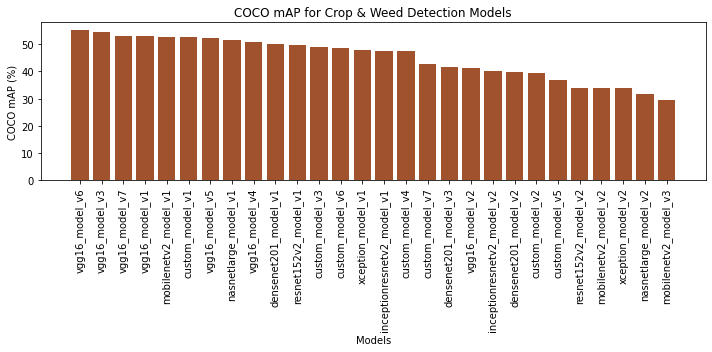

In [5]:
# plotting COCO mAP for each model validation data
x_models_mAP = df_results_val_mAP['model']
y_mAP = (df_results_val_mAP['coco_map'])*100
fig = plt.figure(figsize = (10, 5))
plt.bar(x_models_mAP, y_mAP, color='sienna')
plt.xlabel("Models")
plt.xticks(rotation=90)
plt.ylabel("COCO mAP (%)")
plt.title("COCO mAP for Crop & Weed Detection Models")
plt.tight_layout()
plt.savefig("../Plots/COCO mAP for Crop & Weed Detection Models", bbox_inches = 'tight')
plt.show()

Looks like the model with the VGG16 backbone and the 6th version of the model heads had the highest COCO Mean Average Precision score. It's COCO mAP score on the validation set was 55.3%.

Next we will look at our secondary metric the average inference time the model takes to make a predition on an image.
First we order the model iterations in order of lowest to highest average inference time.

In [6]:
# sorting results dataframe by average inference time
df_results_val_inf = df_results_val.sort_values(by='avg_inf_time')
df_results_val_inf

,model,voc_pascal_map,voc_pascal_map_allpts,coco_map,avg_inf_time
27,custom_model_v7,0.266990,0.238323,0.425866,0.039022
26,custom_model_v6,0.329115,0.307787,0.485723,0.039469
23,custom_model_v3,0.113536,0.077397,0.490176,0.039542
22,custom_model_v2,0.149513,0.111420,0.396043,0.040156
21,custom_model_v1,0.293027,0.276247,0.526225,0.040169
25,custom_model_v5,0.170618,0.125233,0.368478,0.040562
24,custom_model_v4,0.188992,0.165370,0.476062,0.042544
14,mobilenetv2_model_v2,0.130821,0.073480,0.338740,0.071017
15,mobilenetv2_model_v3,0.229407,0.173645,0.296418,0.071613
13,mobilenetv2_model_v1,0.351913,0.344712,0.526454,0.072912


Then we will plot each model's average inference time.

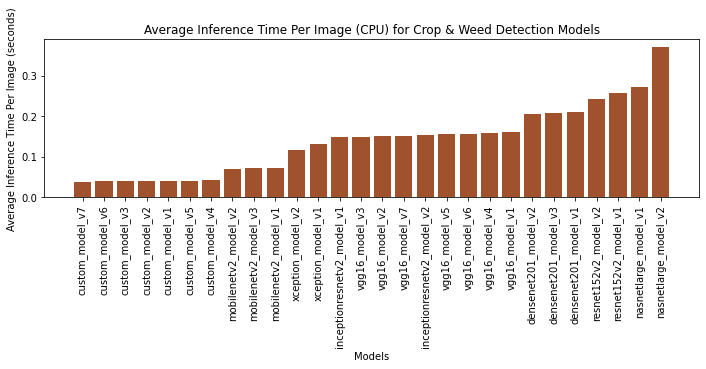

In [7]:
# plotting average inference times per image for each model validation data
x_models_inf = df_results_val_inf['model']
y_inf = df_results_val_inf['avg_inf_time']
fig = plt.figure(figsize = (10, 5))
plt.bar(x_models_inf, y_inf, color='sienna')
plt.xlabel("Models")
plt.xticks(rotation=90)
plt.ylabel("Average Inference Time Per Image (seconds)")
plt.title("Average Inference Time Per Image (CPU) for Crop & Weed Detection Models")
plt.tight_layout()
plt.savefig("../Plots/Average Inference Time Per Image (CPU) for Crop & Weed Detection Models", bbox_inches = 'tight')
plt.show()

Looks like the model with the custom backbone and the 7th version of the model heads had the lowest average inference time. It's average inference time on the validation set was 0.039 seconds.

## Conclusions

Now lets evaluate both those models on the test set.

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_test = evaluate_test(model=vgg16_model_v6, model_name='vgg16_model_v6')

In [ ]:
# VOC PASCAL mAP for vgg16_model_v6 test data: 0.37646448612213135
# VOC PASCAL mAP in all points for vgg16_model_v6 test data: 0.3488677442073822
# COCO mAP for vgg16_model_v6 test data: 0.5667098164558411
# Average inference time for vgg16_model_v6 test data: 0.16412345812870907

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_test = df_results_test.append(result_test, ignore_index=True)
df_results_test

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_test = evaluate_test(model=custom_model_v7, model_name='custom_model_v7')

In [ ]:
# VOC PASCAL mAP for custom_model_v7 test data: 0.24317646026611328
# VOC PASCAL mAP in all points for custom_model_v7 test data: 0.20839717984199524
# COCO mAP for custom_model_v7 test data: 0.44890815019607544
# Average inference time for custom_model_v7 test data: 0.03511611956816453

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_test = df_results_test.append(result_test, ignore_index=True)
df_results_test

However for comparitive purposes, since custom_model_v7 and custom model_v1 had nearly identical average inference times, only a difference of 0.001 seconds, lets compare the best COCO mAP score model to the custom model with the best COCO mAP score as well.

In [ ]:
# evaluating model for mAP metrics and inference time and storing result
result_test = evaluate_test(model=custom_model_v1, model_name='custom_model_v1')

In [ ]:
# VOC PASCAL mAP for custom_model_v1 test data: 0.2634250521659851
# VOC PASCAL mAP in all points for custom_model_v1 test data: 0.2261561155319214
# COCO mAP for custom_model_v1 test data: 0.5533956289291382
# Average inference time for custom_model_v1 test data: 0.036563799931452826

In [ ]:
# appending results of model evaluation to results dataframe (df_results)
df_results_test = df_results_test.append(result_test, ignore_index=True)
df_results_test

Lastly we save all the results from the test set evaluation in a csv.

In [ ]:
# saving results dataframe as csv
df_results_test.to_csv(r'../Evaluation/df_results_test.csv', index=False)

Loading results for finals models evaluation on test set.

In [9]:
# loading validation results dataframe (df_results_val) from csv
df_results_test = pd.read_csv('../Evaluation/df_results_test.csv')
df_results_test

,model,voc_pascal_map,voc_pascal_map_allpts,coco_map,avg_inf_time
0,vgg16_model_v6,0.376464,0.348868,0.566710,0.164123
1,custom_model_v7,0.243176,0.208397,0.448908,0.035116
2,custom_model_v1,0.263425,0.226156,0.553396,0.036564


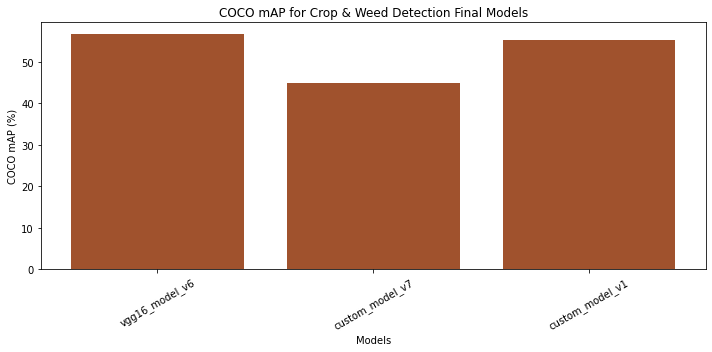

In [10]:
# plotting COCO mAP for each model validation data
x_models_final = df_results_test['model']
y_mAP_final = (df_results_test['coco_map'])*100
fig = plt.figure(figsize = (10, 5))
plt.bar(x_models_final, y_mAP_final, color='sienna')
plt.xlabel("Models")
plt.xticks(rotation=30)
plt.ylabel("COCO mAP (%)")
plt.title("COCO mAP for Crop & Weed Detection Final Models")
plt.tight_layout()
plt.savefig("../Plots/COCO mAP for Crop & Weed Detection Final Models", bbox_inches = 'tight')
plt.show()

As you can see the model with the VGG16 backbone and 6th version of the model heads had the highest COCO mAP score on the test set. Its COCO mAP score on the test set was 56.7% which is acutally higher than its score on the validation set (55.3%). It is also interesting to note that the model with the custom backbone and 1st version of the model heads, which was much faster than its vgg16 counterpart, 0.037 seconds compared to 0.164 seconds, respecitvely, only had a 1.4% reduction in COCO mAP score on the test set at 55.3% when compared to VGG16 backbone model (56.7%).